# Internet of Things (2IMN25)
### Machine Learning Assignment

### Introduction

The objective of the assignment is to use supervised machine learning techniques to make predictions about the net energy consumed based on the weather conditions. This will be accomplished by training a regression model on (real) data obtained from the weather sensor and energy meter over this year. This model will then be used to make predictions about the net energy consumption for data-points not *seen* by the model during training.

In [12]:
""" Import all libraries here """
import numpy as np
import os
import math
from datetime import datetime
import pandas as pd
from dateutil import parser
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


## Reading the dataset

In the code box below, please read in the data-sets into suitable data structures. The key task here would be to contruct the feature vectors which would be fed to the regression algorithm.

The datasets for the weather, rain and energy consumption have been provided in the zip file, extract this zip file into the same folder as the python notebook. 

*Hint : Be sure to check if there are any missing fields in the provided data*

In [13]:
def merge_weather_rain_data(data_path):
    """ 
    Reads in the CSV files for weather and rain data
    Merged them into a single array based on matching time-stamps
    
    """
        
    """ Read in the weather"""
    weather_array = pd.read_csv(os.path.join(data_path,'Weather-Eindhoven.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0],
                             usecols = [0,2,4,6,7,8]) #Drop "chill", too many missing values
    weather_array  = weather_array.as_matrix()

    """ Read in the rain data"""
    rain_array = pd.read_csv(os.path.join(data_path,'Rain-Best.csv'),
                             delimiter = ',',
                             header=0,
                             parse_dates = [0])

    rain_array = rain_array.as_matrix()

    """ Synchronize the 2 data-sets by removing the extra data from the rainfall dataset"""
    remove_rows = []
    for element,idx in zip(rain_array[:,0],range(len(rain_array[:,0]))):
        if element.minute%10 != 0:
            remove_rows.append(idx)

    synced_rain_array = np.delete(rain_array,remove_rows,axis = 0)

    print(synced_rain_array.shape)
    print(weather_array[:,0].shape)

    """ Merge the weather and rain data when time-stamps are equal """
    merged_array = []
    for rainElem in synced_rain_array:
        try :
            merged_row = []
            valid_row = list(weather_array[:,0]).index(rainElem[0])
            for weatherFeature in weather_array[valid_row]:
                merged_row.append(weatherFeature)
            merged_row.append(rainElem[1])
            merged_array.append(np.asarray(merged_row))
        except ValueError:
            print('Did not find matching timestamp in the weather data, continuing')
            continue

    merged_array = np.asarray(merged_array)
    return merged_array

# Create the merged array
data_path = os.path.join(os.getcwd(),'data')
merged_array = merge_weather_rain_data(data_path)

(43844, 2)
(43872,)
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matching timestamp in the weather data, continuing
Did not find matchin

In [14]:

def clean_up(merged_array):
    """ 
    Clean up the data by removing rows with missing data points 
    
    """
    missing_data_rows = []
    for row,idx in zip(merged_array,range(merged_array.shape[0])):
        if row[0].month > 10:
            missing_data_rows.append(idx)
            continue # No energy data for the month of November so delete those too.
        for elem in row[1:]: #Timestamp cannot be "checked"
            if math.isnan(elem):
                missing_data_rows.append(idx)
                break # To prevent the same row from being added multiple times to the list, break when the first "nan" is found
    clean_data_array = np.delete(merged_array,missing_data_rows,axis=0)
    return clean_data_array

clean_data_array = clean_up(merged_array)


In [15]:
def create_dataframe(energyDir):
    """ Returns a dataframe that is formed by concatenating all the energy data files """
    fileList = []
    energyDir = os.path.join(os.getcwd(),energyDir)
    dirList = [os.path.join(energyDir, o) for o in os.listdir(energyDir) 
                    if os.path.isdir(os.path.join(energyDir,o))]
    
    sortedDirList = sorted(dirList)
    for direc in sortedDirList:
        dirFiles = [os.path.join(direc, f) for f in os.listdir(direc) 
                    if os.path.isfile(os.path.join(direc,f))]
        for f in dirFiles:
            fileList.append(f)
        
    fileList = sorted(fileList)
    frame = pd.DataFrame()
    frameList = []
    for f in fileList:
        try:
            df = pd.read_csv(f,index_col=None, header=None,parse_dates=[[0,1]],skipfooter=2)
            frameList.append(df)
        except:
            continue
    frame = pd.concat(frameList)
    sparseFrame = frame.drop([2,3,4,5,6,7,8,9,13],axis=1)
    sparseFrame.columns = ['TimeStamp','Energy Consumed','Energy Produced','Solar Energy Produced']
    return sparseFrame
    
energyFrame = create_dataframe('data/2017')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [16]:
def energy_lookup(data_array,energyFrame,idx):
    """ 
    Given the index, calculated the net-energy consumed in the 10-minute interval preceeding current time
    
    """
    try:
        subFrame = energyFrame[(energyFrame['TimeStamp']>data_array[idx-1][0]) & (energyFrame['TimeStamp']<data_array[idx][0])]
        if subFrame.shape[0] == 0:
            return None,None
        energyList = []
        solarList = []
        for cons,prod,solar in zip(subFrame['Energy Consumed'],subFrame['Energy Produced'],subFrame['Solar Energy Produced']):
            energyList.append(cons-prod)
            solarList.append(solar)
        return np.sum(np.asarray(energyList)),np.sum(np.asarray(solar))
    except:
        return None,None

def create_labels(data_array,energyFrame):
    """
    Uses the look-up function to create labels (if possible)
    for every feature vector in the feature array.
    
    """
    
    missing_labels = []
    labels = []
    labels_solar = []
    labels.append(0)
    labels_solar.append(0)
    energyFrame['TimeStamp'] = pd.to_datetime(energyFrame['TimeStamp']) 
    for row,idx in zip(data_array,range(data_array.shape[0])):
        if idx == 0:
            continue
        netEnergy,netSolar = energy_lookup(data_array,energyFrame,idx)
        if netEnergy is None and netSolar is None:
            print('Missing label for row {}'.format(idx))
            missing_labels.append(idx)
        else:
            print('{} {} {}'.format(row[0],netEnergy,netSolar))
            labels.append(netEnergy)
            labels_solar.append(netSolar)
    return labels,labels_solar,missing_labels

labels,labels_solar,missing_labels = create_labels(clean_data_array,energyFrame)
        
            

2017-01-01 00:10:00 29060 0
2017-01-01 00:20:00 22260 0
2017-01-01 00:30:00 77630 0
2017-01-01 00:40:00 47870 0
2017-01-01 00:50:00 39400 0
2017-01-01 01:00:00 33420 0
2017-01-01 01:10:00 37830 0
2017-01-01 01:20:00 32670 0
2017-01-01 01:30:00 28250 0
2017-01-01 01:40:00 29980 0
2017-01-01 01:50:00 21270 0
2017-01-01 02:00:00 19600 0
2017-01-01 02:10:00 23560 0
2017-01-01 02:20:00 29330 0
2017-01-01 02:30:00 35320 0
2017-01-01 02:40:00 21480 0
2017-01-01 02:50:00 20330 0
2017-01-01 03:00:00 23330 0
2017-01-01 03:10:00 22760 0
2017-01-01 03:20:00 19360 0
2017-01-01 03:30:00 18870 0
2017-01-01 03:40:00 18740 0
2017-01-01 03:50:00 15930 0
2017-01-01 04:00:00 12600 0
2017-01-01 04:10:00 12700 0
2017-01-01 04:20:00 17000 0
2017-01-01 04:30:00 12600 0
2017-01-01 04:40:00 13820 0
2017-01-01 04:50:00 21200 0
2017-01-01 05:00:00 16790 0
2017-01-01 05:10:00 16310 0
2017-01-01 05:20:00 47020 0
2017-01-01 05:30:00 16890 0
2017-01-01 05:40:00 11400 0
2017-01-01 05:50:00 15670 0
2017-01-01 06:00:00 

2017-01-03 00:40:00 41140 0
2017-01-03 00:50:00 38970 0
2017-01-03 01:00:00 27850 0
2017-01-03 01:10:00 17620 0
2017-01-03 01:20:00 12600 0
2017-01-03 01:30:00 22510 0
2017-01-03 01:40:00 14500 0
2017-01-03 01:50:00 12020 0
2017-01-03 02:00:00 16160 0
2017-01-03 02:10:00 21830 0
2017-01-03 02:20:00 26770 0
2017-01-03 02:30:00 14300 0
2017-01-03 02:40:00 13010 0
2017-01-03 02:50:00 11400 0
2017-01-03 03:00:00 13660 0
2017-01-03 03:10:00 2240 0
Missing label for row 308
Missing label for row 309
Missing label for row 310
Missing label for row 311
Missing label for row 312
Missing label for row 313
Missing label for row 314
Missing label for row 315
Missing label for row 316
Missing label for row 317
Missing label for row 318
Missing label for row 319
Missing label for row 320
Missing label for row 321
Missing label for row 322
Missing label for row 323
Missing label for row 324
Missing label for row 325
Missing label for row 326
Missing label for row 327
Missing label for row 328
Missing

2017-01-05 01:00:00 14660 0
2017-01-05 01:10:00 10520 0
2017-01-05 01:20:00 11880 0
2017-01-05 01:30:00 7800 0
2017-01-05 01:40:00 7810 0
2017-01-05 01:50:00 12500 0
2017-01-05 02:00:00 7980 0
2017-01-05 02:10:00 30570 0
2017-01-05 02:20:00 11620 0
2017-01-05 02:30:00 8790 0
2017-01-05 02:40:00 7800 0
2017-01-05 02:50:00 12040 0
2017-01-05 03:00:00 16040 0
2017-01-05 03:10:00 14730 0
2017-01-05 03:20:00 14510 0
2017-01-05 03:30:00 16460 0
2017-01-05 03:40:00 12600 0
2017-01-05 03:50:00 11250 0
2017-01-05 04:00:00 12590 0
2017-01-05 04:10:00 7800 0
2017-01-05 04:20:00 7800 0
2017-01-05 04:30:00 11770 0
2017-01-05 04:40:00 8530 0
2017-01-05 04:50:00 7610 0
2017-01-05 05:00:00 23700 0
2017-01-05 05:10:00 44940 0
2017-01-05 05:20:00 9370 0
2017-01-05 05:30:00 10610 0
2017-01-05 05:40:00 13870 0
2017-01-05 05:50:00 9970 0
2017-01-05 06:00:00 7930 0
2017-01-05 06:10:00 15950 0
2017-01-05 06:20:00 12600 0
2017-01-05 06:30:00 12600 0
2017-01-05 06:40:00 17430 0
2017-01-05 06:50:00 13260 0
2017

2017-01-07 01:50:00 18550 0
2017-01-07 02:00:00 19860 0
2017-01-07 02:10:00 21540 0
2017-01-07 02:20:00 23150 0
2017-01-07 02:30:00 16720 0
2017-01-07 02:40:00 22110 0
2017-01-07 02:50:00 23020 0
2017-01-07 03:00:00 19000 0
2017-01-07 03:10:00 17100 0
2017-01-07 03:20:00 18440 0
2017-01-07 03:30:00 14030 0
2017-01-07 03:40:00 12060 0
2017-01-07 03:50:00 14540 0
2017-01-07 04:00:00 12720 0
2017-01-07 04:10:00 10910 0
2017-01-07 04:20:00 12470 0
2017-01-07 04:30:00 32320 0
2017-01-07 04:40:00 10900 0
2017-01-07 04:50:00 13260 0
2017-01-07 05:00:00 13490 0
2017-01-07 05:10:00 12270 0
2017-01-07 05:20:00 18670 0
2017-01-07 05:30:00 15180 0
2017-01-07 05:40:00 10960 0
2017-01-07 05:50:00 12200 0
2017-01-07 06:00:00 14150 0
2017-01-07 06:10:00 11360 0
2017-01-07 06:20:00 14630 0
2017-01-07 06:30:00 15490 0
2017-01-07 06:40:00 12600 0
2017-01-07 06:50:00 14400 0
2017-01-07 07:00:00 15220 0
2017-01-07 07:10:00 40070 0
2017-01-07 07:20:00 18870 0
2017-01-07 07:30:00 19980 0
2017-01-07 07:40:00 

2017-01-09 02:50:00 7800 0
2017-01-09 03:00:00 35210 0
2017-01-09 03:10:00 7800 0
2017-01-09 03:20:00 10170 0
2017-01-09 03:30:00 18100 0
2017-01-09 03:40:00 8020 0
2017-01-09 03:50:00 7800 0
2017-01-09 04:00:00 11680 0
2017-01-09 04:10:00 8600 0
2017-01-09 04:20:00 7800 0
2017-01-09 04:30:00 10500 0
2017-01-09 04:40:00 12010 0
2017-01-09 04:50:00 12720 0
2017-01-09 05:00:00 16070 0
2017-01-09 05:10:00 14470 0
2017-01-09 05:20:00 12000 0
2017-01-09 05:30:00 10500 0
2017-01-09 05:40:00 30870 0
2017-01-09 05:50:00 16930 0
2017-01-09 06:00:00 14200 0
2017-01-09 06:10:00 16400 0
2017-01-09 06:20:00 12600 0
2017-01-09 06:30:00 12510 0
2017-01-09 06:40:00 16970 0
2017-01-09 06:50:00 13260 0
2017-01-09 07:00:00 13970 0
2017-01-09 07:10:00 51280 0
2017-01-09 07:20:00 31610 0
2017-01-09 07:30:00 14370 0
2017-01-09 07:40:00 59890 0
2017-01-09 07:50:00 49180 0
2017-01-09 08:00:00 20630 0
2017-01-09 08:10:00 26320 0
2017-01-09 08:20:00 19460 0
2017-01-09 08:30:00 24320 0
2017-01-09 08:40:00 28260 

2017-01-11 03:00:00 11170 0
2017-01-11 03:10:00 13060 0
2017-01-11 03:20:00 17740 0
2017-01-11 03:30:00 14800 0
2017-01-11 03:40:00 12070 0
2017-01-11 03:50:00 12670 0
2017-01-11 04:00:00 10210 0
2017-01-11 04:10:00 13740 0
2017-01-11 04:20:00 36435 0
2017-01-11 04:30:00 9850 0
2017-01-11 04:40:00 7540 0
2017-01-11 04:50:00 8120 0
2017-01-11 05:00:00 11730 0
2017-01-11 05:10:00 7270 0
2017-01-11 05:20:00 7510 0
2017-01-11 05:30:00 11780 0
2017-01-11 05:40:00 8530 0
2017-01-11 05:50:00 7470 0
2017-01-11 06:00:00 9990 0
2017-01-11 06:10:00 9810 0
2017-01-11 06:20:00 11930 0
2017-01-11 06:30:00 16850 0
2017-01-11 06:40:00 16930 0
2017-01-11 06:50:00 12240 0
2017-01-11 07:00:00 12030 0
2017-01-11 07:10:00 18510 0
2017-01-11 07:20:00 18600 0
2017-01-11 07:30:00 42180 0
2017-01-11 07:40:00 41330 0
2017-01-11 07:50:00 33210 0
2017-01-11 08:00:00 36470 0
2017-01-11 08:10:00 18240 0
2017-01-11 08:20:00 17110 0
2017-01-11 08:30:00 17650 0
2017-01-11 08:40:00 25850 0
2017-01-11 08:50:00 16610 0
2

2017-01-13 03:00:00 11670 0
2017-01-13 03:10:00 16180 0
2017-01-13 03:20:00 11400 0
2017-01-13 03:30:00 11400 0
2017-01-13 03:40:00 14800 0
2017-01-13 03:50:00 13110 0
2017-01-13 04:00:00 11390 0
2017-01-13 04:10:00 12590 0
2017-01-13 04:20:00 15180 0
2017-01-13 04:30:00 11120 0
2017-01-13 04:40:00 10890 0
2017-01-13 04:50:00 21100 0
2017-01-13 05:00:00 17410 0
2017-01-13 05:10:00 16200 0
2017-01-13 05:20:00 18550 0
2017-01-13 05:30:00 18970 0
2017-01-13 05:40:00 15720 0
2017-01-13 05:50:00 30740 0
2017-01-13 06:00:00 23550 0
2017-01-13 06:10:00 10980 0
2017-01-13 06:20:00 11960 0
2017-01-13 06:30:00 16200 0
2017-01-13 06:40:00 14180 0
2017-01-13 06:50:00 12500 0
2017-01-13 07:00:00 18610 0
2017-01-13 07:10:00 21030 0
2017-01-13 07:20:00 12010 0
2017-01-13 07:30:00 12000 0
2017-01-13 07:40:00 18000 0
2017-01-13 07:50:00 50230 0
2017-01-13 08:00:00 33240 0
2017-01-13 08:10:00 24600 0
2017-01-13 08:20:00 17860 0
2017-01-13 08:30:00 17060 0
2017-01-13 08:40:00 22460 0
2017-01-13 08:50:00 

2017-01-15 04:50:00 15660 0
2017-01-15 05:00:00 25950 0
2017-01-15 05:10:00 21020 0
2017-01-15 05:20:00 16610 0
2017-01-15 05:30:00 41610 0
2017-01-15 05:40:00 16500 0
2017-01-15 05:50:00 11400 0
2017-01-15 06:00:00 15130 0
2017-01-15 06:10:00 13920 0
2017-01-15 06:20:00 11400 0
2017-01-15 06:30:00 13930 0
2017-01-15 06:40:00 14690 0
2017-01-15 06:50:00 18020 0
2017-01-15 07:00:00 21560 0
2017-01-15 07:10:00 16420 0
2017-01-15 07:20:00 13200 0
2017-01-15 07:30:00 14020 0
2017-01-15 07:40:00 16700 0
2017-01-15 07:50:00 12680 0
2017-01-15 08:00:00 12580 0
2017-01-15 08:10:00 17410 0
2017-01-15 08:20:00 15180 0
2017-01-15 08:30:00 26330 0
2017-01-15 08:40:00 207030 50
2017-01-15 08:50:00 176449 63
2017-01-15 09:00:00 176500 136
2017-01-15 09:10:00 44709 81
2017-01-15 09:20:00 24000 93
2017-01-15 09:30:00 22580 78
2017-01-15 09:40:00 22830 53
2017-01-15 09:50:00 16290 213
2017-01-15 10:00:00 12350 222
2017-01-15 10:10:00 4020 318
2017-01-15 10:20:00 9660 199
2017-01-15 10:30:00 22890 198
2

2017-01-17 06:40:00 28290 0
2017-01-17 06:50:00 23430 0
2017-01-17 07:00:00 18510 0
2017-01-17 07:10:00 16890 0
2017-01-17 07:20:00 13000 0
2017-01-17 07:30:00 19930 0
2017-01-17 07:40:00 76100 0
2017-01-17 07:50:00 82500 0
2017-01-17 08:00:00 35860 0
2017-01-17 08:10:00 29370 0
2017-01-17 08:20:00 24060 0
2017-01-17 08:30:00 25020 0
2017-01-17 08:40:00 29500 0
2017-01-17 08:50:00 13900 54
2017-01-17 09:00:00 10180 71
2017-01-17 09:10:00 11750 113
2017-01-17 09:20:00 40910 60
2017-01-17 09:30:00 13510 34
2017-01-17 09:40:00 14930 21
2017-01-17 09:50:00 10780 9
2017-01-17 10:00:00 10900 76
2017-01-17 10:10:00 15380 32
2017-01-17 10:20:00 10740 9
2017-01-17 10:30:00 10730 9
2017-01-17 10:40:00 12710 77
2017-01-17 10:50:00 -14580 414
2017-01-17 11:00:00 -10970 426
2017-01-17 11:10:00 -27520 940
2017-01-17 11:20:00 -36690 893
2017-01-17 11:30:00 -46760 568
2017-01-17 11:40:00 -65740 1351
2017-01-17 11:50:00 -83170 1673
2017-01-17 12:00:00 -47980 1482
2017-01-17 12:10:00 -74500 1657
2017-01

2017-01-19 07:50:00 62210 0
2017-01-19 08:00:00 56110 0
2017-01-19 08:10:00 54410 0
2017-01-19 08:20:00 20550 0
2017-01-19 08:30:00 18290 0
2017-01-19 08:40:00 20390 52
2017-01-19 08:50:00 22610 62
2017-01-19 09:00:00 25520 68
2017-01-19 09:10:00 23950 93
2017-01-19 09:20:00 15810 21
2017-01-19 09:30:00 18240 9
2017-01-19 09:40:00 19080 236
2017-01-19 09:50:00 8470 279
2017-01-19 10:00:00 -1690 534
2017-01-19 10:10:00 -9550 604
2017-01-19 10:20:00 -32200 795
2017-01-19 10:30:00 -65870 1437
2017-01-19 10:40:00 -68260 1504
2017-01-19 10:50:00 -9800 1566
2017-01-19 11:00:00 71470 1653
2017-01-19 11:10:00 -49260 1684
2017-01-19 11:20:00 -60160 1719
2017-01-19 11:30:00 -77540 1736
2017-01-19 11:40:00 -76390 1770
2017-01-19 11:50:00 -78750 1798
2017-01-19 12:00:00 -85180 1797
2017-01-19 12:10:00 -82900 1840
2017-01-19 12:20:00 -87850 1810
2017-01-19 12:30:00 -89720 1788
2017-01-19 12:40:00 -87300 1785
2017-01-19 12:50:00 -83110 1734
2017-01-19 13:00:00 -82050 1720
2017-01-19 13:10:00 -88860 

2017-01-21 07:40:00 16900 0
2017-01-21 07:50:00 44340 0
2017-01-21 08:00:00 13520 0
2017-01-21 08:10:00 12000 0
2017-01-21 08:20:00 14800 0
2017-01-21 08:30:00 13890 50
2017-01-21 08:40:00 11390 64
2017-01-21 08:50:00 13050 78
2017-01-21 09:00:00 11990 87
2017-01-21 09:10:00 8390 44
2017-01-21 09:20:00 8940 191
2017-01-21 09:30:00 15500 83
2017-01-21 09:40:00 5350 182
2017-01-21 09:50:00 -3800 268
2017-01-21 10:00:00 -5000 491
2017-01-21 10:10:00 -20730 740
2017-01-21 10:20:00 -41130 1074
2017-01-21 10:30:00 -66660 1505
2017-01-21 10:40:00 -83180 1581
2017-01-21 10:50:00 -87300 1634
2017-01-21 11:00:00 -56970 1650
2017-01-21 11:10:00 -58390 1692
2017-01-21 11:20:00 -88080 1697
2017-01-21 11:30:00 -85980 1740
2017-01-21 11:40:00 -89220 1756
2017-01-21 11:50:00 -91340 1759
2017-01-21 12:00:00 -89050 1743
2017-01-21 12:10:00 -93630 1781
2017-01-21 12:20:00 -97290 1779
2017-01-21 12:30:00 -82160 1756
2017-01-21 12:40:00 -91770 1733
2017-01-21 12:50:00 -86830 1692
2017-01-21 13:00:00 -87070

2017-01-23 07:40:00 17450 0
2017-01-23 07:50:00 74590 0
2017-01-23 08:00:00 26090 0
2017-01-23 08:10:00 25300 0
2017-01-23 08:20:00 23900 0
2017-01-23 08:30:00 22030 0
2017-01-23 08:40:00 25310 0
2017-01-23 08:50:00 16860 0
2017-01-23 09:00:00 15220 0
2017-01-23 09:10:00 18180 54
2017-01-23 09:20:00 42430 66
2017-01-23 09:30:00 13800 63
2017-01-23 09:40:00 14940 88
2017-01-23 09:50:00 16190 84
2017-01-23 10:00:00 13450 83
2017-01-23 10:10:00 16630 171
2017-01-23 10:20:00 18410 111
2017-01-23 10:30:00 28140 94
2017-01-23 10:40:00 195634 84
2017-01-23 10:50:00 93230 44
2017-01-23 11:00:00 23160 72
2017-01-23 11:10:00 35140 56
2017-01-23 11:20:00 36220 69
2017-01-23 11:30:00 24610 55
2017-01-23 11:40:00 22990 53
2017-01-23 11:50:00 25200 64
2017-01-23 12:00:00 21250 9
2017-01-23 12:10:00 23380 55
2017-01-23 12:20:00 24580 9
2017-01-23 12:30:00 19940 59
2017-01-23 12:40:00 45470 23
2017-01-23 12:50:00 186860 8
2017-01-23 13:00:00 157310 32
2017-01-23 13:10:00 166870 43
2017-01-23 13:20:00 

2017-01-25 09:40:00 7700 61
2017-01-25 09:50:00 7850 83
2017-01-25 10:00:00 33960 52
2017-01-25 10:10:00 15740 56
2017-01-25 10:20:00 68310 17
2017-01-25 10:30:00 124058 48
2017-01-25 10:40:00 105430 50
2017-01-25 10:50:00 31300 54
2017-01-25 11:00:00 14010 51
2017-01-25 11:10:00 37250 31
2017-01-25 11:20:00 37020 26
2017-01-25 11:30:00 33540 54
2017-01-25 11:40:00 37620 9
2017-01-25 11:50:00 37310 51
2017-01-25 12:00:00 33120 107
2017-01-25 12:10:00 15100 311
2017-01-25 12:20:00 16770 319
2017-01-25 12:30:00 13870 269
2017-01-25 12:40:00 8480 252
2017-01-25 12:50:00 8710 237
2017-01-25 13:00:00 67127 272
2017-01-25 13:10:00 9210 268
2017-01-25 13:20:00 3900 248
2017-01-25 13:30:00 4820 242
2017-01-25 13:40:00 10560 230
2017-01-25 13:50:00 3340 274
2017-01-25 14:00:00 -20 276
2017-01-25 14:10:00 5110 277
2017-01-25 14:20:00 650 239
2017-01-25 14:30:00 810 228
2017-01-25 14:40:00 410 295
2017-01-25 14:50:00 -11450 505
2017-01-25 15:00:00 -24450 685
2017-01-25 15:10:00 -37240 962
2017-01

2017-01-27 09:10:00 13550 94
2017-01-27 09:20:00 32510 29
2017-01-27 09:30:00 20160 14
2017-01-27 09:40:00 27830 68
2017-01-27 09:50:00 9000 321
2017-01-27 10:00:00 -8260 379
2017-01-27 10:10:00 11980 561
2017-01-27 10:20:00 -8900 430
2017-01-27 10:30:00 -15710 507
2017-01-27 10:40:00 -22670 777
2017-01-27 10:50:00 -29490 793
2017-01-27 11:00:00 -40080 814
2017-01-27 11:10:00 -41360 1006
2017-01-27 11:20:00 -44090 1044
2017-01-27 11:30:00 -60990 1121
2017-01-27 11:40:00 -50390 1058
2017-01-27 11:50:00 -43510 920
2017-01-27 12:00:00 -42600 940
2017-01-27 12:10:00 -48330 1102
2017-01-27 12:20:00 -60320 1230
2017-01-27 12:30:00 -49540 947
2017-01-27 12:40:00 -49910 1101
2017-01-27 12:50:00 -22030 827
2017-01-27 13:00:00 -50770 1020
2017-01-27 13:10:00 -13050 1046
2017-01-27 13:20:00 -19500 1116
2017-01-27 13:30:00 -36590 965
2017-01-27 13:40:00 -22320 750
2017-01-27 13:50:00 -25740 802
2017-01-27 14:00:00 -23900 774
2017-01-27 14:10:00 -22040 759
2017-01-27 14:20:00 -32190 962
2017-01-27 

2017-01-29 09:00:00 44540 120
2017-01-29 09:10:00 20830 74
2017-01-29 09:20:00 17880 64
2017-01-29 09:30:00 15390 57
2017-01-29 09:40:00 13280 9
2017-01-29 09:50:00 -5110 407
2017-01-29 10:00:00 -15540 654
2017-01-29 10:10:00 -23150 679
2017-01-29 10:20:00 -7730 430
2017-01-29 10:30:00 18980 360
2017-01-29 10:40:00 2090 219
2017-01-29 10:50:00 700 260
2017-01-29 11:00:00 -6420 333
2017-01-29 11:10:00 -3620 426
2017-01-29 11:20:00 4190 526
2017-01-29 11:30:00 -3480 311
2017-01-29 11:40:00 -3220 295
2017-01-29 11:50:00 760 253
2017-01-29 12:00:00 -7250 353
2017-01-29 12:10:00 -7320 210
2017-01-29 12:20:00 -18470 787
2017-01-29 12:30:00 -13560 436
2017-01-29 12:40:00 -14390 482
2017-01-29 12:50:00 8420 240
2017-01-29 13:00:00 31220 681
2017-01-29 13:10:00 59060 277
2017-01-29 13:20:00 -4720 306
2017-01-29 13:30:00 6440 542
2017-01-29 13:40:00 -38900 1654
2017-01-29 13:50:00 -8320 371
2017-01-29 14:00:00 -9570 373
2017-01-29 14:10:00 -12670 272
2017-01-29 14:20:00 -4660 223
2017-01-29 14:3

2017-01-31 10:50:00 11330 79
2017-01-31 11:00:00 16210 99
2017-01-31 11:10:00 11580 63
2017-01-31 11:20:00 15740 54
2017-01-31 11:30:00 19950 49
2017-01-31 11:40:00 2340 388
2017-01-31 11:50:00 5280 324
2017-01-31 12:00:00 -600 292
2017-01-31 12:10:00 -2920 279
2017-01-31 12:20:00 18010 270
2017-01-31 12:30:00 6120 239
2017-01-31 12:40:00 4330 270
2017-01-31 12:50:00 3370 233
2017-01-31 13:00:00 4850 254
2017-01-31 13:10:00 4370 283
2017-01-31 13:20:00 -1000 276
2017-01-31 13:30:00 2130 262
2017-01-31 13:40:00 1740 285
2017-01-31 13:50:00 -3970 282
2017-01-31 14:00:00 -4040 288
2017-01-31 14:10:00 1540 260
2017-01-31 14:20:00 2610 206
2017-01-31 14:30:00 2480 180
2017-01-31 14:40:00 6080 154
2017-01-31 14:50:00 10610 187
2017-01-31 15:00:00 9630 103
2017-01-31 15:10:00 33458 71
2017-01-31 15:20:00 15300 50
2017-01-31 15:30:00 16770 9
2017-01-31 15:40:00 13430 68
2017-01-31 15:50:00 13400 81
2017-01-31 16:00:00 13530 83
2017-01-31 16:10:00 47808 70
2017-01-31 16:20:00 44250 78
2017-01-3

2017-02-02 12:00:00 -20440 727
2017-02-02 12:10:00 6780 669
2017-02-02 12:20:00 -1060 488
2017-02-02 12:30:00 17410 414
2017-02-02 12:40:00 -10270 463
2017-02-02 12:50:00 -16770 567
2017-02-02 13:00:00 -87195 2346
2017-02-02 13:10:00 -79790 1333
2017-02-02 13:20:00 -55000 1210
2017-02-02 13:30:00 -42520 1212
2017-02-02 13:40:00 91690 762
2017-02-02 13:50:00 113465 726
2017-02-02 14:00:00 70159 429
2017-02-02 14:10:00 69383 546
2017-02-02 14:20:00 68899 584
2017-02-02 14:30:00 62158 628
2017-02-02 14:40:00 -3970 905
2017-02-02 14:50:00 -50170 1217
2017-02-02 15:00:00 -29990 695
2017-02-02 15:10:00 -44590 918
2017-02-02 15:20:00 -40800 847
2017-02-02 15:30:00 -840 395
2017-02-02 15:40:00 -5900 192
2017-02-02 15:50:00 -2260 220
2017-02-02 16:00:00 1930 205
2017-02-02 16:10:00 1040 154
2017-02-02 16:20:00 1010 206
2017-02-02 16:30:00 9010 82
2017-02-02 16:40:00 11080 79
2017-02-02 16:50:00 6180 61
2017-02-02 17:00:00 6170 73
2017-02-02 17:10:00 21960 65
2017-02-02 17:20:00 17230 50
2017-02

2017-02-04 13:10:00 147670 229
2017-02-04 13:20:00 186150 222
2017-02-04 13:30:00 119410 207
2017-02-04 13:40:00 86360 222
2017-02-04 13:50:00 90050 201
2017-02-04 14:00:00 64500 192
2017-02-04 14:10:00 34990 156
2017-02-04 14:20:00 7370 126
2017-02-04 14:30:00 11890 89
2017-02-04 14:40:00 13120 46
2017-02-04 14:50:00 13310 69
2017-02-04 15:00:00 16010 77
2017-02-04 15:10:00 11250 73
2017-02-04 15:20:00 6880 79
2017-02-04 15:30:00 14340 101
2017-02-04 15:40:00 13960 79
2017-02-04 15:50:00 7760 77
2017-02-04 16:00:00 7420 87
2017-02-04 16:10:00 9450 103
2017-02-04 16:20:00 31440 97
2017-02-04 16:30:00 5440 91
2017-02-04 16:40:00 10360 80
2017-02-04 16:50:00 11730 78
2017-02-04 17:00:00 11160 65
2017-02-04 17:10:00 13470 65
2017-02-04 17:20:00 15350 53
2017-02-04 17:30:00 11480 0
2017-02-04 17:40:00 13520 0
2017-02-04 17:50:00 22350 0
2017-02-04 18:00:00 15400 0
2017-02-04 18:10:00 11430 0
2017-02-04 18:20:00 14720 0
2017-02-04 18:30:00 14710 0
2017-02-04 18:40:00 16710 0
2017-02-04 18:5

2017-02-06 13:00:00 125370 1061
2017-02-06 13:10:00 111986 837
2017-02-06 13:20:00 84120 732
2017-02-06 13:30:00 115090 525
2017-02-06 13:40:00 102520 327
2017-02-06 13:50:00 103360 312
2017-02-06 14:00:00 108000 267
2017-02-06 14:10:00 9890 292
2017-02-06 14:20:00 4300 257
2017-02-06 14:30:00 6270 247
2017-02-06 14:40:00 5650 241
2017-02-06 14:50:00 5940 134
2017-02-06 15:00:00 28150 191
2017-02-06 15:10:00 15440 155
2017-02-06 15:20:00 14280 168
2017-02-06 15:30:00 14110 152
2017-02-06 15:40:00 16540 107
2017-02-06 15:50:00 18250 82
2017-02-06 16:00:00 16890 83
2017-02-06 16:10:00 20950 86
2017-02-06 16:20:00 15480 82
2017-02-06 16:30:00 15090 82
2017-02-06 16:40:00 80907 80
2017-02-06 16:50:00 26900 81
2017-02-06 17:00:00 21980 71
2017-02-06 17:10:00 32960 69
2017-02-06 17:20:00 34090 58
2017-02-06 17:30:00 24790 0
2017-02-06 17:40:00 54080 0
2017-02-06 17:50:00 85600 0
2017-02-06 18:00:00 37360 0
2017-02-06 18:10:00 108350 0
2017-02-06 18:20:00 101530 0
2017-02-06 18:30:00 19770 0


2017-02-08 13:10:00 11300 50
2017-02-08 13:20:00 15210 67
2017-02-08 13:30:00 12790 51
2017-02-08 13:40:00 10910 55
2017-02-08 13:50:00 17150 107
2017-02-08 14:00:00 19860 56
2017-02-08 14:10:00 6490 53
Missing label for row 5554
2017-02-08 14:30:00 52095 92
2017-02-08 14:40:00 12500 93
2017-02-08 14:50:00 11840 74
2017-02-08 15:00:00 56689 54
2017-02-08 15:10:00 42450 48
2017-02-08 15:20:00 14360 66
2017-02-08 15:30:00 14470 56
2017-02-08 15:40:00 20340 65
2017-02-08 15:50:00 24870 88
2017-02-08 16:00:00 24110 70
2017-02-08 16:10:00 22620 47
2017-02-08 16:20:00 20660 107
2017-02-08 16:30:00 17140 11
2017-02-08 16:40:00 16100 57
2017-02-08 16:50:00 15050 82
2017-02-08 17:00:00 11340 95
2017-02-08 17:10:00 13530 59
2017-02-08 17:20:00 21980 46
2017-02-08 17:30:00 17130 46
2017-02-08 17:40:00 37690 46
2017-02-08 17:50:00 24520 46
2017-02-08 18:00:00 22910 0
2017-02-08 18:10:00 21270 0
2017-02-08 18:20:00 21530 0
2017-02-08 18:30:00 49430 0
2017-02-08 18:40:00 33060 0
2017-02-08 18:50:00 

2017-02-10 14:00:00 18950 217
2017-02-10 14:10:00 20010 177
2017-02-10 14:20:00 42540 149
2017-02-10 14:30:00 30140 67
2017-02-10 14:40:00 42170 92
2017-02-10 14:50:00 101540 96
2017-02-10 15:00:00 172180 54
2017-02-10 15:10:00 178370 28
2017-02-10 15:20:00 145000 83
2017-02-10 15:30:00 142650 73
2017-02-10 15:40:00 87360 61
2017-02-10 15:50:00 93370 79
2017-02-10 16:00:00 26300 107
2017-02-10 16:10:00 23670 76
2017-02-10 16:20:00 19730 69
2017-02-10 16:30:00 20700 75
2017-02-10 16:40:00 71530 67
2017-02-10 16:50:00 25940 65
2017-02-10 17:00:00 45780 64
2017-02-10 17:10:00 64840 47
2017-02-10 17:20:00 76510 0
2017-02-10 17:30:00 45420 0
2017-02-10 17:40:00 29940 0
2017-02-10 17:50:00 23510 0
2017-02-10 18:00:00 87230 0
2017-02-10 18:10:00 26130 0
2017-02-10 18:20:00 92360 0
2017-02-10 18:30:00 105870 0
2017-02-10 18:40:00 48640 0
2017-02-10 18:50:00 27910 0
2017-02-10 19:00:00 22540 0
2017-02-10 19:10:00 21780 0
2017-02-10 19:20:00 116490 0
2017-02-10 19:30:00 72130 0
2017-02-10 19:40:

2017-02-12 14:30:00 7790 525
2017-02-12 14:40:00 -1900 497
2017-02-12 14:50:00 -4450 362
2017-02-12 15:00:00 -8380 634
2017-02-12 15:10:00 -2010 419
2017-02-12 15:20:00 -11680 544
2017-02-12 15:30:00 -8120 799
2017-02-12 15:40:00 -17010 704
2017-02-12 15:50:00 -10840 624
2017-02-12 16:00:00 30810 534
2017-02-12 16:10:00 33116 192
2017-02-12 16:20:00 15420 201
2017-02-12 16:30:00 4720 238
2017-02-12 16:40:00 7460 200
2017-02-12 16:50:00 14510 140
2017-02-12 17:00:00 13900 82
2017-02-12 17:10:00 15830 95
2017-02-12 17:20:00 17380 73
2017-02-12 17:30:00 19540 76
2017-02-12 17:40:00 14180 64
2017-02-12 17:50:00 16590 56
2017-02-12 18:00:00 36890 0
2017-02-12 18:10:00 53210 0
2017-02-12 18:20:00 117236 0
2017-02-12 18:30:00 118160 0
2017-02-12 18:40:00 148800 0
2017-02-12 18:50:00 101700 0
2017-02-12 19:00:00 129229 0
2017-02-12 19:10:00 28980 0
2017-02-12 19:20:00 21850 0
2017-02-12 19:30:00 26530 0
2017-02-12 19:40:00 32120 0
2017-02-12 19:50:00 129650 0
2017-02-12 20:00:00 119390 0
2017-

2017-02-14 14:30:00 -61440 1413
2017-02-14 14:40:00 -54520 1332
2017-02-14 14:50:00 -49280 1281
2017-02-14 15:00:00 13559 1167
2017-02-14 15:10:00 -38690 1119
2017-02-14 15:20:00 -33030 1030
2017-02-14 15:30:00 -25960 940
2017-02-14 15:40:00 -19600 855
2017-02-14 15:50:00 -9900 756
2017-02-14 16:00:00 -7250 655
2017-02-14 16:10:00 -5060 552
2017-02-14 16:20:00 10660 345
2017-02-14 16:30:00 16290 204
2017-02-14 16:40:00 26580 183
2017-02-14 16:50:00 17050 143
2017-02-14 17:00:00 19860 91
2017-02-14 17:10:00 31230 79
2017-02-14 17:20:00 18310 96
2017-02-14 17:30:00 17550 80
2017-02-14 17:40:00 13280 71
2017-02-14 17:50:00 12560 60
2017-02-14 18:00:00 16440 0
2017-02-14 18:10:00 21810 0
2017-02-14 18:20:00 63220 0
2017-02-14 18:30:00 31250 0
2017-02-14 18:40:00 32780 0
2017-02-14 18:50:00 31220 0
2017-02-14 19:00:00 17020 0
2017-02-14 19:10:00 20820 0
2017-02-14 19:20:00 45210 0
2017-02-14 19:30:00 129409 0
2017-02-14 19:40:00 166580 0
2017-02-14 19:50:00 193060 0
2017-02-14 20:00:00 1228

2017-02-16 14:00:00 -22940 868
2017-02-16 14:10:00 -65350 526
2017-02-16 14:20:00 -63410 550
2017-02-16 14:30:00 -25110 1194
2017-02-16 14:40:00 -79670 1643
2017-02-16 14:50:00 -75550 1487
2017-02-16 15:00:00 -66640 1359
2017-02-16 15:10:00 -47070 1269
2017-02-16 15:20:00 -35660 1048
2017-02-16 15:30:00 -23300 800
2017-02-16 15:40:00 -16820 812
2017-02-16 15:50:00 -6700 396
2017-02-16 16:00:00 -8800 364
2017-02-16 16:10:00 -3790 298
2017-02-16 16:20:00 -8160 356
2017-02-16 16:30:00 -1570 289
2017-02-16 16:40:00 25430 172
2017-02-16 16:50:00 15240 116
2017-02-16 17:00:00 31730 104
2017-02-16 17:10:00 23100 9
2017-02-16 17:20:00 20090 86
2017-02-16 17:30:00 15000 78
2017-02-16 17:40:00 13710 77
2017-02-16 17:50:00 21650 47
2017-02-16 18:00:00 18820 0
2017-02-16 18:10:00 18720 0
2017-02-16 18:20:00 20620 0
2017-02-16 18:30:00 22690 0
2017-02-16 18:40:00 22500 0
2017-02-16 18:50:00 39430 0
2017-02-16 19:00:00 30760 0
2017-02-16 19:10:00 30340 0
2017-02-16 19:20:00 26790 0
2017-02-16 19:30:

2017-02-18 13:40:00 -46140 1866
2017-02-18 13:50:00 5690 1841
2017-02-18 14:00:00 41720 542
2017-02-18 14:10:00 23290 512
2017-02-18 14:20:00 30440 411
2017-02-18 14:30:00 10420 429
2017-02-18 14:40:00 -9520 493
2017-02-18 14:50:00 8120 498
2017-02-18 15:00:00 6190 305
2017-02-18 15:10:00 14890 245
2017-02-18 15:20:00 19000 242
2017-02-18 15:30:00 52010 284
2017-02-18 15:40:00 60050 291
2017-02-18 15:50:00 52140 196
2017-02-18 16:00:00 57280 195
2017-02-18 16:10:00 131560 185
2017-02-18 16:20:00 213150 156
2017-02-18 16:30:00 164470 185
2017-02-18 16:40:00 141120 145
2017-02-18 16:50:00 139650 155
2017-02-18 17:00:00 136670 147
2017-02-18 17:10:00 54920 152
2017-02-18 17:20:00 22470 93
2017-02-18 17:30:00 18390 105
2017-02-18 17:40:00 19550 72
2017-02-18 17:50:00 41890 80
2017-02-18 18:00:00 20340 54
2017-02-18 18:10:00 77700 0
2017-02-18 18:20:00 113137 0
2017-02-18 18:30:00 122276 0
2017-02-18 18:40:00 100236 0
2017-02-18 18:50:00 109006 0
2017-02-18 19:00:00 88790 0
2017-02-18 19:10

2017-02-20 15:20:00 10460 125
2017-02-20 15:30:00 16810 99
2017-02-20 15:40:00 16570 72
2017-02-20 15:50:00 32810 104
2017-02-20 16:00:00 19390 91
2017-02-20 16:10:00 20510 71
2017-02-20 16:20:00 15790 86
2017-02-20 16:30:00 16360 70
2017-02-20 16:40:00 21310 69
2017-02-20 16:50:00 20870 62
2017-02-20 17:00:00 16870 61
2017-02-20 17:10:00 19200 52
2017-02-20 17:20:00 55070 48
2017-02-20 17:30:00 17240 8
2017-02-20 17:40:00 19210 0
2017-02-20 17:50:00 19160 0
2017-02-20 18:00:00 53550 0
2017-02-20 18:10:00 54800 0
2017-02-20 18:20:00 35340 0
2017-02-20 18:30:00 99190 0
2017-02-20 18:40:00 179430 0
2017-02-20 18:50:00 177010 0
2017-02-20 19:00:00 158610 0
2017-02-20 19:10:00 123670 0
2017-02-20 19:20:00 213070 0
2017-02-20 19:30:00 179008 0
2017-02-20 19:40:00 256950 0
2017-02-20 19:50:00 163950 0
2017-02-20 20:00:00 147910 0
2017-02-20 20:10:00 140010 0
2017-02-20 20:20:00 122880 0
2017-02-20 20:30:00 157830 0
2017-02-20 20:40:00 56270 0
2017-02-20 20:50:00 30200 0
2017-02-20 21:00:00 3

2017-02-22 15:20:00 26640 59
2017-02-22 15:30:00 36769 70
2017-02-22 15:40:00 47590 89
2017-02-22 15:50:00 28470 79
2017-02-22 16:00:00 42050 48
2017-02-22 16:10:00 28620 96
2017-02-22 16:20:00 30400 77
2017-02-22 16:30:00 29000 68
2017-02-22 16:40:00 34060 64
2017-02-22 16:50:00 38490 64
2017-02-22 17:00:00 42870 58
2017-02-22 17:10:00 50830 0
2017-02-22 17:20:00 30590 52
2017-02-22 17:30:00 40090 0
2017-02-22 17:40:00 20460 52
2017-02-22 17:50:00 34500 0
2017-02-22 18:00:00 31400 0
2017-02-22 18:10:00 25780 0
2017-02-22 18:20:00 54620 0
2017-02-22 18:30:00 40920 0
2017-02-22 18:40:00 63730 0
2017-02-22 18:50:00 44380 0
2017-02-22 19:00:00 66850 0
2017-02-22 19:10:00 21470 0
2017-02-22 19:20:00 21350 0
2017-02-22 19:30:00 29160 0
2017-02-22 19:40:00 144690 0
2017-02-22 19:50:00 169627 0
2017-02-22 20:00:00 274600 0
2017-02-22 20:10:00 236170 0
2017-02-22 20:20:00 143400 0
2017-02-22 20:30:00 138990 0
2017-02-22 20:40:00 120600 0
2017-02-22 20:50:00 159690 0
2017-02-22 21:00:00 73700 0

2017-02-24 16:10:00 154370 232
2017-02-24 16:20:00 159270 232
2017-02-24 16:30:00 140030 190
2017-02-24 16:40:00 115030 184
2017-02-24 16:50:00 101100 9
2017-02-24 17:00:00 19610 201
2017-02-24 17:10:00 13290 157
2017-02-24 17:20:00 16810 186
2017-02-24 17:30:00 34190 103
2017-02-24 17:40:00 184270 65
2017-02-24 17:50:00 69060 74
2017-02-24 18:00:00 41460 75
2017-02-24 18:10:00 34260 44
2017-02-24 18:20:00 35190 0
2017-02-24 18:30:00 126410 0
2017-02-24 18:40:00 159230 0
2017-02-24 18:50:00 135620 0
2017-02-24 19:00:00 32430 0
2017-02-24 19:10:00 35600 0
2017-02-24 19:20:00 37100 0
2017-02-24 19:30:00 31350 0
2017-02-24 19:40:00 117370 0
2017-02-24 19:50:00 93810 0
2017-02-24 20:00:00 313290 0
2017-02-24 20:10:00 247089 0
2017-02-24 20:20:00 179860 0
2017-02-24 20:30:00 197090 0
2017-02-24 20:40:00 188880 0
2017-02-24 20:50:00 196550 0
2017-02-24 21:00:00 47260 0
2017-02-24 21:10:00 34430 0
2017-02-24 21:20:00 52820 0
2017-02-24 21:30:00 29090 0
2017-02-24 21:40:00 64110 0
2017-02-24 2

2017-02-26 16:10:00 14740 55
2017-02-26 16:20:00 15670 8
2017-02-26 16:30:00 31030 90
2017-02-26 16:40:00 19150 103
2017-02-26 16:50:00 21950 55
2017-02-26 17:00:00 15520 94
2017-02-26 17:10:00 14920 72
2017-02-26 17:20:00 16030 72
2017-02-26 17:30:00 59061 72
2017-02-26 17:40:00 10840 72
2017-02-26 17:50:00 32179 72
2017-02-26 18:00:00 16710 72
2017-02-26 18:10:00 11610 72
2017-02-26 18:20:00 16120 72
2017-02-26 18:30:00 20510 72
2017-02-26 18:40:00 12840 72
2017-02-26 18:50:00 11620 72
2017-02-26 19:00:00 14270 72
2017-02-26 19:10:00 15950 72
2017-02-26 19:20:00 28480 72
2017-02-26 19:30:00 26110 72
2017-02-26 19:40:00 18110 72
2017-02-26 19:50:00 15810 72
2017-02-26 20:00:00 17240 72
2017-02-26 20:10:00 27490 72
2017-02-26 20:20:00 53450 72
2017-02-26 20:30:00 22750 72
2017-02-26 20:40:00 24920 72
2017-02-26 20:50:00 26940 72
2017-02-26 21:00:00 23040 72
2017-02-26 21:10:00 18810 72
2017-02-26 21:20:00 23800 72
2017-02-26 21:30:00 18600 72
2017-02-26 21:40:00 18230 72
2017-02-26 21:

2017-02-28 15:30:00 10880 72
2017-02-28 15:40:00 14730 72
2017-02-28 15:50:00 10710 72
2017-02-28 16:00:00 11070 72
2017-02-28 16:10:00 15770 72
2017-02-28 16:20:00 18260 72
2017-02-28 16:30:00 16390 72
2017-02-28 16:40:00 19660 72
2017-02-28 16:50:00 13390 72
2017-02-28 17:00:00 -5670 72
2017-02-28 17:10:00 1580 72
2017-02-28 17:20:00 14590 72
2017-02-28 17:30:00 12620 72
2017-02-28 17:40:00 10910 72
2017-02-28 17:50:00 11660 72
2017-02-28 18:00:00 14830 72
2017-02-28 18:10:00 11160 72
2017-02-28 18:20:00 11150 72
2017-02-28 18:30:00 19780 72
2017-02-28 18:40:00 17620 72
2017-02-28 18:50:00 28930 72
2017-02-28 19:00:00 14850 72
2017-02-28 19:10:00 20609 72
2017-02-28 19:20:00 61303 72
2017-02-28 19:30:00 17950 72
2017-02-28 19:40:00 20500 72
2017-02-28 19:50:00 111210 72
2017-02-28 20:00:00 16610 72
2017-02-28 20:10:00 22810 72
2017-02-28 20:20:00 23300 72
2017-02-28 20:30:00 52860 72
2017-02-28 20:40:00 24190 72
2017-02-28 20:50:00 21710 72
2017-02-28 21:00:00 15800 72
2017-02-28 21:

2017-03-02 15:30:00 15598 0
2017-03-02 15:40:00 -1040 0
2017-03-02 15:50:00 -9080 0
2017-03-02 16:00:00 -8250 0
2017-03-02 16:10:00 -3310 0
2017-03-02 16:20:00 -4890 0
2017-03-02 16:30:00 8980 0
2017-03-02 16:40:00 16430 0
2017-03-02 16:50:00 15140 0
2017-03-02 17:00:00 12140 0
2017-03-02 17:10:00 25610 0
2017-03-02 17:20:00 13140 0
2017-03-02 17:30:00 11320 0
2017-03-02 17:40:00 13510 0
2017-03-02 17:50:00 9280 0
2017-03-02 18:00:00 8930 0
2017-03-02 18:10:00 15200 0
2017-03-02 18:20:00 13340 0
2017-03-02 18:30:00 16100 0
2017-03-02 18:40:00 16910 0
2017-03-02 18:50:00 13500 0
2017-03-02 19:00:00 34310 0
2017-03-02 19:10:00 28270 0
2017-03-02 19:20:00 46610 0
2017-03-02 19:30:00 19450 0
2017-03-02 19:40:00 54250 0
2017-03-02 19:50:00 28800 0
2017-03-02 20:00:00 21090 0
2017-03-02 20:10:00 21460 0
2017-03-02 20:20:00 35670 0
2017-03-02 20:30:00 22570 0
2017-03-02 20:40:00 31120 0
2017-03-02 20:50:00 15590 0
2017-03-02 21:00:00 13200 0
2017-03-02 21:10:00 11400 0
2017-03-02 21:20:00 138

2017-03-04 16:40:00 3870 0
2017-03-04 16:50:00 170 0
2017-03-04 17:00:00 -690 0
2017-03-04 17:10:00 -2540 0
2017-03-04 17:20:00 270 0
2017-03-04 17:30:00 11850 0
2017-03-04 17:40:00 4130 0
2017-03-04 17:50:00 4970 0
2017-03-04 18:00:00 6720 0
2017-03-04 18:10:00 11700 0
2017-03-04 18:20:00 13840 0
2017-03-04 18:30:00 11460 0
2017-03-04 18:40:00 10650 0
2017-03-04 18:50:00 9400 0
2017-03-04 19:00:00 6890 0
2017-03-04 19:10:00 8920 0
2017-03-04 19:20:00 29140 0
2017-03-04 19:30:00 7860 0
2017-03-04 19:40:00 12810 0
2017-03-04 19:50:00 17420 0
2017-03-04 20:00:00 14500 0
2017-03-04 20:10:00 17790 0
2017-03-04 20:20:00 15020 0
2017-03-04 20:30:00 9600 0
2017-03-04 20:40:00 7200 0
2017-03-04 20:50:00 9250 0
2017-03-04 21:00:00 11060 0
2017-03-04 21:10:00 7200 0
2017-03-04 21:20:00 24410 0
2017-03-04 21:30:00 12260 0
2017-03-04 21:40:00 7440 0
2017-03-04 21:50:00 9970 0
2017-03-04 22:00:00 17140 0
2017-03-04 22:10:00 10670 0
2017-03-04 22:20:00 7200 0
2017-03-04 22:30:00 8970 0
2017-03-04 22

2017-03-06 17:40:00 38540 9
2017-03-06 17:50:00 28550 79
2017-03-06 18:00:00 27460 76
2017-03-06 18:10:00 104370 63
2017-03-06 18:20:00 126720 0
2017-03-06 18:30:00 124219 0
2017-03-06 18:40:00 142354 0
2017-03-06 18:50:00 230550 0
2017-03-06 19:00:00 197908 0
2017-03-06 19:10:00 161570 0
2017-03-06 19:20:00 138330 0
2017-03-06 19:30:00 117070 0
2017-03-06 19:40:00 191740 0
2017-03-06 19:50:00 204090 0
2017-03-06 20:00:00 116210 0
2017-03-06 20:10:00 41870 0
2017-03-06 20:20:00 33200 0
2017-03-06 20:30:00 25690 0
2017-03-06 20:40:00 28710 0
2017-03-06 20:50:00 30540 0
2017-03-06 21:00:00 24750 0
2017-03-06 21:10:00 33430 0
2017-03-06 21:20:00 42790 0
2017-03-06 21:30:00 69210 0
2017-03-06 21:40:00 32370 0
2017-03-06 21:50:00 34570 0
2017-03-06 22:00:00 32510 0
2017-03-06 22:10:00 29460 0
2017-03-06 22:20:00 31330 0
2017-03-06 22:30:00 33130 0
2017-03-06 22:40:00 27650 0
2017-03-06 22:50:00 25400 0
2017-03-06 23:00:00 34290 0
2017-03-06 23:10:00 26710 0
2017-03-06 23:20:00 21890 0
2017-

2017-03-08 18:40:00 19550 0
2017-03-08 18:50:00 24190 0
2017-03-08 19:00:00 63100 0
2017-03-08 19:10:00 92900 0
2017-03-08 19:20:00 55310 0
2017-03-08 19:30:00 58330 0
2017-03-08 19:40:00 157110 0
2017-03-08 19:50:00 64780 0
2017-03-08 20:00:00 35780 0
2017-03-08 20:10:00 28890 0
2017-03-08 20:20:00 90250 0
2017-03-08 20:30:00 156610 0
2017-03-08 20:40:00 94600 0
2017-03-08 20:50:00 165360 0
2017-03-08 21:00:00 169940 0
2017-03-08 21:10:00 155010 0
2017-03-08 21:20:00 123690 0
2017-03-08 21:30:00 161560 0
2017-03-08 21:40:00 49290 0
2017-03-08 21:50:00 23670 0
2017-03-08 22:00:00 28930 0
2017-03-08 22:10:00 23040 0
2017-03-08 22:20:00 21600 0
2017-03-08 22:30:00 25910 0
2017-03-08 22:40:00 25370 0
2017-03-08 22:50:00 26480 0
2017-03-08 23:00:00 45700 0
2017-03-08 23:10:00 21630 0
2017-03-08 23:20:00 21780 0
2017-03-08 23:30:00 29270 0
2017-03-08 23:40:00 26770 0
2017-03-08 23:50:00 21980 0
2017-03-09 00:00:00 19400 0
Missing label for row 9623
Missing label for row 9624
Missing label f

2017-03-10 19:20:00 141880 0
2017-03-10 19:30:00 135400 0
2017-03-10 19:40:00 75520 0
2017-03-10 19:50:00 31890 0
2017-03-10 20:00:00 29110 0
2017-03-10 20:10:00 32000 0
2017-03-10 20:20:00 32930 0
2017-03-10 20:30:00 30970 0
2017-03-10 20:40:00 54860 0
2017-03-10 20:50:00 36960 0
2017-03-10 21:00:00 37560 0
2017-03-10 21:10:00 95909 0
2017-03-10 21:20:00 165700 0
2017-03-10 21:30:00 48200 0
2017-03-10 21:40:00 45120 0
2017-03-10 21:50:00 74620 0
2017-03-10 22:00:00 144110 0
2017-03-10 22:10:00 132920 0
2017-03-10 22:20:00 44000 0
2017-03-10 22:30:00 41670 0
2017-03-10 22:40:00 36030 0
2017-03-10 22:50:00 57410 0
2017-03-10 23:00:00 34080 0
2017-03-10 23:10:00 30360 0
2017-03-10 23:20:00 29220 0
2017-03-10 23:30:00 30540 0
2017-03-10 23:40:00 21760 0
2017-03-10 23:50:00 25070 0
2017-03-11 00:00:00 38290 0
2017-03-11 00:10:00 27530 0
2017-03-11 00:20:00 21280 0
2017-03-11 00:30:00 24610 0
2017-03-11 00:40:00 63860 0
2017-03-11 00:50:00 157970 0
2017-03-11 01:00:00 155840 0
2017-03-11 01

2017-03-12 19:00:00 239850 0
2017-03-12 19:10:00 239070 0
2017-03-12 19:20:00 231818 0
2017-03-12 19:30:00 185790 0
2017-03-12 19:40:00 94900 0
2017-03-12 19:50:00 27750 0
2017-03-12 20:00:00 21680 0
2017-03-12 20:10:00 124250 0
2017-03-12 20:20:00 127780 0
2017-03-12 20:30:00 157220 0
2017-03-12 20:40:00 103960 0
2017-03-12 20:50:00 98460 0
2017-03-12 21:00:00 51820 0
2017-03-12 21:10:00 60360 0
2017-03-12 21:20:00 48430 0
2017-03-12 21:30:00 45690 0
2017-03-12 21:40:00 81830 0
2017-03-12 21:50:00 164000 0
2017-03-12 22:00:00 82640 0
2017-03-12 22:10:00 39300 0
2017-03-12 22:20:00 37880 0
2017-03-12 22:30:00 64410 0
2017-03-12 22:40:00 38830 0
2017-03-12 22:50:00 31270 0
2017-03-12 23:00:00 26320 0
2017-03-12 23:10:00 27180 0
2017-03-12 23:20:00 19890 0
2017-03-12 23:30:00 24410 0
2017-03-12 23:40:00 27230 0
2017-03-12 23:50:00 26770 0
2017-03-13 00:00:00 24010 0
2017-03-13 00:10:00 24240 0
2017-03-13 00:20:00 29460 0
2017-03-13 00:30:00 25200 0
2017-03-13 00:40:00 18620 0
2017-03-13 

Missing label for row 10463
Missing label for row 10464
Missing label for row 10465
Missing label for row 10466
Missing label for row 10467
Missing label for row 10468
Missing label for row 10469
Missing label for row 10470
Missing label for row 10471
Missing label for row 10472
Missing label for row 10473
Missing label for row 10474
Missing label for row 10475
Missing label for row 10476
Missing label for row 10477
Missing label for row 10478
Missing label for row 10479
Missing label for row 10480
Missing label for row 10481
Missing label for row 10482
Missing label for row 10483
Missing label for row 10484
Missing label for row 10485
Missing label for row 10486
2017-03-15 00:10:00 19860 0
2017-03-15 00:20:00 21240 0
2017-03-15 00:30:00 16700 0
2017-03-15 00:40:00 15380 0
2017-03-15 00:50:00 17880 0
2017-03-15 01:00:00 15010 0
2017-03-15 01:10:00 8580 0
2017-03-15 01:20:00 9630 0
2017-03-15 01:30:00 39710 0
2017-03-15 01:40:00 10120 0
2017-03-15 01:50:00 7800 0
2017-03-15 02:00:00 133

2017-03-16 19:40:00 35600 0
2017-03-16 19:50:00 149960 0
2017-03-16 20:00:00 88780 0
2017-03-16 20:10:00 44620 0
2017-03-16 20:20:00 22360 0
2017-03-16 20:30:00 28030 0
2017-03-16 20:40:00 38840 0
2017-03-16 20:50:00 37250 0
2017-03-16 21:00:00 108520 0
2017-03-16 21:10:00 157070 0
2017-03-16 21:20:00 31510 0
2017-03-16 21:30:00 24020 0
2017-03-16 21:40:00 24110 0
2017-03-16 21:50:00 23150 0
2017-03-16 22:00:00 25660 0
2017-03-16 22:10:00 28400 0
2017-03-16 22:20:00 32420 0
2017-03-16 22:30:00 61070 0
2017-03-16 22:40:00 30770 0
2017-03-16 22:50:00 26480 0
2017-03-16 23:00:00 21970 0
2017-03-16 23:10:00 21490 0
2017-03-16 23:20:00 22400 0
2017-03-16 23:30:00 23880 0
2017-03-16 23:40:00 18000 0
2017-03-16 23:50:00 18540 0
2017-03-17 00:00:00 21800 0
2017-03-17 00:10:00 27840 0
2017-03-17 00:20:00 22960 0
2017-03-17 00:30:00 18690 0
2017-03-17 00:40:00 22770 0
2017-03-17 00:50:00 34800 0
2017-03-17 01:00:00 11490 0
2017-03-17 01:10:00 12160 0
2017-03-17 01:20:00 13940 0
2017-03-17 01:30:

2017-03-19 05:10:00 7550 0
2017-03-19 05:20:00 12690 0
2017-03-19 05:30:00 10440 0
2017-03-19 05:40:00 7710 0
2017-03-19 05:50:00 12610 0
2017-03-19 06:00:00 11970 0
2017-03-19 06:10:00 13610 0
2017-03-19 06:20:00 17890 0
2017-03-19 06:30:00 12670 0
2017-03-19 06:40:00 7560 0
2017-03-19 06:50:00 11810 0
2017-03-19 07:00:00 10820 0
2017-03-19 07:10:00 7600 0
2017-03-19 07:20:00 13380 58
2017-03-19 07:30:00 15670 64
2017-03-19 07:40:00 12270 68
2017-03-19 07:50:00 22010 78
2017-03-19 08:00:00 50280 70
2017-03-19 08:10:00 14800 65
2017-03-19 08:20:00 11790 65
2017-03-19 08:30:00 11290 60
2017-03-19 08:40:00 8890 58
2017-03-19 08:50:00 14590 67
2017-03-19 09:00:00 22090 62
2017-03-19 09:10:00 46370 56
2017-03-19 09:20:00 234220 48
2017-03-19 09:30:00 144070 116
2017-03-19 09:40:00 12990 264
2017-03-19 09:50:00 8100 418
2017-03-19 10:00:00 11560 146
2017-03-19 10:10:00 9770 158
2017-03-19 10:20:00 18590 152
2017-03-19 10:30:00 12760 162
2017-03-19 10:40:00 7550 270
2017-03-19 10:50:00 7600 

2017-03-21 05:30:00 7200 0
2017-03-21 05:40:00 12180 0
2017-03-21 05:50:00 7760 0
2017-03-21 06:00:00 7200 0
2017-03-21 06:10:00 12860 0
2017-03-21 06:20:00 7840 0
2017-03-21 06:30:00 13620 0
2017-03-21 06:40:00 17840 0
2017-03-21 06:50:00 9930 58
2017-03-21 07:00:00 9610 69
2017-03-21 07:10:00 15190 83
2017-03-21 07:20:00 11600 136
2017-03-21 07:30:00 11220 141
2017-03-21 07:40:00 52600 147
2017-03-21 07:50:00 58950 190
2017-03-21 08:00:00 10660 169
2017-03-21 08:10:00 17020 173
2017-03-21 08:20:00 21150 321
2017-03-21 08:30:00 16660 236
2017-03-21 08:40:00 12540 143
2017-03-21 08:50:00 9130 190
2017-03-21 09:00:00 -2890 605
2017-03-21 09:10:00 -42370 650
2017-03-21 09:20:00 -16920 599
2017-03-21 09:30:00 -15010 603
2017-03-21 09:40:00 -17140 493
2017-03-21 09:50:00 -6950 224
2017-03-21 10:00:00 3930 281
2017-03-21 10:10:00 -3510 189
2017-03-21 10:20:00 -104808 2214
2017-03-21 10:30:00 -75378 879
2017-03-21 10:40:00 -84040 599
2017-03-21 10:50:00 -41070 529
2017-03-21 11:00:00 -3850 3

2017-03-23 05:30:00 9850 0
2017-03-23 05:40:00 16210 0
2017-03-23 05:50:00 12900 0
2017-03-23 06:00:00 7200 0
2017-03-23 06:10:00 10460 0
2017-03-23 06:20:00 9540 0
2017-03-23 06:30:00 8260 0
2017-03-23 06:40:00 15410 53
2017-03-23 06:50:00 13780 60
2017-03-23 07:00:00 12790 78
2017-03-23 07:10:00 19380 59
2017-03-23 07:20:00 22260 82
2017-03-23 07:30:00 28880 86
2017-03-23 07:40:00 23400 103
2017-03-23 07:50:00 19950 311
2017-03-23 08:00:00 52928 497
2017-03-23 08:10:00 2550 320
2017-03-23 08:20:00 -9880 533
2017-03-23 08:30:00 -15370 534
2017-03-23 08:40:00 2250 733
2017-03-23 08:50:00 -59960 1235
2017-03-23 09:00:00 -86310 1701
2017-03-23 09:10:00 -81580 1547
2017-03-23 09:20:00 -90020 1739
2017-03-23 09:30:00 -100980 1869
2017-03-23 09:40:00 -104950 1934
2017-03-23 09:50:00 -112450 2063
2017-03-23 10:00:00 -114870 2164
2017-03-23 10:10:00 -118332 2170
2017-03-23 10:20:00 -124230 2246
2017-03-23 10:30:00 -121394 2368
2017-03-23 10:40:00 -120668 2308
2017-03-23 10:50:00 -14060 2442
2

2017-03-25 05:00:00 8980 0
2017-03-25 05:10:00 10840 0
2017-03-25 05:20:00 7090 0
2017-03-25 05:30:00 11790 0
2017-03-25 05:40:00 15930 0
2017-03-25 05:50:00 12650 0
2017-03-25 06:00:00 10690 0
2017-03-25 06:10:00 10010 0
2017-03-25 06:20:00 28662 0
2017-03-25 06:30:00 14709 0
2017-03-25 06:40:00 9630 63
2017-03-25 06:50:00 5910 86
2017-03-25 07:00:00 9950 60
2017-03-25 07:10:00 10850 36
2017-03-25 07:20:00 13150 86
2017-03-25 07:30:00 16120 9
2017-03-25 07:40:00 13420 8
2017-03-25 07:50:00 7500 270
2017-03-25 08:00:00 130 300
2017-03-25 08:10:00 -8550 447
2017-03-25 08:20:00 -16410 549
2017-03-25 08:30:00 -22140 672
2017-03-25 08:40:00 -38540 826
2017-03-25 09:00:00 -153080 1765
2017-03-25 09:10:00 -93470 1785
2017-03-25 09:20:00 -103450 1911
2017-03-25 09:30:00 -102240 1938
2017-03-25 09:40:00 -101300 1823
2017-03-25 09:50:00 -100690 1913
2017-03-25 10:00:00 -82190 1921
2017-03-25 10:10:00 -108780 1739
2017-03-25 10:20:00 -95890 1903
2017-03-25 10:30:00 -118890 2421
2017-03-25 10:40:

2017-03-27 04:40:00 18060 0
2017-03-27 04:50:00 14390 0
2017-03-27 05:00:00 11010 0
2017-03-27 05:10:00 7800 0
2017-03-27 05:20:00 10960 0
2017-03-27 05:30:00 10040 0
2017-03-27 05:40:00 7760 0
2017-03-27 05:50:00 12130 0
2017-03-27 06:00:00 13020 0
2017-03-27 06:10:00 14530 0
2017-03-27 06:20:00 19830 0
2017-03-27 06:30:00 38480 0
2017-03-27 06:40:00 14480 0
2017-03-27 06:50:00 18680 0
2017-03-27 07:00:00 13980 0
2017-03-27 07:10:00 15050 0
2017-03-27 07:20:00 17960 0
2017-03-27 07:30:00 26360 51
2017-03-27 07:40:00 47170 67
2017-03-27 07:50:00 32760 63
2017-03-27 08:00:00 27140 45
2017-03-27 08:10:00 30560 9
2017-03-27 08:20:00 21060 13
2017-03-27 08:30:00 23420 61
2017-03-27 08:40:00 31940 23
2017-03-27 08:50:00 19110 234
2017-03-27 09:00:00 370 326
2017-03-27 09:10:00 -4280 410
2017-03-27 09:20:00 -12340 504
2017-03-27 09:30:00 -13460 628
2017-03-27 09:40:00 -29120 842
2017-03-27 09:50:00 -62740 1229
2017-03-27 10:00:00 -83920 1704
2017-03-27 10:10:00 -90530 1730
2017-03-27 10:20:0

2017-03-29 02:40:00 13530 0
2017-03-29 02:50:00 10770 0
2017-03-29 03:00:00 12190 0
2017-03-29 03:10:00 19390 0
2017-03-29 03:20:00 15430 0
2017-03-29 03:30:00 20040 0
2017-03-29 03:40:00 23890 0
2017-03-29 03:50:00 15090 0
2017-03-29 04:00:00 9000 0
2017-03-29 04:10:00 13490 0
2017-03-29 04:20:00 9720 0
2017-03-29 04:30:00 8400 0
2017-03-29 04:40:00 13080 0
2017-03-29 04:50:00 9770 0
2017-03-29 05:00:00 23650 0
2017-03-29 05:10:00 28060 0
2017-03-29 05:20:00 15260 0
2017-03-29 05:30:00 9330 0
2017-03-29 05:40:00 13760 0
2017-03-29 05:50:00 9680 0
2017-03-29 06:00:00 10580 0
2017-03-29 06:10:00 13900 0
2017-03-29 06:20:00 9600 0
2017-03-29 06:30:00 8500 0
2017-03-29 06:40:00 19120 0
2017-03-29 06:50:00 15330 0
2017-03-29 07:00:00 16840 0
2017-03-29 07:10:00 22300 0
2017-03-29 07:20:00 19570 0
2017-03-29 07:30:00 17520 0
2017-03-29 07:40:00 50240 59
2017-03-29 07:50:00 67300 65
2017-03-29 08:00:00 16540 108
2017-03-29 08:10:00 22100 39
2017-03-29 08:20:00 25440 75
2017-03-29 08:30:00 22

2017-03-31 02:40:00 13240 0
2017-03-31 02:50:00 14210 0
2017-03-31 03:00:00 17440 0
2017-03-31 03:10:00 10560 0
2017-03-31 03:20:00 11440 0
2017-03-31 03:30:00 19070 0
2017-03-31 03:40:00 13410 0
2017-03-31 03:50:00 13140 0
2017-03-31 04:00:00 13120 0
2017-03-31 04:10:00 7960 0
2017-03-31 04:20:00 8800 0
2017-03-31 04:30:00 12950 0
2017-03-31 04:40:00 8120 0
2017-03-31 04:50:00 9560 0
2017-03-31 05:00:00 14310 0
2017-03-31 05:10:00 14260 0
2017-03-31 05:20:00 14740 0
2017-03-31 05:30:00 18040 0
2017-03-31 05:40:00 30300 0
2017-03-31 05:50:00 8670 0
2017-03-31 06:00:00 12880 0
2017-03-31 06:10:00 7960 0
2017-03-31 06:20:00 11350 0
2017-03-31 06:30:00 18480 0
2017-03-31 06:40:00 14640 0
2017-03-31 06:50:00 19360 0
2017-03-31 07:00:00 23170 0
2017-03-31 07:10:00 17230 0
2017-03-31 07:20:00 9440 0
2017-03-31 07:30:00 12800 0
2017-03-31 07:40:00 7340 66
2017-03-31 07:50:00 31009 20
2017-03-31 08:00:00 21070 30
2017-03-31 08:10:00 12370 84
2017-03-31 08:20:00 39660 70
2017-03-31 08:30:00 240

2017-04-02 01:50:00 16130 0
2017-04-02 02:00:00 47710 0
2017-04-02 02:10:00 30530 0
2017-04-02 02:20:00 26550 0
2017-04-02 02:30:00 16600 0
2017-04-02 02:40:00 17710 0
2017-04-02 02:50:00 21120 0
2017-04-02 03:00:00 16200 0
2017-04-02 03:10:00 17330 0
2017-04-02 03:20:00 17970 0
2017-04-02 03:30:00 13850 0
2017-04-02 03:40:00 15650 0
2017-04-02 03:50:00 16300 0
2017-04-02 04:00:00 13440 0
2017-04-02 04:10:00 15650 0
2017-04-02 04:20:00 19070 0
2017-04-02 04:30:00 13900 0
2017-04-02 04:40:00 10110 0
2017-04-02 04:50:00 13450 0
2017-04-02 05:00:00 8870 0
2017-04-02 05:10:00 10320 0
2017-04-02 05:20:00 37890 0
2017-04-02 05:30:00 8930 0
2017-04-02 05:40:00 11800 0
2017-04-02 05:50:00 20040 0
2017-04-02 06:00:00 14390 0
2017-04-02 06:10:00 14350 0
2017-04-02 06:20:00 14930 0
2017-04-02 06:30:00 9250 0
2017-04-02 06:40:00 8750 0
2017-04-02 06:50:00 13920 0
2017-04-02 07:00:00 13450 0
2017-04-02 07:10:00 14350 0
2017-04-02 07:20:00 18490 0
2017-04-02 07:30:00 18230 63
2017-04-02 07:40:00 177

2017-04-04 01:50:00 11920 0
2017-04-04 02:00:00 7380 0
2017-04-04 02:10:00 33569 0
2017-04-04 02:20:00 11970 0
2017-04-04 02:30:00 9180 0
2017-04-04 02:40:00 14830 0
2017-04-04 02:50:00 17720 0
2017-04-04 03:00:00 9540 0
2017-04-04 03:10:00 8940 0
2017-04-04 03:20:00 12610 0
2017-04-04 03:30:00 7200 0
2017-04-04 03:40:00 7800 0
2017-04-04 03:50:00 13440 0
2017-04-04 04:00:00 10800 0
2017-04-04 04:10:00 13100 0
2017-04-04 04:20:00 20130 0
2017-04-04 04:30:00 18500 0
2017-04-04 04:40:00 18040 0
2017-04-04 04:50:00 15530 0
2017-04-04 05:00:00 7400 0
2017-04-04 05:10:00 7600 0
2017-04-04 05:20:00 12520 0
2017-04-04 05:30:00 29530 0
2017-04-04 05:40:00 8760 0
2017-04-04 05:50:00 12480 0
2017-04-04 06:00:00 8530 0
2017-04-04 06:10:00 13830 0
2017-04-04 06:20:00 17870 0
2017-04-04 06:30:00 9130 0
2017-04-04 06:40:00 12000 0
2017-04-04 06:50:00 17080 0
2017-04-04 07:00:00 12390 0
2017-04-04 07:10:00 11790 0
2017-04-04 07:20:00 16400 61
2017-04-04 07:30:00 10370 69
2017-04-04 07:40:00 33450 103

Missing label for row 13618
Missing label for row 13619
Missing label for row 13620
Missing label for row 13621
Missing label for row 13622
Missing label for row 13623
Missing label for row 13624
Missing label for row 13625
Missing label for row 13626
Missing label for row 13627
Missing label for row 13628
Missing label for row 13629
Missing label for row 13630
Missing label for row 13631
Missing label for row 13632
Missing label for row 13633
Missing label for row 13634
Missing label for row 13635
Missing label for row 13636
Missing label for row 13637
Missing label for row 13638
Missing label for row 13639
Missing label for row 13640
Missing label for row 13641
Missing label for row 13642
Missing label for row 13643
Missing label for row 13644
Missing label for row 13645
Missing label for row 13646
Missing label for row 13647
Missing label for row 13648
Missing label for row 13649
Missing label for row 13650
Missing label for row 13651
Missing label for row 13652
Missing label for ro

2017-04-08 04:00:00 8040 0
2017-04-08 04:10:00 9210 0
2017-04-08 04:20:00 12690 0
2017-04-08 04:30:00 7670 0
2017-04-08 04:40:00 15710 0
2017-04-08 04:50:00 17290 0
2017-04-08 05:00:00 16310 0
2017-04-08 05:10:00 15270 0
2017-04-08 05:20:00 16240 0
2017-04-08 05:30:00 12390 0
2017-04-08 05:40:00 14790 0
2017-04-08 05:50:00 12710 0
2017-04-08 06:00:00 7670 0
2017-04-08 06:10:00 29146 0
2017-04-08 06:20:00 12890 0
2017-04-08 06:30:00 13280 0
2017-04-08 06:40:00 16740 0
2017-04-08 06:50:00 11760 0
2017-04-08 07:00:00 7800 0
2017-04-08 07:10:00 11570 0
2017-04-08 07:20:00 9960 54
2017-04-08 07:30:00 8620 64
2017-04-08 07:40:00 11060 70
2017-04-08 07:50:00 8010 69
2017-04-08 08:00:00 4980 101
2017-04-08 08:10:00 12960 113
2017-04-08 08:20:00 14110 51
2017-04-08 08:30:00 13890 74
2017-04-08 08:40:00 11290 57
2017-04-08 08:50:00 9500 58
2017-04-08 09:00:00 27016 105
2017-04-08 09:10:00 21740 58
2017-04-08 09:20:00 19240 62
2017-04-08 09:30:00 13370 9
2017-04-08 09:40:00 310 363
2017-04-08 09:

2017-04-10 04:30:00 10030 0
2017-04-10 04:40:00 11760 0
2017-04-10 04:50:00 7800 0
2017-04-10 05:00:00 10060 0
2017-04-10 05:10:00 18330 0
2017-04-10 05:20:00 35860 0
2017-04-10 05:30:00 16050 0
2017-04-10 05:40:00 12980 0
2017-04-10 05:50:00 7870 0
2017-04-10 06:00:00 8110 0
2017-04-10 06:10:00 17130 0
2017-04-10 06:20:00 13840 0
2017-04-10 06:30:00 12970 0
2017-04-10 06:40:00 17160 0
2017-04-10 06:50:00 16020 0
2017-04-10 07:00:00 15060 0
2017-04-10 07:10:00 20790 59
2017-04-10 07:20:00 14930 73
2017-04-10 07:30:00 8480 121
2017-04-10 07:40:00 57880 54
2017-04-10 07:50:00 59170 57
2017-04-10 08:00:00 15540 43
2017-04-10 08:10:00 23570 86
2017-04-10 08:20:00 26050 63
2017-04-10 08:30:00 16710 56
2017-04-10 08:40:00 15320 137
2017-04-10 08:50:00 17700 131
2017-04-10 09:00:00 13710 64
2017-04-10 09:10:00 14750 112
2017-04-10 09:20:00 7160 335
2017-04-10 09:30:00 2660 206
2017-04-10 09:40:00 -26520 653
2017-04-10 09:50:00 -73680 2077
2017-04-10 10:00:00 -11720 592
2017-04-10 10:10:00 -87

2017-04-12 03:50:00 7880 0
2017-04-12 04:00:00 9570 0
2017-04-12 04:10:00 12840 0
2017-04-12 04:20:00 7800 0
2017-04-12 04:30:00 8400 0
2017-04-12 04:40:00 35670 0
2017-04-12 04:50:00 8040 0
2017-04-12 05:00:00 14640 0
2017-04-12 05:10:00 18430 0
2017-04-12 05:20:00 10580 0
2017-04-12 05:30:00 8080 0
2017-04-12 05:40:00 12900 0
2017-04-12 05:50:00 8200 0
2017-04-12 06:00:00 7900 0
2017-04-12 06:10:00 12810 0
2017-04-12 06:20:00 9840 0
2017-04-12 06:30:00 13140 0
2017-04-12 06:40:00 26260 0
2017-04-12 06:50:00 23350 0
2017-04-12 07:00:00 22100 0
2017-04-12 07:10:00 19110 65
2017-04-12 07:20:00 10130 96
2017-04-12 07:30:00 12480 65
2017-04-12 07:40:00 36250 57
2017-04-12 07:50:00 96260 95
2017-04-12 08:00:00 43360 50
2017-04-12 08:10:00 24950 49
2017-04-12 08:20:00 19540 101
2017-04-12 08:30:00 23580 56
2017-04-12 08:40:00 23570 54
2017-04-12 08:50:00 8930 48
2017-04-12 09:00:00 -7480 494
2017-04-12 09:10:00 -14810 432
2017-04-12 09:20:00 -23610 732
2017-04-12 09:30:00 -20590 677
2017-04

2017-04-14 03:00:00 11040 0
2017-04-14 03:10:00 10370 0
2017-04-14 03:20:00 7800 0
2017-04-14 03:30:00 10530 0
2017-04-14 03:40:00 10700 0
2017-04-14 03:50:00 8050 0
2017-04-14 04:00:00 16660 0
2017-04-14 04:10:00 16250 0
2017-04-14 04:20:00 9540 0
2017-04-14 04:30:00 31440 0
2017-04-14 04:40:00 10930 0
2017-04-14 04:50:00 8750 0
2017-04-14 05:00:00 14700 0
2017-04-14 05:10:00 16090 0
2017-04-14 05:20:00 12360 0
2017-04-14 05:30:00 14960 0
2017-04-14 05:40:00 18540 0
2017-04-14 05:50:00 12980 0
2017-04-14 06:00:00 12810 0
2017-04-14 06:10:00 10880 0
2017-04-14 06:20:00 9060 0
2017-04-14 06:30:00 14440 0
2017-04-14 06:40:00 16550 0
2017-04-14 06:50:00 12490 0
2017-04-14 07:00:00 13620 0
2017-04-14 07:10:00 16370 55
2017-04-14 07:20:00 14310 65
2017-04-14 07:30:00 37250 49
2017-04-14 07:40:00 20600 49
2017-04-14 07:50:00 11470 48
2017-04-14 08:00:00 14990 58
2017-04-14 08:10:00 16230 53
2017-04-14 08:20:00 11600 48
2017-04-14 08:30:00 13010 101
2017-04-14 08:40:00 16440 80
2017-04-14 08:

Missing label for row 15056
Missing label for row 15057
Missing label for row 15058
Missing label for row 15059
Missing label for row 15060
Missing label for row 15061
Missing label for row 15062
Missing label for row 15063
Missing label for row 15064
Missing label for row 15065
Missing label for row 15066
Missing label for row 15067
Missing label for row 15068
Missing label for row 15069
Missing label for row 15070
Missing label for row 15071
Missing label for row 15072
Missing label for row 15073
Missing label for row 15074
Missing label for row 15075
Missing label for row 15076
Missing label for row 15077
Missing label for row 15078
Missing label for row 15079
Missing label for row 15080
Missing label for row 15081
Missing label for row 15082
Missing label for row 15083
Missing label for row 15084
Missing label for row 15085
Missing label for row 15086
Missing label for row 15087
Missing label for row 15088
Missing label for row 15089
Missing label for row 15090
Missing label for ro

2017-04-18 02:10:00 13850 0
2017-04-18 02:20:00 15590 0
2017-04-18 02:30:00 17700 0
2017-04-18 02:40:00 13050 0
2017-04-18 02:50:00 15370 0
2017-04-18 03:00:00 17010 0
2017-04-18 03:10:00 33060 0
2017-04-18 03:20:00 13000 0
2017-04-18 03:30:00 20330 0
2017-04-18 03:40:00 19230 0
2017-04-18 03:50:00 19970 0
2017-04-18 04:00:00 21020 0
2017-04-18 04:10:00 15620 0
2017-04-18 04:20:00 16470 0
2017-04-18 04:30:00 16320 0
2017-04-18 04:40:00 10800 0
2017-04-18 04:50:00 11980 0
2017-04-18 05:00:00 15250 0
2017-04-18 05:10:00 10750 0
2017-04-18 05:20:00 12970 0
2017-04-18 05:30:00 21580 0
2017-04-18 05:40:00 15380 0
2017-04-18 05:50:00 11680 0
2017-04-18 06:00:00 29860 0
2017-04-18 06:10:00 23610 0
2017-04-18 06:20:00 16300 0
2017-04-18 06:30:00 20830 0
2017-04-18 06:40:00 15590 0
2017-04-18 06:50:00 15070 0
2017-04-18 07:00:00 18490 0
2017-04-18 07:10:00 13120 0
2017-04-18 07:20:00 17900 0
2017-04-18 07:30:00 27850 0
2017-04-18 07:40:00 47540 0
2017-04-18 07:50:00 29060 0
2017-04-18 08:00:00 

2017-04-20 02:10:00 10650 0
2017-04-20 02:20:00 21380 0
2017-04-20 02:30:00 16400 0
2017-04-20 02:40:00 11990 0
2017-04-20 02:50:00 15960 0
2017-04-20 03:00:00 12120 0
2017-04-20 03:10:00 17280 0
2017-04-20 03:20:00 20730 0
2017-04-20 03:30:00 15600 0
2017-04-20 03:40:00 16060 0
2017-04-20 03:50:00 19970 0
2017-04-20 04:00:00 35860 0
2017-04-20 04:10:00 14230 0
2017-04-20 04:20:00 14590 0
2017-04-20 04:30:00 10290 0
2017-04-20 04:40:00 11420 0
2017-04-20 04:50:00 14330 0
2017-04-20 05:00:00 10470 0
2017-04-20 05:10:00 11970 0
2017-04-20 05:20:00 14560 0
2017-04-20 05:30:00 12470 0
2017-04-20 05:40:00 18970 0
2017-04-20 05:50:00 24800 0
2017-04-20 06:00:00 15870 0
2017-04-20 06:10:00 16780 0
2017-04-20 06:20:00 19230 0
2017-04-20 06:30:00 15000 0
2017-04-20 06:40:00 16440 54
2017-04-20 06:50:00 36770 70
2017-04-20 07:00:00 16170 95
2017-04-20 07:10:00 18780 9
2017-04-20 07:20:00 28600 9
2017-04-20 07:30:00 11720 249
2017-04-20 07:40:00 7060 271
2017-04-20 07:50:00 4520 275
2017-04-20 08

2017-04-22 02:00:00 21540 0
2017-04-22 02:10:00 23500 0
2017-04-22 02:20:00 136890 0
2017-04-22 02:30:00 118960 0
2017-04-22 02:40:00 26100 0
2017-04-22 02:50:00 18190 0
2017-04-22 03:00:00 23700 0
2017-04-22 03:10:00 37740 0
2017-04-22 03:20:00 16020 0
2017-04-22 03:30:00 16140 0
2017-04-22 03:40:00 19590 0
2017-04-22 03:50:00 17500 0
2017-04-22 04:00:00 15100 0
2017-04-22 04:10:00 16010 0
2017-04-22 04:20:00 17000 0
2017-04-22 04:30:00 10630 0
2017-04-22 04:40:00 21540 0
2017-04-22 04:50:00 18850 0
2017-04-22 05:00:00 12960 0
2017-04-22 05:10:00 14440 0
2017-04-22 05:20:00 13520 0
2017-04-22 05:30:00 10800 0
2017-04-22 05:40:00 13540 0
2017-04-22 05:50:00 13700 0
2017-04-22 06:00:00 10260 0
2017-04-22 06:10:00 29910 0
2017-04-22 06:20:00 16910 0
2017-04-22 06:30:00 16170 0
2017-04-22 06:40:00 17250 0
2017-04-22 06:50:00 13670 0
2017-04-22 07:00:00 10600 0
2017-04-22 07:10:00 17370 56
2017-04-22 07:20:00 18330 66
2017-04-22 07:30:00 13660 73
2017-04-22 07:40:00 16730 57
2017-04-22 07:

2017-04-24 02:00:00 114140 0
2017-04-24 02:10:00 94110 0
2017-04-24 02:20:00 99450 0
2017-04-24 02:30:00 55590 0
2017-04-24 02:40:00 23610 0
2017-04-24 02:50:00 12110 0
2017-04-24 03:00:00 14060 0
2017-04-24 03:10:00 16570 0
2017-04-24 03:20:00 17520 0
2017-04-24 03:30:00 44800 0
2017-04-24 03:40:00 20990 0
2017-04-24 03:50:00 15700 0
2017-04-24 04:00:00 16780 0
2017-04-24 04:10:00 19530 0
2017-04-24 04:20:00 11110 0
2017-04-24 04:30:00 11840 0
2017-04-24 04:40:00 15780 0
2017-04-24 04:50:00 11700 0
2017-04-24 05:00:00 15310 0
2017-04-24 05:10:00 21140 0
2017-04-24 05:20:00 15220 0
2017-04-24 05:30:00 12720 0
2017-04-24 05:40:00 17200 0
2017-04-24 05:50:00 12390 0
2017-04-24 06:00:00 31400 0
2017-04-24 06:10:00 15130 0
2017-04-24 06:20:00 11790 0
2017-04-24 06:30:00 10690 54
2017-04-24 06:40:00 14860 62
2017-04-24 06:50:00 16320 76
2017-04-24 07:00:00 20450 65
2017-04-24 07:10:00 23550 84
2017-04-24 07:20:00 21610 58
2017-04-24 07:30:00 20680 94
2017-04-24 07:40:00 29610 78
2017-04-24 

2017-04-26 04:30:00 19760 0
2017-04-26 04:40:00 18620 0
2017-04-26 04:50:00 15600 0
2017-04-26 05:00:00 17730 0
2017-04-26 05:10:00 20310 0
2017-04-26 05:20:00 16200 0
2017-04-26 05:30:00 13290 0
2017-04-26 05:40:00 33200 0
2017-04-26 05:50:00 10800 0
2017-04-26 06:00:00 12610 0
2017-04-26 06:10:00 14810 0
2017-04-26 06:20:00 15100 0
2017-04-26 06:30:00 16830 54
2017-04-26 06:40:00 19770 70
2017-04-26 06:50:00 19730 88
2017-04-26 07:00:00 20900 86
2017-04-26 07:10:00 21020 9
2017-04-26 07:20:00 330 369
2017-04-26 07:30:00 -6090 464
2017-04-26 07:40:00 4680 309
2017-04-26 07:50:00 4090 217
2017-04-26 08:00:00 5490 257
2017-04-26 08:10:00 14270 227
2017-04-26 08:20:00 25989 285
2017-04-26 08:30:00 6190 349
2017-04-26 08:40:00 13560 301
2017-04-26 08:50:00 7720 305
2017-04-26 09:00:00 -4450 406
2017-04-26 09:10:00 1340 608
2017-04-26 09:20:00 -15420 790
2017-04-26 09:30:00 -61550 1313
2017-04-26 09:40:00 -90510 1726
2017-04-26 09:50:00 -94928 2130
2017-04-26 10:00:00 -34100 638
2017-04-26

2017-04-28 04:40:00 13640 0
2017-04-28 04:50:00 18940 0
2017-04-28 05:00:00 16760 0
2017-04-28 05:10:00 15000 0
2017-04-28 05:20:00 18880 0
2017-04-28 05:30:00 16690 0
2017-04-28 05:40:00 20300 0
2017-04-28 05:50:00 19480 0
2017-04-28 06:00:00 13520 0
2017-04-28 06:10:00 10800 0
2017-04-28 06:20:00 27070 0
2017-04-28 06:30:00 21420 61
2017-04-28 06:40:00 13450 91
2017-04-28 06:50:00 19070 90
2017-04-28 07:00:00 18550 88
2017-04-28 07:10:00 16430 96
2017-04-28 07:20:00 13870 329
2017-04-28 07:30:00 11170 214
2017-04-28 07:40:00 1340 316
2017-04-28 07:50:00 9950 247
2017-04-28 08:00:00 15590 185
2017-04-28 08:10:00 10210 196
2017-04-28 08:20:00 9930 239
2017-04-28 08:30:00 7070 273
2017-04-28 08:40:00 -3900 395
2017-04-28 08:50:00 -4440 496
2017-04-28 09:00:00 -8790 732
2017-04-28 09:10:00 -37120 1294
2017-04-28 09:20:00 -18530 1116
2017-04-28 09:30:00 -28970 855
2017-04-28 09:40:00 -37070 849
2017-04-28 09:50:00 -14250 590
2017-04-28 10:00:00 11870 513
2017-04-28 10:10:00 -20060 653
201

2017-04-30 04:30:00 15730 0
2017-04-30 04:40:00 15250 0
2017-04-30 04:50:00 10800 0
2017-04-30 05:00:00 11880 0
2017-04-30 05:10:00 15440 0
2017-04-30 05:20:00 10800 0
2017-04-30 05:30:00 11380 0
2017-04-30 05:40:00 20130 0
2017-04-30 05:50:00 16280 0
2017-04-30 06:00:00 40760 0
2017-04-30 06:10:00 26910 0
2017-04-30 06:20:00 15710 55
2017-04-30 06:30:00 10110 68
2017-04-30 06:40:00 14660 92
2017-04-30 06:50:00 8870 107
2017-04-30 07:00:00 9450 93
2017-04-30 07:10:00 13880 26
2017-04-30 07:20:00 -9650 424
2017-04-30 07:30:00 -13190 353
2017-04-30 07:40:00 -860 218
2017-04-30 07:50:00 -2130 283
2017-04-30 08:00:00 -1140 314
2017-04-30 08:10:00 1710 271
2017-04-30 08:20:00 -3160 290
2017-04-30 08:30:00 -1750 324
2017-04-30 08:40:00 770 309
2017-04-30 08:50:00 -660 350
2017-04-30 09:00:00 -20360 673
2017-04-30 09:10:00 10300 1054
2017-04-30 09:20:00 -3840 1341
2017-04-30 09:30:00 -63300 1200
2017-04-30 09:40:00 -82750 1657
2017-04-30 09:50:00 -92560 1901
2017-04-30 10:00:00 -106020 2108
2

2017-05-02 04:00:00 38830 0
2017-05-02 04:10:00 36990 0
2017-05-02 04:20:00 29600 0
2017-05-02 04:30:00 22850 0
2017-05-02 04:40:00 16660 0
2017-05-02 04:50:00 12140 0
2017-05-02 05:00:00 15670 0
2017-05-02 05:10:00 16380 0
2017-05-02 05:20:00 12120 0
2017-05-02 05:30:00 13100 0
2017-05-02 05:40:00 23580 0
2017-05-02 05:50:00 18300 0
2017-05-02 06:00:00 15060 0
2017-05-02 06:10:00 17570 0
2017-05-02 06:20:00 13320 53
2017-05-02 06:30:00 15810 62
2017-05-02 06:40:00 33270 69
2017-05-02 06:50:00 13810 91
2017-05-02 07:00:00 15410 48
2017-05-02 07:10:00 24920 58
2017-05-02 07:20:00 28480 56
2017-05-02 07:30:00 27810 60
2017-05-02 07:40:00 29120 21
2017-05-02 07:50:00 20940 75
2017-05-02 08:00:00 16770 54
2017-05-02 08:10:00 22930 65
2017-05-02 08:20:00 22290 87
2017-05-02 08:30:00 18490 63
2017-05-02 08:40:00 20450 57
2017-05-02 08:50:00 21820 51
2017-05-02 09:00:00 19060 24
2017-05-02 09:10:00 25100 70
2017-05-02 09:20:00 27800 60
2017-05-02 09:30:00 18410 65
2017-05-02 09:40:00 38700 64

2017-05-04 03:20:00 16880 0
2017-05-04 03:30:00 12200 0
2017-05-04 03:40:00 10980 0
2017-05-04 03:50:00 15830 0
2017-05-04 04:00:00 11840 0
2017-05-04 04:10:00 12800 0
2017-05-04 04:20:00 21460 0
2017-05-04 04:30:00 16750 0
2017-05-04 04:40:00 10770 0
2017-05-04 04:50:00 39850 0
2017-05-04 05:00:00 17880 0
2017-05-04 05:10:00 15580 0
2017-05-04 05:20:00 18750 0
2017-05-04 05:30:00 15090 0
2017-05-04 05:40:00 10030 0
2017-05-04 05:50:00 15770 0
2017-05-04 06:00:00 19530 0
2017-05-04 06:10:00 14770 0
2017-05-04 06:20:00 12890 0
2017-05-04 06:30:00 13490 66
2017-05-04 06:40:00 9210 75
2017-05-04 06:50:00 11400 115
2017-05-04 07:00:00 19250 70
2017-05-04 07:10:00 15120 21
2017-05-04 07:20:00 16550 66
2017-05-04 07:30:00 21550 69
2017-05-04 07:40:00 19880 58
2017-05-04 07:50:00 19120 81
2017-05-04 08:00:00 45840 72
2017-05-04 08:10:00 13900 91
2017-05-04 08:20:00 17780 48
2017-05-04 08:30:00 25290 50
2017-05-04 08:40:00 19880 72
2017-05-04 08:50:00 16830 100
2017-05-04 09:00:00 17920 66
201

2017-05-06 03:20:00 26490 0
2017-05-06 03:30:00 16480 0
2017-05-06 03:40:00 14750 0
2017-05-06 03:50:00 16850 0
2017-05-06 04:00:00 35170 0
2017-05-06 04:10:00 14780 0
2017-05-06 04:20:00 17060 0
2017-05-06 04:30:00 12630 0
2017-05-06 04:40:00 14020 0
2017-05-06 04:50:00 21930 0
2017-05-06 05:00:00 17920 0
2017-05-06 05:10:00 16070 0
2017-05-06 05:20:00 17430 0
2017-05-06 05:30:00 12170 0
2017-05-06 05:40:00 12470 0
2017-05-06 05:50:00 17490 0
2017-05-06 06:00:00 12750 0
2017-05-06 06:10:00 15400 0
2017-05-06 06:20:00 23030 0
2017-05-06 06:30:00 21330 56
2017-05-06 06:40:00 22210 69
2017-05-06 06:50:00 23600 103
2017-05-06 07:00:00 30878 154
2017-05-06 07:10:00 11760 94
2017-05-06 07:20:00 17630 56
2017-05-06 07:30:00 13350 63
2017-05-06 07:40:00 11570 85
2017-05-06 07:50:00 18380 26
2017-05-06 08:00:00 13130 89
2017-05-06 08:10:00 -3420 281
2017-05-06 08:20:00 -3750 484
2017-05-06 08:30:00 -4560 590
2017-05-06 08:40:00 6090 510
2017-05-06 08:50:00 -9360 534
2017-05-06 09:00:00 -23270 

2017-05-08 02:00:00 104250 0
2017-05-08 02:10:00 63680 0
2017-05-08 02:20:00 27910 0
2017-05-08 02:30:00 20500 0
2017-05-08 02:40:00 23130 0
2017-05-08 02:50:00 22070 0
2017-05-08 03:00:00 14410 0
2017-05-08 03:10:00 16750 0
2017-05-08 03:20:00 18710 0
2017-05-08 03:30:00 14400 0
2017-05-08 03:40:00 16020 0
2017-05-08 03:50:00 19570 0
2017-05-08 04:00:00 14640 0
2017-05-08 04:10:00 15590 0
2017-05-08 04:20:00 19370 0
2017-05-08 04:30:00 14470 0
2017-05-08 04:40:00 10370 0
2017-05-08 04:50:00 14360 0
2017-05-08 05:00:00 9790 0
2017-05-08 05:10:00 9740 0
2017-05-08 05:20:00 14450 0
2017-05-08 05:30:00 29430 0
2017-05-08 05:40:00 26690 0
2017-05-08 05:50:00 25530 0
2017-05-08 06:00:00 21340 0
2017-05-08 06:10:00 19420 0
2017-05-08 06:20:00 19440 0
2017-05-08 06:30:00 18770 0
2017-05-08 06:40:00 14580 55
2017-05-08 06:50:00 18940 57
2017-05-08 07:00:00 15630 70
2017-05-08 07:10:00 16160 81
2017-05-08 07:20:00 21110 92
2017-05-08 07:30:00 56940 125
2017-05-08 07:40:00 62650 112
2017-05-08 0

2017-05-10 02:10:00 15460 0
2017-05-10 02:20:00 16690 0
2017-05-10 02:30:00 16830 0
2017-05-10 02:40:00 16010 0
2017-05-10 02:50:00 12740 0
2017-05-10 03:00:00 11420 0
2017-05-10 03:10:00 11400 0
2017-05-10 03:20:00 7690 0
2017-05-10 03:30:00 10490 0
2017-05-10 03:40:00 11920 0
2017-05-10 03:50:00 7200 0
2017-05-10 04:00:00 9200 0
2017-05-10 04:10:00 13970 0
2017-05-10 04:20:00 7380 0
2017-05-10 04:30:00 7220 0
2017-05-10 04:40:00 18800 0
2017-05-10 04:50:00 35150 0
2017-05-10 05:00:00 12600 0
2017-05-10 05:10:00 22780 0
2017-05-10 05:20:00 14980 0
2017-05-10 05:30:00 12380 0
2017-05-10 05:40:00 15820 0
2017-05-10 05:50:00 10180 0
2017-05-10 06:00:00 7200 0
2017-05-10 06:10:00 10310 53
2017-05-10 06:20:00 9680 68
2017-05-10 06:30:00 9020 83
2017-05-10 06:40:00 10820 111
2017-05-10 06:50:00 14350 11
2017-05-10 07:00:00 12830 9
2017-05-10 07:10:00 4900 381
2017-05-10 07:20:00 -5150 534
2017-05-10 07:30:00 -12140 561
2017-05-10 07:40:00 41080 535
2017-05-10 07:50:00 8540 413
2017-05-10 08

2017-05-12 00:10:00 31820 0
2017-05-12 00:20:00 27700 0
2017-05-12 00:30:00 17350 0
2017-05-12 00:40:00 20460 0
2017-05-12 00:50:00 42110 0
2017-05-12 01:00:00 13660 0
2017-05-12 01:10:00 15990 0
2017-05-12 01:20:00 18030 0
2017-05-12 01:30:00 13200 0
2017-05-12 01:40:00 13860 0
2017-05-12 01:50:00 21030 0
2017-05-12 02:00:00 19900 0
2017-05-12 02:10:00 17960 0
2017-05-12 02:20:00 22920 0
2017-05-12 02:30:00 19880 0
2017-05-12 02:40:00 12600 0
2017-05-12 02:50:00 15830 0
2017-05-12 03:00:00 16440 0
2017-05-12 03:10:00 12600 0
2017-05-12 03:20:00 14710 0
2017-05-12 03:30:00 17400 0
2017-05-12 03:40:00 12730 0
2017-05-12 03:50:00 34100 0
2017-05-12 04:00:00 17210 0
2017-05-12 04:10:00 8840 0
2017-05-12 04:20:00 7080 0
2017-05-12 04:30:00 12230 0
2017-05-12 04:40:00 9240 0
2017-05-12 04:50:00 7080 0
2017-05-12 05:00:00 10740 0
2017-05-12 05:10:00 10780 0
2017-05-12 05:20:00 12370 0
2017-05-12 05:30:00 14240 0
2017-05-12 05:40:00 19270 0
2017-05-12 05:50:00 12120 0
2017-05-12 06:00:00 9740

2017-05-14 00:10:00 33260 0
2017-05-14 00:20:00 54300 0
2017-05-14 00:30:00 29600 0
2017-05-14 00:40:00 33400 0
2017-05-14 00:50:00 30480 0
2017-05-14 01:00:00 30480 0
2017-05-14 01:10:00 58960 0
2017-05-14 01:20:00 32470 0
2017-05-14 01:30:00 24340 0
2017-05-14 01:40:00 28380 0
2017-05-14 01:50:00 30180 0
2017-05-14 02:00:00 25870 0
2017-05-14 02:10:00 27940 0
2017-05-14 02:20:00 29460 0
2017-05-14 02:30:00 21940 0
2017-05-14 02:40:00 22250 0
2017-05-14 02:50:00 24590 0
2017-05-14 03:00:00 20790 0
2017-05-14 03:10:00 25680 0
2017-05-14 03:20:00 21130 0
2017-05-14 03:30:00 19520 0
2017-05-14 03:40:00 17950 0
2017-05-14 03:50:00 22350 0
2017-05-14 04:00:00 20410 0
2017-05-14 04:10:00 42150 0
2017-05-14 04:20:00 20960 0
2017-05-14 04:30:00 16630 0
2017-05-14 04:40:00 12550 0
2017-05-14 04:50:00 14400 0
2017-05-14 05:00:00 20570 0
2017-05-14 05:10:00 17550 0
2017-05-14 05:20:00 18190 0
2017-05-14 05:30:00 21930 0
2017-05-14 05:40:00 18080 0
2017-05-14 05:50:00 12880 0
2017-05-14 06:00:00 

2017-05-16 01:30:00 18530 0
2017-05-16 01:40:00 17030 0
2017-05-16 01:50:00 13820 0
2017-05-16 02:00:00 12750 0
2017-05-16 02:10:00 12130 0
2017-05-16 02:20:00 7800 0
2017-05-16 02:30:00 10210 0
2017-05-16 02:40:00 13600 0
2017-05-16 02:50:00 8680 0
2017-05-16 03:00:00 9840 0
2017-05-16 03:10:00 18420 0
2017-05-16 03:20:00 15460 0
2017-05-16 03:30:00 35970 0
2017-05-16 03:40:00 16200 0
2017-05-16 03:50:00 16110 0
2017-05-16 04:00:00 13000 0
2017-05-16 04:10:00 16480 0
2017-05-16 04:20:00 16480 0
2017-05-16 04:30:00 7560 0
2017-05-16 04:40:00 9920 0
2017-05-16 04:50:00 18800 0
2017-05-16 05:00:00 13400 0
2017-05-16 05:10:00 12410 0
2017-05-16 05:20:00 12500 0
2017-05-16 05:30:00 9120 0
2017-05-16 05:40:00 7260 0
2017-05-16 05:50:00 12440 0
2017-05-16 06:00:00 10650 0
2017-05-16 06:10:00 7120 55
2017-05-16 06:20:00 13690 65
2017-05-16 06:30:00 16290 80
2017-05-16 06:40:00 31050 113
2017-05-16 06:50:00 11040 67
2017-05-16 07:00:00 16700 55
2017-05-16 07:10:00 13670 82
2017-05-16 07:20:00 

2017-05-18 01:10:00 23230 0
2017-05-18 01:20:00 24280 0
2017-05-18 01:30:00 21370 0
2017-05-18 01:40:00 39650 0
2017-05-18 01:50:00 28030 0
2017-05-18 02:00:00 23870 0
2017-05-18 02:10:00 18950 0
2017-05-18 02:20:00 20710 0
2017-05-18 02:30:00 23410 0
2017-05-18 02:40:00 18240 0
2017-05-18 02:50:00 13200 0
2017-05-18 03:00:00 20410 0
2017-05-18 03:10:00 24250 0
2017-05-18 03:20:00 19640 0
2017-05-18 03:30:00 20280 0
2017-05-18 03:40:00 23540 0
2017-05-18 03:50:00 22240 0
2017-05-18 04:00:00 18310 0
2017-05-18 04:10:00 19730 0
2017-05-18 04:20:00 17890 0
2017-05-18 04:30:00 15300 0
2017-05-18 04:40:00 12970 0
2017-05-18 04:50:00 17270 0
2017-05-18 05:00:00 21220 0
2017-05-18 05:10:00 38160 0
2017-05-18 05:20:00 23250 0
2017-05-18 05:30:00 28870 0
2017-05-18 05:40:00 26600 0
2017-05-18 05:50:00 24440 0
2017-05-18 06:00:00 21060 0
2017-05-18 06:10:00 22420 0
2017-05-18 06:20:00 18580 0
2017-05-18 06:30:00 12160 0
2017-05-18 06:40:00 17410 0
2017-05-18 06:50:00 15720 0
2017-05-18 07:00:00 

2017-05-20 06:40:00 17230 59
2017-05-20 06:50:00 8920 264
2017-05-20 07:00:00 -2180 315
2017-05-20 07:10:00 -460 273
2017-05-20 07:20:00 -12340 316
2017-05-20 07:30:00 18120 338
2017-05-20 07:40:00 11040 235
2017-05-20 07:50:00 2600 324
2017-05-20 08:00:00 -14460 583
2017-05-20 08:10:00 -28910 860
2017-05-20 08:20:00 -37370 604
2017-05-20 08:30:00 -51680 1020
2017-05-20 08:40:00 -54940 1024
2017-05-20 08:50:00 -58430 1268
2017-05-20 09:00:00 -66490 1378
2017-05-20 09:10:00 -82440 1704
2017-05-20 09:20:00 -67640 902
2017-05-20 09:30:00 -13790 539
2017-05-20 09:40:00 -72949 1193
2017-05-20 09:50:00 -31060 746
2017-05-20 10:00:00 -46780 793
2017-05-20 10:10:00 -25490 592
2017-05-20 10:20:00 -4111 1027
2017-05-20 10:30:00 -84888 2167
2017-05-20 10:40:00 -17090 637
2017-05-20 10:50:00 -20930 833
2017-05-20 11:00:00 -21710 1010
2017-05-20 11:10:00 -66620 630
2017-05-20 11:20:00 -72459 691
2017-05-20 11:30:00 -34090 521
2017-05-20 11:40:00 15390 259
2017-05-20 11:50:00 12730 193
2017-05-20 12

2017-05-22 06:00:00 16580 63
2017-05-22 06:10:00 9330 73
2017-05-22 06:20:00 7430 96
2017-05-22 06:30:00 10310 115
2017-05-22 06:40:00 9420 58
2017-05-22 06:50:00 8810 57
2017-05-22 07:00:00 2350 349
2017-05-22 07:10:00 -8870 509
2017-05-22 07:20:00 -8380 624
2017-05-22 07:30:00 -630 670
2017-05-22 07:40:00 -80 773
2017-05-22 07:50:00 8510 831
2017-05-22 08:00:00 -32270 841
2017-05-22 08:10:00 -32450 908
2017-05-22 08:20:00 -42560 1034
2017-05-22 08:30:00 -42120 966
2017-05-22 08:40:00 -46480 962
2017-05-22 08:50:00 -60310 1281
2017-05-22 09:00:00 -72130 1463
2017-05-22 09:10:00 -86220 1591
2017-05-22 09:20:00 -92140 1684
2017-05-22 09:30:00 -94510 1745
2017-05-22 09:40:00 -99790 1799
2017-05-22 09:50:00 -105360 1858
2017-05-22 10:00:00 -102390 1919
2017-05-22 10:10:00 -104820 1959
2017-05-22 10:20:00 -108050 2029
2017-05-22 10:30:00 25919 2120
2017-05-22 10:40:00 -25430 2162
2017-05-22 10:50:00 -92330 2184
2017-05-22 11:00:00 -109500 2276
2017-05-22 11:10:00 -112186 2320
2017-05-22 11

2017-05-24 04:00:00 17820 0
2017-05-24 04:10:00 12000 0
2017-05-24 04:20:00 15480 0
2017-05-24 04:30:00 14280 0
2017-05-24 04:40:00 18240 0
2017-05-24 04:50:00 20740 0
2017-05-24 05:00:00 16890 0
2017-05-24 05:10:00 25810 0
2017-05-24 05:20:00 22050 0
2017-05-24 05:30:00 17400 0
2017-05-24 05:40:00 17300 0
2017-05-24 05:50:00 13380 0
2017-05-24 06:00:00 11730 58
2017-05-24 06:10:00 13220 102
2017-05-24 06:20:00 12140 54
2017-05-24 06:30:00 12400 76
2017-05-24 06:40:00 18200 72
2017-05-24 06:50:00 18080 82
2017-05-24 07:00:00 39540 58
2017-05-24 07:10:00 19300 58
2017-05-24 07:20:00 -14140 491
2017-05-24 07:30:00 -7930 318
2017-05-24 07:40:00 380 485
2017-05-24 07:50:00 23840 485
2017-05-24 08:00:00 480 368
2017-05-24 08:10:00 3810 231
2017-05-24 08:20:00 -1570 483
2017-05-24 08:30:00 -2260 532
2017-05-24 08:40:00 -1110 378
2017-05-24 08:50:00 -9570 537
2017-05-24 09:00:00 -19100 598
2017-05-24 09:10:00 -20700 687
2017-05-24 09:20:00 -27780 867
2017-05-24 09:30:00 -54779 886
2017-05-24 

2017-05-26 01:40:00 16130 0
2017-05-26 01:50:00 15860 0
2017-05-26 02:00:00 24880 0
2017-05-26 02:10:00 21790 0
2017-05-26 02:20:00 16910 0
2017-05-26 02:30:00 18060 0
2017-05-26 02:40:00 14560 0
2017-05-26 02:50:00 12170 0
2017-05-26 03:00:00 11810 0
2017-05-26 03:10:00 10630 0
2017-05-26 03:20:00 20030 0
2017-05-26 03:30:00 15870 0
2017-05-26 03:40:00 16640 0
2017-05-26 03:50:00 17140 0
2017-05-26 04:00:00 10360 0
2017-05-26 04:10:00 12280 0
2017-05-26 04:20:00 11820 0
2017-05-26 04:30:00 23500 0
2017-05-26 04:40:00 23720 0
2017-05-26 04:50:00 12280 0
2017-05-26 05:00:00 16860 0
2017-05-26 05:10:00 19360 0
2017-05-26 05:20:00 20790 0
2017-05-26 05:30:00 20080 0
2017-05-26 05:40:00 16840 0
2017-05-26 05:50:00 14240 61
2017-05-26 06:00:00 15330 69
2017-05-26 06:10:00 9050 73
2017-05-26 06:20:00 8920 68
2017-05-26 06:30:00 17770 31
2017-05-26 06:40:00 15720 54
2017-05-26 06:50:00 16390 60
2017-05-26 07:00:00 6590 298
2017-05-26 07:10:00 -15280 485
2017-05-26 07:20:00 -19490 596
2017-05-

2017-05-27 23:40:00 40700 0
2017-05-27 23:50:00 36300 0
2017-05-28 00:00:00 35610 0
2017-05-28 00:10:00 36950 0
2017-05-28 00:20:00 37280 0
2017-05-28 00:30:00 39690 0
2017-05-28 00:40:00 37310 0
2017-05-28 00:50:00 38520 0
2017-05-28 01:00:00 41820 0
2017-05-28 01:10:00 38250 0
2017-05-28 01:20:00 41360 0
2017-05-28 01:30:00 37380 0
2017-05-28 01:40:00 42010 0
2017-05-28 01:50:00 34210 0
2017-05-28 02:00:00 55250 0
2017-05-28 02:10:00 28530 0
2017-05-28 02:20:00 31280 0
2017-05-28 02:30:00 25730 0
2017-05-28 02:40:00 22610 0
2017-05-28 02:50:00 20250 0
2017-05-28 03:00:00 20980 0
2017-05-28 03:10:00 20820 0
2017-05-28 03:20:00 18890 0
2017-05-28 03:30:00 21740 0
2017-05-28 03:40:00 19310 0
2017-05-28 03:50:00 22350 0
2017-05-28 04:00:00 19100 0
2017-05-28 04:10:00 22980 0
2017-05-28 04:20:00 19260 0
2017-05-28 04:30:00 21400 0
2017-05-28 04:40:00 24960 0
2017-05-28 04:50:00 26000 0
2017-05-28 05:00:00 26090 0
2017-05-28 05:10:00 24160 0
2017-05-28 05:20:00 24520 0
2017-05-28 05:30:00 

2017-05-29 21:40:00 56760 0
2017-05-29 21:50:00 48380 0
2017-05-29 22:00:00 49690 0
2017-05-29 22:10:00 34720 0
2017-05-29 22:20:00 57460 0
2017-05-29 22:30:00 34880 0
2017-05-29 22:40:00 34960 0
2017-05-29 22:50:00 35090 0
2017-05-29 23:00:00 46350 0
2017-05-29 23:10:00 44210 0
2017-05-29 23:20:00 34890 0
2017-05-29 23:30:00 38210 0
2017-05-29 23:40:00 33920 0
2017-05-29 23:50:00 37610 0
2017-05-30 00:00:00 31960 0
2017-05-30 00:10:00 31330 0
2017-05-30 00:20:00 27640 0
2017-05-30 00:30:00 26850 0
2017-05-30 00:40:00 22130 0
2017-05-30 00:50:00 21200 0
2017-05-30 01:00:00 19970 0
2017-05-30 01:10:00 19280 0
2017-05-30 01:20:00 20300 0
2017-05-30 01:30:00 18540 0
2017-05-30 01:40:00 43560 0
2017-05-30 01:50:00 18000 0
2017-05-30 02:00:00 23130 0
2017-05-30 02:10:00 23990 0
2017-05-30 02:20:00 26430 0
2017-05-30 02:30:00 23370 0
2017-05-30 02:40:00 25040 0
2017-05-30 02:50:00 23780 0
2017-05-30 03:00:00 24190 0
2017-05-30 03:10:00 19500 0
2017-05-30 03:20:00 19230 0
2017-05-30 03:30:00 

2017-05-31 20:50:00 19410 84
2017-05-31 21:00:00 53240 85
2017-05-31 21:10:00 117510 78
2017-05-31 21:20:00 26690 65
2017-05-31 21:30:00 27720 68
2017-05-31 21:40:00 24570 62
2017-05-31 21:50:00 38530 47
2017-05-31 22:00:00 45190 0
2017-05-31 22:10:00 34850 0
2017-05-31 22:20:00 39440 0
2017-05-31 22:30:00 41160 0
2017-05-31 22:40:00 73530 0
2017-05-31 22:50:00 85890 0
2017-05-31 23:00:00 132220 0
2017-05-31 23:10:00 37730 0
2017-05-31 23:20:00 35970 0
2017-05-31 23:30:00 34260 0
2017-05-31 23:40:00 160420 0
2017-05-31 23:50:00 70090 0
2017-06-01 00:00:00 29040 0
2017-06-01 00:10:00 31420 0
2017-06-01 00:20:00 25390 0
2017-06-01 00:30:00 24890 0
2017-06-01 00:40:00 18090 0
2017-06-01 00:50:00 27210 0
2017-06-01 01:00:00 22290 0
2017-06-01 01:10:00 21510 0
2017-06-01 01:20:00 20730 0
2017-06-01 01:30:00 19100 0
2017-06-01 01:40:00 41030 0
2017-06-01 01:50:00 15860 0
2017-06-01 02:00:00 19290 0
2017-06-01 02:10:00 16640 0
2017-06-01 02:20:00 17870 0
2017-06-01 02:30:00 18140 0
2017-06-01

2017-06-02 19:40:00 5090 221
2017-06-02 19:50:00 8010 241
2017-06-02 20:00:00 43250 230
2017-06-02 20:10:00 77188 197
2017-06-02 20:20:00 77160 140
2017-06-02 20:30:00 115560 104
2017-06-02 20:40:00 34190 105
2017-06-02 20:50:00 28270 94
2017-06-02 21:00:00 35490 97
2017-06-02 21:10:00 154250 73
2017-06-02 21:20:00 108160 63
2017-06-02 21:30:00 35670 63
2017-06-02 21:40:00 29560 53
2017-06-02 21:50:00 32330 0
2017-06-02 22:00:00 34540 0
2017-06-02 22:10:00 43560 0
2017-06-02 22:20:00 37810 0
2017-06-02 22:30:00 38820 0
2017-06-02 22:40:00 39760 0
2017-06-02 22:50:00 46980 0
2017-06-02 23:00:00 61940 0
2017-06-02 23:10:00 91220 0
2017-06-02 23:20:00 66790 0
2017-06-02 23:30:00 60350 0
2017-06-02 23:40:00 31750 0
2017-06-02 23:50:00 32770 0
2017-06-03 00:00:00 31890 0
2017-06-03 00:10:00 35510 0
2017-06-03 00:20:00 33200 0
2017-06-03 00:30:00 35220 0
2017-06-03 00:40:00 33650 0
2017-06-03 00:50:00 34640 0
2017-06-03 01:00:00 37000 0
2017-06-03 01:10:00 38380 0
2017-06-03 01:20:00 33080 0

2017-06-04 18:10:00 -10720 2824
2017-06-04 18:20:00 -9080 2824
2017-06-04 18:30:00 -7640 2824
2017-06-04 18:40:00 37110 2824
2017-06-04 18:50:00 104090 2824
2017-06-04 19:00:00 69570 2824
2017-06-04 19:10:00 49460 2824
2017-06-04 19:20:00 50870 2824
2017-06-04 19:30:00 38340 2824
2017-06-04 19:40:00 68748 2824
2017-06-04 19:50:00 59500 2824
2017-06-04 20:00:00 192580 2824
2017-06-04 20:10:00 207050 2824
2017-06-04 20:20:00 31560 2824
2017-06-04 20:30:00 21090 2824
2017-06-04 20:40:00 22700 2824
2017-06-04 20:50:00 19680 2824
2017-06-04 21:00:00 21500 2824
2017-06-04 21:10:00 111350 2824
2017-06-04 21:20:00 123160 2824
2017-06-04 21:30:00 62820 2824
2017-06-04 21:40:00 153550 2824
2017-06-04 21:50:00 29900 2824
2017-06-04 22:00:00 29370 2824
2017-06-04 22:10:00 23630 2824
2017-06-04 22:20:00 129590 2824
2017-06-04 22:30:00 120890 2824
2017-06-04 22:40:00 28640 2824
2017-06-04 22:50:00 32480 2824
2017-06-04 23:00:00 26810 2824
2017-06-04 23:10:00 35030 2824
2017-06-04 23:20:00 40490 2824

Missing label for row 22423
Missing label for row 22424
Missing label for row 22425
Missing label for row 22426
Missing label for row 22427
Missing label for row 22428
Missing label for row 22429
Missing label for row 22430
Missing label for row 22431
Missing label for row 22432
Missing label for row 22433
Missing label for row 22434
Missing label for row 22435
Missing label for row 22436
Missing label for row 22437
Missing label for row 22438
Missing label for row 22439
Missing label for row 22440
Missing label for row 22441
Missing label for row 22442
Missing label for row 22443
Missing label for row 22444
Missing label for row 22445
Missing label for row 22446
Missing label for row 22447
Missing label for row 22448
Missing label for row 22449
Missing label for row 22450
Missing label for row 22451
Missing label for row 22452
Missing label for row 22453
Missing label for row 22454
Missing label for row 22455
Missing label for row 22456
Missing label for row 22457
Missing label for ro

2017-06-08 16:20:00 -43410 541
2017-06-08 16:30:00 -46080 541
2017-06-08 16:40:00 -33040 541
2017-06-08 16:50:00 -35250 541
2017-06-08 17:00:00 -14850 541
2017-06-08 17:10:00 -12140 541
2017-06-08 17:20:00 -22250 541
2017-06-08 17:30:00 -15980 541
2017-06-08 17:40:00 -20580 541
2017-06-08 17:50:00 -22230 541
2017-06-08 18:00:00 -32740 541
2017-06-08 18:10:00 -15650 541
2017-06-08 18:20:00 73389 541
2017-06-08 18:30:00 134040 541
2017-06-08 18:40:00 40690 541
2017-06-08 18:50:00 1650 541
2017-06-08 19:00:00 4080 541
2017-06-08 19:10:00 10670 541
2017-06-08 19:20:00 18960 541
2017-06-08 19:30:00 70269 541
2017-06-08 19:40:00 3430 541
2017-06-08 19:50:00 90380 541
2017-06-08 20:00:00 73240 541
2017-06-08 20:10:00 69480 541
2017-06-08 20:20:00 18250 541
2017-06-08 20:30:00 17950 541
2017-06-08 20:40:00 23350 541
2017-06-08 20:50:00 19200 541
2017-06-08 21:00:00 62870 541
2017-06-08 21:10:00 150990 541
2017-06-08 21:20:00 42810 541
2017-06-08 21:30:00 49490 541
2017-06-08 21:40:00 22940 541

2017-06-10 14:20:00 -67460 1634
2017-06-10 14:30:00 -62619 1591
2017-06-10 14:40:00 -77010 2321
2017-06-10 14:50:00 -60059 1480
2017-06-10 15:00:00 -68629 2706
2017-06-10 15:10:00 -56250 1006
2017-06-10 15:20:00 -76210 2087
2017-06-10 15:30:00 -60339 508
2017-06-10 15:40:00 -62760 1915
2017-06-10 15:50:00 -66290 1756
2017-06-10 16:00:00 -41980 1646
2017-06-10 16:10:00 -51160 1576
2017-06-10 16:20:00 -43400 759
2017-06-10 16:30:00 -59940 1464
2017-06-10 16:40:00 -23500 1342
2017-06-10 16:50:00 -54360 1277
2017-06-10 17:00:00 -23000 1189
2017-06-10 17:10:00 -40860 1097
2017-06-10 17:20:00 -31770 1032
2017-06-10 17:30:00 -21340 887
2017-06-10 17:40:00 -16370 510
2017-06-10 17:50:00 -15990 530
2017-06-10 18:00:00 -3300 623
2017-06-10 18:10:00 74450 603
2017-06-10 18:20:00 146240 352
2017-06-10 18:30:00 175149 345
2017-06-10 18:40:00 186970 241
2017-06-10 18:50:00 171942 145
2017-06-10 19:00:00 142185 171
2017-06-10 19:10:00 79180 150
2017-06-10 19:20:00 81290 146
2017-06-10 19:30:00 45220 

2017-06-12 12:20:00 -3340 782
2017-06-12 12:30:00 -18820 700
2017-06-12 12:40:00 -32390 760
2017-06-12 12:50:00 -18720 670
2017-06-12 13:00:00 -24130 604
2017-06-12 13:10:00 -3560 264
2017-06-12 13:20:00 -9700 625
2017-06-12 13:30:00 -22450 739
2017-06-12 13:40:00 -29290 926
2017-06-12 13:50:00 -15120 1020
2017-06-12 14:00:00 -23670 727
2017-06-12 14:10:00 -30130 928
2017-06-12 14:20:00 -38050 794
2017-06-12 14:30:00 -37390 794
2017-06-12 14:40:00 -18380 516
2017-06-12 14:50:00 -26060 634
2017-06-12 15:00:00 -19870 701
2017-06-12 15:10:00 -27630 604
2017-06-12 15:20:00 1140 341
2017-06-12 15:30:00 -17440 908
2017-06-12 15:40:00 -24540 930
2017-06-12 15:50:00 -31630 933
2017-06-12 16:00:00 -10380 606
2017-06-12 16:10:00 -32980 854
2017-06-12 16:20:00 -39480 900
2017-06-12 16:30:00 -21370 564
2017-06-12 16:40:00 -22700 726
2017-06-12 16:50:00 -18100 437
2017-06-12 17:00:00 14520 464
2017-06-12 17:10:00 -3190 335
2017-06-12 17:20:00 -3010 570
2017-06-12 17:30:00 -16660 634
2017-06-12 17:4

2017-06-14 11:30:00 -114293 2313
2017-06-14 11:40:00 -82260 2136
2017-06-14 11:50:00 -117059 2382
2017-06-14 12:00:00 -104790 2358
2017-06-14 12:10:00 -108740 2295
2017-06-14 12:20:00 -110240 2344
2017-06-14 12:30:00 -117022 2370
2017-06-14 12:40:00 -124525 2375
2017-06-14 12:50:00 -123705 2342
2017-06-14 13:00:00 -127860 2346
2017-06-14 13:10:00 -124769 2325
2017-06-14 13:20:00 -103437 2325
2017-06-14 13:30:00 -117620 2274
2017-06-14 13:40:00 -109060 2282
2017-06-14 13:50:00 -103870 2236
2017-06-14 14:00:00 -63410 2241
2017-06-14 14:10:00 -28670 2165
2017-06-14 14:20:00 -99630 2143
2017-06-14 14:30:00 -98590 2130
2017-06-14 14:40:00 -92940 2079
2017-06-14 14:50:00 -93340 2021
2017-06-14 15:00:00 -88730 1937
2017-06-14 15:10:00 -88110 1888
2017-06-14 15:20:00 -80370 1836
2017-06-14 15:30:00 -72220 1772
2017-06-14 15:40:00 -76120 1722
2017-06-14 15:50:00 -74260 1640
2017-06-14 16:00:00 -73060 1574
2017-06-14 16:10:00 -54070 1542
2017-06-14 16:20:00 -67320 1479
2017-06-14 16:30:00 -59120

Missing label for row 23843
Missing label for row 23844
Missing label for row 23845
Missing label for row 23846
Missing label for row 23847
Missing label for row 23848
Missing label for row 23849
Missing label for row 23850
Missing label for row 23851
Missing label for row 23852
Missing label for row 23853
Missing label for row 23854
Missing label for row 23855
Missing label for row 23856
Missing label for row 23857
Missing label for row 23858
Missing label for row 23859
Missing label for row 23860
Missing label for row 23861
Missing label for row 23862
Missing label for row 23863
Missing label for row 23864
Missing label for row 23865
Missing label for row 23866
Missing label for row 23867
Missing label for row 23868
Missing label for row 23869
Missing label for row 23870
Missing label for row 23871
Missing label for row 23872
Missing label for row 23873
Missing label for row 23874
Missing label for row 23875
Missing label for row 23876
Missing label for row 23877
Missing label for ro

Missing label for row 24136
Missing label for row 24137
Missing label for row 24138
Missing label for row 24139
Missing label for row 24140
Missing label for row 24141
Missing label for row 24142
Missing label for row 24143
Missing label for row 24144
Missing label for row 24145
Missing label for row 24146
Missing label for row 24147
Missing label for row 24148
Missing label for row 24149
Missing label for row 24150
Missing label for row 24151
Missing label for row 24152
Missing label for row 24153
Missing label for row 24154
Missing label for row 24155
Missing label for row 24156
Missing label for row 24157
Missing label for row 24158
Missing label for row 24159
Missing label for row 24160
Missing label for row 24161
Missing label for row 24162
Missing label for row 24163
Missing label for row 24164
Missing label for row 24165
Missing label for row 24166
Missing label for row 24167
Missing label for row 24168
Missing label for row 24169
Missing label for row 24170
Missing label for ro

2017-06-20 15:30:00 -62820 0
2017-06-20 15:40:00 -38050 0
2017-06-20 15:50:00 -75300 0
2017-06-20 16:00:00 -61550 0
2017-06-20 16:10:00 -70280 0
2017-06-20 16:20:00 -63040 0
2017-06-20 16:30:00 -58580 0
2017-06-20 16:40:00 -53390 0
2017-06-20 16:50:00 -44310 0
2017-06-20 17:00:00 -35840 0
2017-06-20 17:10:00 -16810 0
2017-06-20 17:20:00 -2540 0
2017-06-20 17:30:00 -9100 0
2017-06-20 17:40:00 4930 0
2017-06-20 17:50:00 -3710 0
2017-06-20 18:00:00 93320 0
2017-06-20 18:10:00 -960 0
2017-06-20 18:20:00 -3300 0
2017-06-20 18:30:00 17910 0
2017-06-20 18:40:00 25870 0
2017-06-20 18:50:00 29900 0
2017-06-20 19:00:00 25830 0
2017-06-20 19:10:00 14300 0
2017-06-20 19:20:00 14360 0
2017-06-20 19:30:00 15150 0
2017-06-20 19:40:00 83990 0
2017-06-20 19:50:00 40050 0
2017-06-20 20:00:00 185600 0
2017-06-20 20:10:00 39790 0
2017-06-20 20:20:00 46640 0
2017-06-20 20:30:00 41090 0
2017-06-20 20:40:00 121680 0
2017-06-20 20:50:00 209540 0
2017-06-20 21:00:00 141180 0
2017-06-20 21:10:00 104590 0
2017-0

2017-06-22 15:00:00 42340 0
2017-06-22 15:10:00 2960 0
2017-06-22 15:20:00 -30910 0
2017-06-22 15:30:00 -65250 0
2017-06-22 15:40:00 -46110 0
2017-06-22 15:50:00 -29180 0
2017-06-22 16:00:00 -40220 0
2017-06-22 16:10:00 -47510 0
2017-06-22 16:20:00 -62090 0
2017-06-22 16:30:00 -41040 0
2017-06-22 16:40:00 -40770 0
2017-06-22 16:50:00 -19770 0
2017-06-22 17:00:00 -22630 0
2017-06-22 17:10:00 -13530 0
2017-06-22 17:20:00 90 0
2017-06-22 17:30:00 19730 0
2017-06-22 17:40:00 17010 0
2017-06-22 17:50:00 13920 0
2017-06-22 18:00:00 3830 0
2017-06-22 18:10:00 60169 0
2017-06-22 18:20:00 86430 0
2017-06-22 18:30:00 151857 0
2017-06-22 18:40:00 75368 0
2017-06-22 18:50:00 12460 0
2017-06-22 19:00:00 -3740 0
2017-06-22 19:10:00 74380 0
2017-06-22 19:20:00 100190 0
2017-06-22 19:30:00 26320 0
2017-06-22 19:40:00 52460 0
2017-06-22 19:50:00 35009 0
2017-06-22 20:00:00 11020 0
2017-06-22 20:10:00 16320 0
2017-06-22 20:20:00 13710 0
2017-06-22 20:30:00 19060 0
2017-06-22 20:40:00 17310 0
2017-06-22 

2017-06-24 16:50:00 106900 592
2017-06-24 17:00:00 72210 354
2017-06-24 17:10:00 41130 246
2017-06-24 17:20:00 45830 354
2017-06-24 17:30:00 38120 170
2017-06-24 17:40:00 40700 150
2017-06-24 17:50:00 39940 238
2017-06-24 18:00:00 59300 335
2017-06-24 18:10:00 33410 276
2017-06-24 18:20:00 26050 357
2017-06-24 18:30:00 28170 367
2017-06-24 18:40:00 48130 234
2017-06-24 18:50:00 125858 265
2017-06-24 19:00:00 129430 193
2017-06-24 19:10:00 107659 202
2017-06-24 19:20:00 87326 182
2017-06-24 19:30:00 28260 159
2017-06-24 19:40:00 23280 249
2017-06-24 19:50:00 21300 270
2017-06-24 20:00:00 43180 128
2017-06-24 20:10:00 87310 50
2017-06-24 20:20:00 113010 107
2017-06-24 20:30:00 36240 104
2017-06-24 20:40:00 51390 104
2017-06-24 20:50:00 143028 104
2017-06-24 21:00:00 125110 104
2017-06-24 21:10:00 100030 104
2017-06-24 21:20:00 112090 104
2017-06-24 21:30:00 122040 104
2017-06-24 21:40:00 100319 104
2017-06-24 21:50:00 43490 104
2017-06-24 22:00:00 35150 104
2017-06-24 22:10:00 32890 104


2017-06-26 16:30:00 -68610 0
2017-06-26 16:40:00 -68700 0
2017-06-26 16:50:00 -56340 0
2017-06-26 17:00:00 -37280 0
2017-06-26 17:10:00 -30410 0
2017-06-26 17:20:00 -27730 0
2017-06-26 17:30:00 -32180 0
2017-06-26 17:40:00 -24100 0
2017-06-26 17:50:00 -17480 0
2017-06-26 18:00:00 -1460 0
2017-06-26 18:10:00 -420 0
2017-06-26 18:20:00 37680 0
2017-06-26 18:30:00 20470 0
2017-06-26 18:40:00 18890 0
2017-06-26 18:50:00 21420 0
2017-06-26 19:00:00 11060 0
2017-06-26 19:10:00 30910 0
2017-06-26 19:30:00 9650 0
2017-06-26 19:40:00 5570 0
2017-06-26 19:50:00 11840 0
2017-06-26 20:00:00 155080 0
2017-06-26 20:10:00 183040 0
2017-06-26 20:20:00 213510 0
2017-06-26 20:30:00 138230 0
2017-06-26 20:40:00 133850 0
2017-06-26 20:50:00 94840 0
2017-06-26 21:00:00 161840 0
2017-06-26 21:10:00 190150 0
2017-06-26 21:20:00 28520 0
2017-06-26 21:30:00 22700 0
2017-06-26 21:40:00 20040 0
2017-06-26 21:50:00 18150 0
2017-06-26 22:00:00 21590 0
2017-06-26 22:10:00 17420 0
2017-06-26 22:20:00 18430 0
2017-06

2017-06-28 16:40:00 18120 213
2017-06-28 16:50:00 11980 396
2017-06-28 17:00:00 45840 787
2017-06-28 17:10:00 44790 1104
2017-06-28 17:20:00 -17870 809
2017-06-28 17:30:00 -25200 813
2017-06-28 17:40:00 -25360 739
2017-06-28 17:50:00 -21400 722
2017-06-28 18:00:00 -18310 670
2017-06-28 18:10:00 -12700 568
2017-06-28 18:20:00 -930 379
2017-06-28 18:30:00 14150 523
2017-06-28 18:40:00 2020 657
2017-06-28 18:50:00 -8130 694
2017-06-28 19:00:00 860 489
2017-06-28 19:10:00 9840 307
2017-06-28 19:20:00 7260 485
2017-06-28 19:30:00 65520 300
2017-06-28 19:40:00 31880 234
2017-06-28 19:50:00 115750 179
2017-06-28 20:00:00 159000 179
2017-06-28 20:10:00 190200 233
2017-06-28 20:20:00 99890 219
2017-06-28 20:30:00 92080 141
2017-06-28 20:40:00 127670 94
2017-06-28 20:50:00 142000 67
2017-06-28 21:00:00 148790 78
2017-06-28 21:10:00 190910 96
2017-06-28 21:20:00 27260 74
2017-06-28 21:30:00 22770 67
2017-06-28 21:40:00 21060 63
2017-06-28 21:50:00 19640 55
2017-06-28 22:00:00 23940 0
2017-06-28 2

2017-06-30 15:00:00 -41080 1064
2017-06-30 15:10:00 -57590 1671
2017-06-30 15:20:00 -68220 1695
2017-06-30 15:30:00 -56900 1419
2017-06-30 15:40:00 -40640 1153
2017-06-30 15:50:00 -60590 1038
2017-06-30 16:00:00 -63650 890
2017-06-30 16:10:00 -41330 1498
2017-06-30 16:20:00 -9340 943
2017-06-30 16:30:00 41130 1089
2017-06-30 16:40:00 56640 740
2017-06-30 16:50:00 12580 754
2017-06-30 17:00:00 85450 715
2017-06-30 17:10:00 13810 908
2017-06-30 17:20:00 15030 818
2017-06-30 17:30:00 15700 736
2017-06-30 17:40:00 43140 796
2017-06-30 17:50:00 54590 721
2017-06-30 18:00:00 92910 608
2017-06-30 18:10:00 65830 510
2017-06-30 18:20:00 42090 355
2017-06-30 18:30:00 -6300 475
2017-06-30 18:40:00 -6560 503
2017-06-30 18:50:00 -3190 425
2017-06-30 19:00:00 -3530 353
2017-06-30 19:10:00 41584 277
2017-06-30 19:20:00 11450 220
2017-06-30 19:30:00 126394 201
2017-06-30 19:40:00 107680 235
2017-06-30 19:50:00 64030 200
2017-06-30 20:00:00 15330 163
2017-06-30 20:10:00 28540 164
2017-06-30 20:20:00 14

2017-07-02 15:00:00 -27860 955
2017-07-02 15:10:00 -3680 656
2017-07-02 15:20:00 -2060 589
2017-07-02 15:30:00 -21320 1009
2017-07-02 15:40:00 -17660 784
2017-07-02 15:50:00 -68090 2166
2017-07-02 16:00:00 -59190 2145
2017-07-02 16:10:00 -21110 723
2017-07-02 16:20:00 -12230 2169
2017-07-02 16:30:00 -55840 620
2017-07-02 16:40:00 -24070 1654
2017-07-02 16:50:00 -58170 1510
2017-07-02 17:00:00 -50100 1383
2017-07-02 17:10:00 -31760 568
2017-07-02 17:20:00 -40390 1189
2017-07-02 17:30:00 -15590 459
2017-07-02 17:40:00 -16690 977
2017-07-02 17:50:00 -17710 866
2017-07-02 18:00:00 -5170 842
2017-07-02 18:10:00 35400 724
2017-07-02 18:20:00 8870 403
2017-07-02 18:30:00 -340 563
2017-07-02 18:40:00 2280 426
2017-07-02 18:50:00 69080 331
2017-07-02 19:00:00 103550 228
2017-07-02 19:10:00 109590 296
2017-07-02 19:20:00 92990 124
2017-07-02 19:30:00 133419 157
2017-07-02 19:40:00 82440 143
2017-07-02 19:50:00 15830 152
2017-07-02 20:00:00 14510 151
2017-07-02 20:10:00 16440 80
2017-07-02 20:20:

2017-07-04 14:00:00 -52020 1891
2017-07-04 14:10:00 -89750 2465
2017-07-04 14:20:00 -98319 1407
2017-07-04 14:30:00 -112940 2417
2017-07-04 14:40:00 -52920 1238
2017-07-04 14:50:00 -93480 2088
2017-07-04 15:00:00 -122267 2091
2017-07-04 15:10:00 -63077 940
2017-07-04 15:20:00 -53330 1246
2017-07-04 15:30:00 -32220 698
2017-07-04 15:40:00 -75790 1854
2017-07-04 15:50:00 -48640 817
2017-07-04 16:00:00 -30070 722
2017-07-04 16:10:00 -27230 687
2017-07-04 16:20:00 -13710 445
2017-07-04 16:30:00 -13980 588
2017-07-04 16:40:00 -21420 699
2017-07-04 16:50:00 15790 650
2017-07-04 17:00:00 -17080 646
2017-07-04 17:10:00 -13970 627
2017-07-04 17:20:00 -12680 468
2017-07-04 17:30:00 -9150 480
2017-07-04 17:40:00 -24020 702
2017-07-04 17:50:00 -22620 657
2017-07-04 18:00:00 -18840 655
2017-07-04 18:10:00 -22020 595
2017-07-04 18:20:00 -9040 623
2017-07-04 18:30:00 27978 566
2017-07-04 18:40:00 66350 612
2017-07-04 18:50:00 34609 501
2017-07-04 19:00:00 7180 313
2017-07-04 19:10:00 15790 241
2017-0

2017-07-06 11:40:00 -92438 925
2017-07-06 11:50:00 -67120 2896
2017-07-06 12:00:00 -78869 1058
2017-07-06 12:10:00 -62720 1680
2017-07-06 12:20:00 -54390 1136
2017-07-06 12:30:00 -113140 1088
2017-07-06 12:40:00 -104939 2795
2017-07-06 12:50:00 -101879 1346
2017-07-06 13:00:00 -80070 1870
2017-07-06 13:10:00 -97340 2243
2017-07-06 13:20:00 -88059 1208
2017-07-06 13:30:00 -106300 1763
2017-07-06 13:40:00 -74840 1657
2017-07-06 13:50:00 -73480 1097
2017-07-06 14:00:00 -73160 1400
2017-07-06 14:10:00 -81609 991
2017-07-06 14:20:00 -46438 1887
2017-07-06 14:30:00 18720 816
2017-07-06 14:40:00 -66190 1635
2017-07-06 14:50:00 -79140 2169
2017-07-06 15:00:00 -43540 1907
2017-07-06 15:10:00 -34530 950
2017-07-06 15:20:00 -63120 1460
2017-07-06 15:30:00 -44240 1119
2017-07-06 15:40:00 -30670 902
2017-07-06 15:50:00 -20060 726
2017-07-06 16:00:00 -21500 681
2017-07-06 16:10:00 -12450 611
2017-07-06 16:20:00 -6090 491
2017-07-06 16:30:00 -12720 561
2017-07-06 16:40:00 -7310 601
2017-07-06 16:50:0

2017-07-08 09:40:00 46370 1472
2017-07-08 09:50:00 -3200 1726
2017-07-08 10:00:00 24710 1233
2017-07-08 10:10:00 8880 994
2017-07-08 10:20:00 -23660 1881
2017-07-08 10:30:00 -5090 1507
2017-07-08 10:40:00 30 1249
2017-07-08 10:50:00 -38320 1028
2017-07-08 11:00:00 -54050 1037
2017-07-08 11:10:00 -38880 1112
2017-07-08 11:20:00 -45330 1026
2017-07-08 11:30:00 -45640 1187
2017-07-08 11:40:00 -48710 1172
2017-07-08 11:50:00 -30450 1187
2017-07-08 12:00:00 -56570 1119
2017-07-08 12:10:00 -57060 1400
2017-07-08 12:20:00 -92998 2003
2017-07-08 12:30:00 -100400 2185
2017-07-08 12:40:00 -105950 2081
2017-07-08 12:50:00 -92310 2380
2017-07-08 13:00:00 -89130 2117
2017-07-08 13:10:00 -70880 1902
2017-07-08 13:20:00 -78180 2468
2017-07-08 13:30:00 -101349 1989
2017-07-08 13:40:00 -80640 1921
2017-07-08 13:50:00 -100830 2296
2017-07-08 14:00:00 -41720 1641
2017-07-08 16:00:00 -244550 1268
2017-07-08 16:20:00 -71510 1393
2017-07-08 20:00:00 11440 217
2017-07-08 20:20:00 41430 194
2017-07-08 20:30:0

2017-07-10 13:40:00 -91149 2294
2017-07-10 13:50:00 -108779 2449
2017-07-10 14:00:00 -104270 2214
2017-07-10 14:10:00 -94450 2175
2017-07-10 14:20:00 -80150 2143
2017-07-10 14:30:00 -82450 2130
2017-07-10 14:40:00 -77470 1978
2017-07-10 14:50:00 -10660 626
2017-07-10 15:00:00 -4850 772
2017-07-10 15:10:00 1120 518
2017-07-10 15:20:00 -550 671
2017-07-10 15:30:00 13860 393
2017-07-10 15:40:00 -9210 744
2017-07-10 15:50:00 -22550 883
2017-07-10 16:00:00 -41110 1548
2017-07-10 16:10:00 -30150 1074
2017-07-10 16:20:00 -34560 1324
2017-07-10 16:30:00 33120 1456
2017-07-10 16:40:00 87180 1669
2017-07-10 16:50:00 33390 1551
2017-07-10 17:00:00 41029 922
2017-07-10 17:10:00 52680 979
2017-07-10 17:20:00 54420 657
2017-07-10 17:30:00 66280 637
2017-07-10 17:40:00 74540 500
2017-07-10 17:50:00 31240 286
2017-07-10 18:00:00 21890 197
2017-07-10 18:10:00 18590 213
2017-07-10 18:20:00 47030 212
2017-07-10 18:30:00 112740 181
2017-07-10 18:40:00 195040 139
2017-07-10 18:50:00 114060 73
2017-07-10 19

2017-07-12 14:00:00 -20590 576
2017-07-12 14:10:00 -43080 1032
2017-07-12 14:20:00 -80900 2823
2017-07-12 14:30:00 -42470 771
2017-07-12 14:40:00 -18260 944
2017-07-12 14:50:00 -27920 701
2017-07-12 15:00:00 -9919 519
2017-07-12 15:10:00 91490 551
2017-07-12 15:20:00 126169 806
2017-07-12 15:30:00 78068 1269
2017-07-12 15:40:00 71239 913
2017-07-12 15:50:00 58410 803
2017-07-12 16:00:00 85600 388
2017-07-12 16:10:00 60550 562
2017-07-12 16:20:00 30650 985
2017-07-12 16:30:00 7126 627
2017-07-12 16:40:00 -6840 615
2017-07-12 16:50:00 9200 310
2017-07-12 17:00:00 -18310 765
2017-07-12 17:10:00 -28780 824
2017-07-12 17:20:00 -7310 351
2017-07-12 17:30:00 -36420 1357
2017-07-12 17:40:00 -37170 661
2017-07-12 17:50:00 -24390 1113
2017-07-12 18:00:00 -5030 669
2017-07-12 18:10:00 40140 625
2017-07-12 18:20:00 16430 456
2017-07-12 18:30:00 50660 353
2017-07-12 18:40:00 25010 308
2017-07-12 18:50:00 25240 206
2017-07-12 19:00:00 10170 281
2017-07-12 19:10:00 7190 242
2017-07-12 19:20:00 6580 2

2017-07-14 13:50:00 -23240 638
2017-07-14 14:00:00 -28860 709
2017-07-14 14:10:00 -32200 741
2017-07-14 14:20:00 -41840 949
2017-07-14 14:30:00 -40470 1179
2017-07-14 14:40:00 -34550 771
2017-07-14 14:50:00 -39510 1041
2017-07-14 15:00:00 -79890 1880
2017-07-14 15:10:00 -34770 686
2017-07-14 15:20:00 24530 81
2017-07-14 15:30:00 10180 123
2017-07-14 15:40:00 -26710 720
2017-07-14 15:50:00 -20020 337
2017-07-14 16:00:00 1310 362
2017-07-14 16:10:00 2860 319
2017-07-14 16:20:00 -13200 267
2017-07-14 16:30:00 -17560 383
2017-07-14 16:40:00 -7130 264
2017-07-14 16:50:00 -11730 273
2017-07-14 17:00:00 -36750 621
2017-07-14 17:10:00 -30370 654
2017-07-14 17:20:00 -46670 1647
2017-07-14 17:30:00 -27780 736
2017-07-14 17:40:00 -48540 949
2017-07-14 17:50:00 -32130 847
2017-07-14 18:00:00 -20590 625
2017-07-14 18:10:00 -9470 259
2017-07-14 18:20:00 -12790 457
2017-07-14 18:30:00 -13710 435
2017-07-14 18:40:00 -6510 464
2017-07-14 18:50:00 -3890 404
2017-07-14 19:00:00 -2660 356
2017-07-14 19:10

2017-07-16 13:50:00 -11680 545
2017-07-16 14:00:00 -26390 563
2017-07-16 14:10:00 -31010 724
2017-07-16 14:20:00 -29150 727
2017-07-16 14:30:00 -22060 751
2017-07-16 14:40:00 -31240 713
2017-07-16 14:50:00 -41680 864
2017-07-16 15:00:00 -64110 1148
2017-07-16 15:10:00 -57180 1092
2017-07-16 15:20:00 -65230 1148
2017-07-16 15:30:00 -39860 870
2017-07-16 15:40:00 -25810 607
2017-07-16 15:50:00 6420 552
2017-07-16 16:00:00 -20580 625
2017-07-16 16:10:00 -9920 347
2017-07-16 16:20:00 -5600 211
2017-07-16 16:30:00 -8710 292
2017-07-16 16:40:00 -8280 367
2017-07-16 16:50:00 -5450 287
2017-07-16 17:00:00 4130 161
2017-07-16 17:10:00 7740 212
2017-07-16 17:20:00 5220 334
2017-07-16 17:30:00 10780 134
2017-07-16 17:40:00 14200 88
2017-07-16 17:50:00 -19440 533
2017-07-16 18:00:00 -27140 517
2017-07-16 18:10:00 -5240 239
2017-07-16 18:20:00 -14570 463
2017-07-16 18:30:00 7510 469
2017-07-16 18:40:00 -2510 287
2017-07-16 18:50:00 8100 171
2017-07-16 19:00:00 88630 168
2017-07-16 19:10:00 1030 173

2017-07-18 12:00:00 -107000 2284
2017-07-18 12:10:00 -107940 2306
2017-07-18 12:20:00 -111374 2355
2017-07-18 12:30:00 -113280 2370
2017-07-18 12:40:00 -113119 2370
2017-07-18 12:50:00 -114218 2368
2017-07-18 13:00:00 -117829 2423
2017-07-18 13:10:00 -123232 2580
2017-07-18 13:20:00 -86018 2314
2017-07-18 13:30:00 -93718 2566
2017-07-18 13:40:00 -55389 1743
2017-07-18 13:50:00 137239 1864
2017-07-18 14:00:00 54430 2518
2017-07-18 14:10:00 -19410 2418
2017-07-18 14:20:00 -17100 2460
2017-07-18 14:30:00 -7380 1131
2017-07-18 14:40:00 -15661 2452
2017-07-18 14:50:00 -9900 2189
2017-07-18 15:00:00 -27370 2070
2017-07-18 15:10:00 -29070 1936
2017-07-18 15:20:00 -74430 1850
2017-07-18 15:30:00 -74160 1791
2017-07-18 15:40:00 -73960 1717
2017-07-18 15:50:00 -68760 1681
2017-07-18 16:00:00 -72870 1619
2017-07-18 16:10:00 -72950 1569
2017-07-18 16:20:00 -50220 1469
2017-07-18 16:30:00 -60250 1403
2017-07-18 16:40:00 -58960 1320
2017-07-18 16:50:00 -20390 1246
2017-07-18 17:00:00 -26120 1166
201

2017-07-20 12:20:00 -31790 625
2017-07-20 12:30:00 -104878 2547
2017-07-20 12:40:00 -106728 1641
2017-07-20 12:50:00 -51789 1055
2017-07-20 13:00:00 -5390 549
2017-07-20 13:10:00 -14960 789
2017-07-20 13:20:00 -27530 1074
2017-07-20 13:30:00 8140 936
2017-07-20 13:40:00 -78149 2175
2017-07-20 13:50:00 -101470 2597
2017-07-20 14:00:00 -67050 981
2017-07-20 14:10:00 -13380 639
2017-07-20 14:20:00 -88167 2709
2017-07-20 14:30:00 -50590 2278
2017-07-20 14:40:00 -87470 2173
2017-07-20 14:50:00 -43860 531
2017-07-20 15:00:00 -78880 2231
2017-07-20 15:10:00 -95110 2135
2017-07-20 15:20:00 -92290 2129
2017-07-20 15:30:00 -37820 1866
2017-07-20 15:40:00 -14450 653
2017-07-20 15:50:00 -76980 1763
2017-07-20 16:00:00 -53370 1805
2017-07-20 16:10:00 -22220 1596
2017-07-20 16:20:00 -1573 547
2017-07-20 16:30:00 7450 720
2017-07-20 16:40:00 4380 683
2017-07-20 16:50:00 -1970 867
2017-07-20 17:00:00 1310 703
2017-07-20 17:10:00 -8880 766
2017-07-20 17:20:00 -8760 662
2017-07-20 17:30:00 -18810 1199
2

2017-07-22 10:50:00 -83389 2490
2017-07-22 11:00:00 -21750 693
2017-07-22 11:10:00 -36540 802
2017-07-22 11:20:00 -76300 2324
2017-07-22 11:30:00 -101860 2238
2017-07-22 11:40:00 -105350 2311
2017-07-22 11:50:00 -105560 2275
2017-07-22 12:00:00 -100330 2296
2017-07-22 12:10:00 -91140 2351
2017-07-22 12:20:00 -13359 793
2017-07-22 12:30:00 -83306 2678
2017-07-22 12:40:00 -101410 2343
2017-07-22 12:50:00 -33950 2464
2017-07-22 13:00:00 58899 2422
2017-07-22 13:10:00 34560 2402
2017-07-22 13:20:00 -76520 2453
2017-07-22 13:30:00 -91820 2576
2017-07-22 13:40:00 -78139 1827
2017-07-22 13:50:00 -67758 2609
2017-07-22 14:00:00 -51170 850
2017-07-22 14:10:00 -53060 1293
2017-07-22 14:20:00 -54980 1270
2017-07-22 14:30:00 -24230 1765
2017-07-22 14:40:00 7000 1205
2017-07-22 14:50:00 -26820 1256
2017-07-22 15:00:00 -74470 2388
2017-07-22 15:10:00 -2410 709
2017-07-22 15:20:00 -13700 1144
2017-07-22 15:30:00 174737 653
2017-07-22 15:40:00 201859 471
2017-07-22 15:50:00 102190 371
2017-07-22 16:00

2017-07-24 10:50:00 -46400 1068
2017-07-24 11:00:00 -39400 668
2017-07-24 11:10:00 -132940 2450
2017-07-24 11:20:00 -36330 546
2017-07-24 11:30:00 -53970 915
2017-07-24 11:40:00 -140380 2688
2017-07-24 11:50:00 -29580 618
2017-07-24 12:00:00 -9560 502
2017-07-24 12:10:00 16510 125
2017-07-24 12:20:00 8620 285
2017-07-24 12:30:00 16100 74
2017-07-24 12:40:00 16500 61
2017-07-24 12:50:00 32520 90
2017-07-24 13:00:00 12710 92
2017-07-24 13:10:00 10330 98
2017-07-24 13:20:00 -4880 362
2017-07-24 13:30:00 -20270 624
2017-07-24 13:40:00 -19960 645
2017-07-24 13:50:00 3850 324
2017-07-24 14:00:00 3480 346
2017-07-24 14:10:00 10290 135
2017-07-24 14:20:00 10310 272
2017-07-24 14:30:00 6700 275
2017-07-24 14:40:00 3880 248
2017-07-24 14:50:00 -7470 535
2017-07-24 15:00:00 -15630 593
2017-07-24 15:10:00 -20690 673
2017-07-24 15:20:00 -11650 623
2017-07-24 15:30:00 -11510 556
2017-07-24 15:40:00 -11070 535
2017-07-24 15:50:00 -4220 599
2017-07-24 16:00:00 -25880 769
2017-07-24 16:10:00 -35910 132

2017-07-26 10:50:00 -40410 314
2017-07-26 11:00:00 -95860 2526
2017-07-26 11:10:00 -120960 2516
2017-07-26 11:20:00 -49960 470
2017-07-26 11:30:00 -53820 672
2017-07-26 11:40:00 -21730 748
2017-07-26 11:50:00 -72640 2479
2017-07-26 12:00:00 -133440 2458
2017-07-26 12:10:00 -111250 2163
2017-07-26 12:20:00 -32160 2412
2017-07-26 12:30:00 -89269 2609
2017-07-26 12:40:00 -126349 2687
2017-07-26 12:50:00 -80010 2440
2017-07-26 13:00:00 -111859 2346
2017-07-26 13:10:00 -89888 2501
2017-07-26 13:20:00 -95078 1863
2017-07-26 13:30:00 -119839 2544
2017-07-26 13:40:00 -75226 756
2017-07-26 13:50:00 -79990 888
2017-07-26 14:00:00 -83929 2043
2017-07-26 14:10:00 -118209 2510
2017-07-26 14:20:00 -80258 2074
2017-07-26 14:30:00 -115506 2344
2017-07-26 14:40:00 -112673 1230
2017-07-26 14:50:00 -107410 2214
2017-07-26 15:00:00 -88279 795
2017-07-26 15:10:00 -64690 2118
2017-07-26 15:20:00 -74720 1727
2017-07-26 15:30:00 -65609 1701
2017-07-26 15:40:00 -79990 1200
2017-07-26 15:50:00 -61310 1080
2017-

2017-07-28 09:10:00 -46100 1040
2017-07-28 09:20:00 -36860 1040
2017-07-28 09:30:00 -53640 1040
2017-07-28 09:40:00 -41020 1040
2017-07-28 09:50:00 -61360 1040
2017-07-28 10:00:00 -80828 1040
2017-07-28 10:10:00 -104440 1040
2017-07-28 10:20:00 -48290 1040
2017-07-28 10:30:00 -39800 1040
2017-07-28 10:40:00 -26460 1040
2017-07-28 10:50:00 -33360 1040
2017-07-28 11:00:00 -27620 1040
2017-07-28 11:10:00 -30540 1040
2017-07-28 11:20:00 -17540 1040
2017-07-28 11:30:00 -9530 1040
2017-07-28 11:40:00 -12160 1040
2017-07-28 11:50:00 -49740 1040
2017-07-28 12:00:00 -56390 1040
2017-07-28 12:10:00 -49449 1040
2017-07-28 12:20:00 -16400 1040
2017-07-28 12:30:00 -26820 1040
2017-07-28 12:40:00 -36350 1040
2017-07-28 12:50:00 -59370 1040
2017-07-28 13:00:00 -28710 1040
2017-07-28 13:10:00 -75150 1040
2017-07-28 13:20:00 -41400 1040
2017-07-28 13:30:00 -81230 1040
2017-07-28 13:40:00 -70090 1040
2017-07-28 13:50:00 -62080 1040
2017-07-28 14:00:00 1660 1040
2017-07-28 14:10:00 1440 1040
2017-07-28 1

2017-07-30 07:10:00 14290 92
2017-07-30 07:20:00 10830 59
2017-07-30 07:30:00 -7160 269
2017-07-30 07:40:00 19300 150
2017-07-30 07:50:00 3910 205
2017-07-30 08:00:00 -5940 437
2017-07-30 08:10:00 -8680 384
2017-07-30 08:20:00 -19420 638
2017-07-30 08:30:00 -21080 551
2017-07-30 08:40:00 -14390 487
2017-07-30 08:50:00 190 317
2017-07-30 09:00:00 -12700 482
2017-07-30 09:10:00 -2540 280
2017-07-30 09:20:00 -8670 587
2017-07-30 09:30:00 -12410 375
2017-07-30 09:40:00 -29280 1250
2017-07-30 09:50:00 -50060 1339
2017-07-30 10:00:00 -74180 977
2017-07-30 10:10:00 -56399 1033
2017-07-30 10:20:00 -41569 860
2017-07-30 10:30:00 -68380 2107
2017-07-30 10:40:00 -110855 2346
2017-07-30 10:50:00 -59168 1589
2017-07-30 11:00:00 -75990 2346
2017-07-30 11:10:00 -3140 2466
2017-07-30 11:20:00 -111494 1975
2017-07-30 11:30:00 -94590 1782
2017-07-30 11:40:00 -101020 2138
2017-07-30 11:50:00 49370 1280
2017-07-30 12:00:00 25000 1080
2017-07-30 12:10:00 -66250 1780
2017-07-30 12:20:00 -83889 1136
2017-07-

2017-08-01 05:00:00 16500 0
2017-08-01 05:10:00 17760 0
2017-08-01 05:20:00 20520 0
2017-08-01 05:30:00 31700 0
2017-08-01 05:40:00 14380 0
2017-08-01 05:50:00 9390 0
2017-08-01 06:00:00 11900 0
2017-08-01 06:10:00 10740 0
2017-08-01 06:20:00 9780 0
2017-08-01 06:30:00 11780 62
2017-08-01 06:40:00 18010 83
2017-08-01 06:50:00 17320 113
2017-08-01 07:00:00 21700 66
2017-08-01 07:10:00 19520 82
2017-08-01 07:20:00 14890 49
2017-08-01 07:30:00 -2560 497
2017-08-01 07:40:00 -18680 529
2017-08-01 07:50:00 -13100 335
2017-08-01 08:00:00 -2970 246
2017-08-01 08:10:00 -2110 244
2017-08-01 08:20:00 5130 191
2017-08-01 08:30:00 5600 250
2017-08-01 08:40:00 2470 233
2017-08-01 08:50:00 3200 246
2017-08-01 09:00:00 16240 309
2017-08-01 09:10:00 -9030 344
2017-08-01 09:20:00 -10480 361
2017-08-01 09:30:00 -11720 533
2017-08-01 09:40:00 -11790 364
2017-08-01 09:50:00 -760 296
2017-08-01 10:00:00 11390 255
2017-08-01 10:10:00 2090 351
2017-08-01 10:20:00 -840 512
2017-08-01 10:30:00 -4290 465
2017-08

2017-08-03 05:20:00 11910 0
2017-08-03 05:30:00 12640 0
2017-08-03 05:40:00 18030 0
2017-08-03 05:50:00 40990 0
2017-08-03 06:00:00 19750 0
2017-08-03 06:10:00 18480 0
2017-08-03 06:20:00 16700 0
2017-08-03 06:30:00 11750 0
2017-08-03 06:40:00 10020 0
2017-08-03 06:50:00 12200 0
2017-08-03 07:00:00 9690 0
2017-08-03 07:10:00 14930 0
2017-08-03 07:20:00 17040 0
2017-08-03 07:30:00 14040 0
2017-08-03 07:40:00 13540 0
2017-08-03 07:50:00 3410 0
2017-08-03 08:00:00 -4470 0
2017-08-03 08:10:00 -11740 0
2017-08-03 08:20:00 -11310 0
2017-08-03 08:30:00 -7790 0
2017-08-03 08:40:00 1820 0
2017-08-03 08:50:00 -130 0
2017-08-03 09:00:00 2800 0
2017-08-03 09:10:00 15000 0
2017-08-03 09:20:00 14960 0
2017-08-03 09:30:00 6280 0
2017-08-03 09:40:00 -1870 0
2017-08-03 09:50:00 -2490 0
2017-08-03 10:00:00 -23550 0
2017-08-03 10:10:00 -49530 0
2017-08-03 10:20:00 -43100 0
2017-08-03 10:30:00 -13350 0
2017-08-03 10:40:00 -8970 0
2017-08-03 10:50:00 -2070 0
2017-08-03 11:00:00 -11330 0
2017-08-03 11:10:00

2017-08-05 06:40:00 23620 0
2017-08-05 06:50:00 18870 0
2017-08-05 07:00:00 14690 55
2017-08-05 07:10:00 16600 70
2017-08-05 07:20:00 8040 69
2017-08-05 07:30:00 7310 76
2017-08-05 07:40:00 10460 83
2017-08-05 07:50:00 12310 105
2017-08-05 08:00:00 14190 51
2017-08-05 08:10:00 16590 50
2017-08-05 08:20:00 17910 76
2017-08-05 08:30:00 8500 56
2017-08-05 08:40:00 28340 82
2017-08-05 08:50:00 11600 78
2017-08-05 09:00:00 8840 76
2017-08-05 09:10:00 5250 51
2017-08-05 09:20:00 1570 253
2017-08-05 09:30:00 -8640 514
2017-08-05 09:40:00 -710 314
2017-08-05 09:50:00 100 450
2017-08-05 10:00:00 -7420 442
2017-08-05 10:10:00 -21100 712
2017-08-05 10:20:00 -38090 1122
2017-08-05 10:30:00 -43629 794
2017-08-05 10:40:00 -9400 195
2017-08-05 10:50:00 46510 522
2017-08-05 11:00:00 83020 601
2017-08-05 11:10:00 48480 570
2017-08-05 11:20:00 3410 419
2017-08-05 11:30:00 -15710 536
2017-08-05 11:40:00 -9330 604
2017-08-05 11:50:00 -24260 688
2017-08-05 12:00:00 -29770 809
2017-08-05 12:10:00 -54810 915

Missing label for row 31250
Missing label for row 31251
Missing label for row 31252
Missing label for row 31253
Missing label for row 31254
Missing label for row 31255
Missing label for row 31256
Missing label for row 31257
Missing label for row 31258
Missing label for row 31259
Missing label for row 31260
Missing label for row 31261
Missing label for row 31262
Missing label for row 31263
Missing label for row 31264
Missing label for row 31265
Missing label for row 31266
Missing label for row 31267
Missing label for row 31268
Missing label for row 31269
Missing label for row 31270
Missing label for row 31271
Missing label for row 31272
Missing label for row 31273
Missing label for row 31274
Missing label for row 31275
Missing label for row 31276
Missing label for row 31277
Missing label for row 31278
Missing label for row 31279
Missing label for row 31280
Missing label for row 31281
Missing label for row 31282
Missing label for row 31283
Missing label for row 31284
Missing label for ro

2017-08-09 10:20:00 -66377 0
2017-08-09 10:30:00 -79219 0
2017-08-09 10:40:00 -96508 0
2017-08-09 10:50:00 -70969 0
2017-08-09 11:00:00 -89810 0
2017-08-09 11:10:00 -124190 0
2017-08-09 11:20:00 -99818 0
2017-08-09 11:30:00 -112358 0
2017-08-09 11:40:00 -111607 0
2017-08-09 11:50:00 -52890 0
2017-08-09 12:00:00 -91658 0
2017-08-09 12:10:00 -104330 0
2017-08-09 12:20:00 -106730 0
2017-08-09 12:30:00 -103929 0
2017-08-09 12:40:00 -14360 0
2017-08-09 12:50:00 -126669 0
2017-08-09 13:00:00 -83779 0
2017-08-09 13:10:00 -53170 0
2017-08-09 13:20:00 -85570 0
2017-08-09 13:30:00 -111046 0
2017-08-09 13:40:00 -83348 0
2017-08-09 13:50:00 -19330 0
2017-08-09 14:00:00 -90359 0
2017-08-09 14:10:00 -82649 0
2017-08-09 14:20:00 -17300 0
2017-08-09 14:30:00 -79210 0
2017-08-09 14:40:00 -109288 0
2017-08-09 14:50:00 -71740 0
2017-08-09 15:00:00 -95538 0
2017-08-09 15:10:00 -111118 0
2017-08-09 15:20:00 -93793 0
2017-08-09 15:30:00 -76059 0
2017-08-09 15:40:00 -105490 0
2017-08-09 15:50:00 -34020 0
201

2017-08-11 13:00:00 -107808 0
2017-08-11 13:10:00 -105860 0
2017-08-11 13:20:00 -72598 0
2017-08-11 13:30:00 -111379 0
2017-08-11 13:40:00 -117246 0
2017-08-11 13:50:00 -69470 0
2017-08-11 14:00:00 -109699 0
2017-08-11 14:10:00 -115654 0
2017-08-11 14:20:00 -70170 0
2017-08-11 14:30:00 -25160 0
2017-08-11 14:40:00 -100320 0
2017-08-11 14:50:00 -43580 0
2017-08-11 15:00:00 -48020 0
2017-08-11 15:10:00 -49870 0
2017-08-11 15:20:00 -59100 0
2017-08-11 15:30:00 -39030 0
2017-08-11 15:40:00 -24550 0
2017-08-11 15:50:00 -62930 0
2017-08-11 16:00:00 -33400 0
2017-08-11 16:10:00 -22820 0
2017-08-11 16:20:00 -29380 0
2017-08-11 16:30:00 -29480 0
2017-08-11 16:40:00 -45720 0
2017-08-11 16:50:00 -42660 0
2017-08-11 17:00:00 -31530 0
2017-08-11 17:10:00 -35600 0
2017-08-11 17:20:00 -25940 0
2017-08-11 17:30:00 -27280 0
2017-08-11 17:40:00 -29780 0
2017-08-11 17:50:00 -37060 0
2017-08-11 18:00:00 -28520 0
2017-08-11 18:10:00 -6430 0
2017-08-11 18:20:00 42509 0
2017-08-11 18:30:00 54447 0
2017-08-11

2017-08-13 14:50:00 -2910 0
2017-08-13 15:00:00 -19030 0
2017-08-13 15:10:00 -21820 0
2017-08-13 15:20:00 -12790 0
2017-08-13 15:30:00 -65020 0
2017-08-13 15:40:00 -67890 0
2017-08-13 15:50:00 -63470 0
2017-08-13 16:00:00 -21880 0
2017-08-13 16:10:00 -31230 0
2017-08-13 16:20:00 -18920 0
2017-08-13 16:30:00 -18340 0
2017-08-13 16:40:00 -7730 0
2017-08-13 16:50:00 -11140 0
2017-08-13 17:00:00 -15240 0
2017-08-13 17:10:00 -24780 0
2017-08-13 17:20:00 -27210 0
2017-08-13 17:30:00 -4760 0
2017-08-13 17:40:00 -15130 0
2017-08-13 17:50:00 -630 0
2017-08-13 18:00:00 4570 0
2017-08-13 18:10:00 8580 0
2017-08-13 18:20:00 12110 0
2017-08-13 18:30:00 33540 0
2017-08-13 18:40:00 15900 0
2017-08-13 18:50:00 13280 0
2017-08-13 19:00:00 12150 0
2017-08-13 19:10:00 5260 0
2017-08-13 19:20:00 12170 0
2017-08-13 19:30:00 12780 0
2017-08-13 19:40:00 17180 0
2017-08-13 19:50:00 24340 0
2017-08-13 20:00:00 23370 0
2017-08-13 20:10:00 29410 0
2017-08-13 20:20:00 72220 0
2017-08-13 20:30:00 69780 0
2017-08-1

Missing label for row 32454
Missing label for row 32455
Missing label for row 32456
Missing label for row 32457
Missing label for row 32458
Missing label for row 32459
Missing label for row 32460
Missing label for row 32461
Missing label for row 32462
Missing label for row 32463
Missing label for row 32464
Missing label for row 32465
Missing label for row 32466
Missing label for row 32467
Missing label for row 32468
Missing label for row 32469
Missing label for row 32470
Missing label for row 32471
Missing label for row 32472
Missing label for row 32473
Missing label for row 32474
Missing label for row 32475
Missing label for row 32476
Missing label for row 32477
Missing label for row 32478
Missing label for row 32479
Missing label for row 32480
Missing label for row 32481
Missing label for row 32482
Missing label for row 32483
Missing label for row 32484
Missing label for row 32485
Missing label for row 32486
Missing label for row 32487
Missing label for row 32488
Missing label for ro

Missing label for row 32758
Missing label for row 32759
Missing label for row 32760
2017-08-17 20:40:00 63600 65
2017-08-17 20:50:00 135830 51
2017-08-17 21:00:00 116990 0
2017-08-17 21:10:00 123539 0
2017-08-17 21:20:00 125230 0
2017-08-17 21:30:00 137970 0
2017-08-17 21:40:00 119920 0
2017-08-17 21:50:00 108200 0
2017-08-17 22:00:00 51350 0
2017-08-17 22:10:00 45750 0
2017-08-17 22:20:00 50150 0
2017-08-17 22:30:00 49630 0
2017-08-17 22:40:00 46370 0
2017-08-17 22:50:00 50310 0
2017-08-17 23:00:00 49860 0
2017-08-17 23:10:00 48000 0
2017-08-17 23:20:00 51740 0
2017-08-17 23:30:00 48590 0
2017-08-17 23:40:00 52020 0
2017-08-17 23:50:00 39380 0
2017-08-18 00:00:00 32900 0
Missing label for row 32782
Missing label for row 32783
Missing label for row 32784
Missing label for row 32785
Missing label for row 32786
Missing label for row 32787
Missing label for row 32788
Missing label for row 32789
Missing label for row 32790
Missing label for row 32791
Missing label for row 32792
Missing lab

2017-08-19 20:50:00 42870 2420
2017-08-19 21:00:00 39680 2420
2017-08-19 21:10:00 43830 2420
2017-08-19 21:20:00 50020 2420
2017-08-19 21:30:00 44060 2420
2017-08-19 21:40:00 40610 2420
2017-08-19 21:50:00 40330 2420
2017-08-19 22:00:00 31140 2420
2017-08-19 22:10:00 31620 2420
2017-08-19 22:20:00 37040 2420
2017-08-19 22:30:00 39460 2420
2017-08-19 22:40:00 146840 2420
2017-08-19 22:50:00 95290 2420
2017-08-19 23:00:00 39660 2420
2017-08-19 23:10:00 38610 2420
2017-08-19 23:20:00 108850 2420
2017-08-19 23:30:00 164180 2420
2017-08-19 23:40:00 39270 2420
2017-08-19 23:50:00 34980 0
2017-08-20 00:00:00 32120 0
2017-08-20 00:10:00 41060 0
2017-08-20 00:20:00 64300 0
2017-08-20 00:30:00 59050 0
2017-08-20 00:40:00 49880 0
2017-08-20 00:50:00 50950 0
2017-08-20 01:00:00 41290 0
2017-08-20 01:10:00 37240 0
2017-08-20 01:20:00 35220 0
2017-08-20 01:30:00 24840 0
2017-08-20 01:40:00 23990 0
2017-08-20 01:50:00 27280 0
2017-08-20 02:00:00 22060 0
2017-08-20 02:10:00 21560 0
2017-08-20 02:20:00

2017-08-21 20:30:00 36030 64
2017-08-21 20:40:00 27050 64
2017-08-21 20:50:00 27570 64
2017-08-21 21:00:00 26380 64
2017-08-21 21:10:00 24680 64
2017-08-21 21:20:00 23000 64
2017-08-21 21:30:00 19300 64
2017-08-21 21:40:00 38050 64
2017-08-21 21:50:00 29480 64
2017-08-21 22:00:00 30290 64
2017-08-21 22:10:00 38010 64
2017-08-21 22:20:00 34250 64
2017-08-21 22:30:00 36920 64
2017-08-21 22:40:00 63740 64
2017-08-21 22:50:00 45810 64
2017-08-21 23:00:00 42090 64
2017-08-21 23:10:00 38710 64
2017-08-21 23:20:00 45000 64
2017-08-21 23:30:00 39000 64
2017-08-21 23:40:00 37040 64
2017-08-21 23:50:00 37280 0
2017-08-22 00:00:00 39140 0
2017-08-22 00:10:00 51100 0
2017-08-22 00:20:00 175450 0
2017-08-22 00:30:00 82980 0
2017-08-22 00:40:00 57610 0
2017-08-22 00:50:00 48760 0
2017-08-22 01:00:00 119180 0
2017-08-22 01:10:00 150080 0
2017-08-22 01:20:00 20730 0
2017-08-22 01:30:00 20420 0
2017-08-22 01:40:00 21680 0
2017-08-22 01:50:00 46610 0
2017-08-22 02:00:00 30860 0
2017-08-22 02:10:00 27290

Missing label for row 33630
Missing label for row 33631
Missing label for row 33632
Missing label for row 33633
Missing label for row 33634
Missing label for row 33635
Missing label for row 33636
Missing label for row 33637
Missing label for row 33638
Missing label for row 33639
Missing label for row 33640
Missing label for row 33641
Missing label for row 33642
Missing label for row 33643
Missing label for row 33644
Missing label for row 33645
Missing label for row 33646
Missing label for row 33647
Missing label for row 33648
Missing label for row 33649
Missing label for row 33650
Missing label for row 33651
Missing label for row 33652
Missing label for row 33653
Missing label for row 33654
Missing label for row 33655
Missing label for row 33656
Missing label for row 33657
Missing label for row 33658
Missing label for row 33659
Missing label for row 33660
Missing label for row 33661
Missing label for row 33662
Missing label for row 33663
Missing label for row 33664
Missing label for ro

2017-08-25 23:10:00 25640 0
2017-08-25 23:20:00 23440 0
2017-08-25 23:30:00 26700 0
2017-08-25 23:40:00 23950 0
2017-08-25 23:50:00 25580 0
2017-08-26 00:00:00 29370 0
2017-08-26 00:10:00 31600 0
2017-08-26 00:20:00 30210 0
2017-08-26 00:30:00 44760 0
2017-08-26 00:40:00 19820 0
2017-08-26 00:50:00 28890 0
2017-08-26 01:00:00 28530 0
2017-08-26 01:10:00 24160 0
2017-08-26 01:20:00 26730 0
2017-08-26 01:30:00 22110 0
2017-08-26 01:40:00 19270 0
2017-08-26 01:50:00 19590 0
2017-08-26 02:00:00 15820 0
2017-08-26 02:10:00 17310 0
2017-08-26 02:20:00 17810 0
2017-08-26 02:30:00 15140 0
2017-08-26 02:40:00 17750 0
2017-08-26 02:50:00 16510 0
2017-08-26 03:00:00 15000 0
2017-08-26 03:10:00 18150 0
2017-08-26 03:20:00 15710 0
2017-08-26 03:30:00 15130 0
2017-08-26 03:40:00 18720 0
2017-08-26 03:50:00 15910 0
2017-08-26 04:00:00 39930 0
2017-08-26 04:10:00 23470 0
2017-08-26 04:20:00 19750 0
2017-08-26 04:30:00 21040 0
2017-08-26 04:40:00 21580 0
2017-08-26 04:50:00 14440 0
2017-08-26 05:00:00 

Missing label for row 34224
Missing label for row 34225
Missing label for row 34226
Missing label for row 34227
Missing label for row 34228
Missing label for row 34229
Missing label for row 34230
Missing label for row 34231
Missing label for row 34232
Missing label for row 34233
Missing label for row 34234
Missing label for row 34235
Missing label for row 34236
Missing label for row 34237
Missing label for row 34238
Missing label for row 34239
Missing label for row 34240
Missing label for row 34241
Missing label for row 34242
Missing label for row 34243
Missing label for row 34244
Missing label for row 34245
Missing label for row 34246
Missing label for row 34247
Missing label for row 34248
Missing label for row 34249
Missing label for row 34250
Missing label for row 34251
Missing label for row 34252
Missing label for row 34253
Missing label for row 34254
Missing label for row 34255
Missing label for row 34256
Missing label for row 34257
Missing label for row 34258
Missing label for ro

2017-08-30 02:40:00 15670 0
2017-08-30 02:50:00 17510 0
2017-08-30 03:00:00 14610 0
2017-08-30 03:10:00 18140 0
2017-08-30 03:20:00 15040 0
2017-08-30 03:30:00 16510 0
2017-08-30 03:40:00 17050 0
2017-08-30 03:50:00 34230 0
2017-08-30 04:00:00 18640 0
2017-08-30 04:10:00 16630 0
2017-08-30 04:20:00 23310 0
2017-08-30 04:30:00 21610 0
2017-08-30 04:40:00 21200 0
2017-08-30 04:50:00 22700 0
2017-08-30 05:00:00 18830 0
2017-08-30 05:10:00 17550 0
2017-08-30 05:20:00 15390 0
2017-08-30 05:30:00 15430 0
2017-08-30 05:40:00 17290 0
2017-08-30 05:50:00 14400 0
2017-08-30 06:00:00 20100 0
2017-08-30 06:10:00 15240 0
2017-08-30 06:20:00 15950 0
2017-08-30 06:30:00 17340 0
2017-08-30 06:40:00 14400 0
2017-08-30 06:50:00 17600 0
2017-08-30 07:00:00 15340 0
2017-08-30 07:10:00 16190 59
2017-08-30 07:20:00 41690 62
2017-08-30 07:30:00 25090 76
2017-08-30 07:40:00 50380 87
2017-08-30 07:50:00 26050 35
2017-08-30 08:00:00 22930 56
2017-08-30 08:10:00 23090 64
2017-08-30 08:20:00 15910 50
2017-08-30 0

2017-09-01 02:40:00 24450 0
2017-09-01 02:50:00 46060 0
2017-09-01 03:00:00 22460 0
2017-09-01 03:10:00 24730 0
2017-09-01 03:20:00 24950 0
2017-09-01 03:30:00 21850 0
2017-09-01 03:40:00 28700 0
2017-09-01 03:50:00 29590 0
2017-09-01 04:00:00 26610 0
2017-09-01 04:10:00 28710 0
2017-09-01 04:20:00 30330 0
2017-09-01 04:30:00 20930 0
2017-09-01 04:40:00 22880 0
2017-09-01 04:50:00 31500 0
2017-09-01 05:00:00 12980 0
2017-09-01 05:10:00 16020 0
2017-09-01 05:20:00 14090 0
2017-09-01 05:30:00 12600 0
2017-09-01 05:40:00 16020 0
2017-09-01 05:50:00 26770 0
2017-09-01 06:00:00 16320 0
2017-09-01 06:10:00 16480 0
2017-09-01 06:20:00 13660 0
2017-09-01 06:30:00 12810 0
2017-09-01 06:40:00 17480 0
2017-09-01 06:50:00 14220 0
2017-09-01 07:00:00 12630 0
2017-09-01 07:10:00 14370 0
2017-09-01 07:20:00 11190 0
2017-09-01 07:30:00 8650 0
2017-09-01 07:40:00 10570 0
2017-09-01 07:50:00 11560 0
2017-09-01 08:00:00 17680 0
2017-09-01 08:10:00 17400 0
2017-09-01 08:20:00 32579 0
2017-09-01 08:30:00 1

2017-09-03 02:10:00 12600 0
2017-09-03 02:20:00 16110 0
2017-09-03 02:30:00 12660 0
2017-09-03 02:40:00 18110 0
2017-09-03 02:50:00 21000 0
2017-09-03 03:00:00 17150 0
2017-09-03 03:10:00 17130 0
2017-09-03 03:20:00 19980 0
2017-09-03 03:30:00 16720 0
2017-09-03 03:40:00 18100 0
2017-09-03 03:50:00 19680 0
2017-09-03 04:00:00 15650 0
2017-09-03 04:10:00 28700 0
2017-09-03 04:20:00 14700 0
2017-09-03 04:30:00 11110 0
2017-09-03 04:40:00 18750 0
2017-09-03 04:50:00 20280 0
2017-09-03 05:00:00 13200 0
2017-09-03 05:10:00 14200 0
2017-09-03 05:20:00 13560 0
2017-09-03 05:30:00 7800 0
2017-09-03 05:40:00 8290 0
2017-09-03 05:50:00 11420 0
2017-09-03 06:00:00 7800 0
2017-09-03 06:10:00 8570 0
2017-09-03 06:20:00 11420 0
2017-09-03 06:30:00 27810 0
2017-09-03 06:40:00 19200 0
2017-09-03 06:50:00 22510 0
2017-09-03 07:00:00 19000 0
2017-09-03 07:10:00 15930 0
2017-09-03 07:20:00 11890 0
2017-09-03 07:30:00 6970 0
2017-09-03 07:40:00 5850 0
2017-09-03 07:50:00 10510 0
2017-09-03 08:00:00 10140 

2017-09-05 02:40:00 17040 0
2017-09-05 02:50:00 19910 0
2017-09-05 03:00:00 16040 0
2017-09-05 03:10:00 13510 0
2017-09-05 03:20:00 14370 0
2017-09-05 03:30:00 25603 0
2017-09-05 03:40:00 11010 0
2017-09-05 03:50:00 19480 0
2017-09-05 04:00:00 16380 0
2017-09-05 04:10:00 16570 0
2017-09-05 04:20:00 26310 0
2017-09-05 04:30:00 19750 0
2017-09-05 04:40:00 15600 0
2017-09-05 04:50:00 18850 0
2017-09-05 05:00:00 10890 0
2017-09-05 05:10:00 10200 0
2017-09-05 05:20:00 13650 0
2017-09-05 05:30:00 11800 0
2017-09-05 05:40:00 10270 0
2017-09-05 05:50:00 13150 0
2017-09-05 06:00:00 30050 0
2017-09-05 06:10:00 16460 0
2017-09-05 06:20:00 20260 0
2017-09-05 06:30:00 18210 0
2017-09-05 06:40:00 13260 0
2017-09-05 06:50:00 12530 0
2017-09-05 07:00:00 20760 0
2017-09-05 07:10:00 23880 0
2017-09-05 07:20:00 48050 0
2017-09-05 07:30:00 62770 0
2017-09-05 07:40:00 33110 0
2017-09-05 07:50:00 36910 0
2017-09-05 08:00:00 33980 0
2017-09-05 08:10:00 25260 0
2017-09-05 08:20:00 25270 0
2017-09-05 08:30:00 

2017-09-07 02:30:00 21080 0
2017-09-07 02:40:00 13500 0
2017-09-07 02:50:00 11130 0
2017-09-07 03:00:00 10990 0
2017-09-07 03:10:00 8880 0
2017-09-07 03:20:00 7800 0
2017-09-07 03:30:00 10380 0
2017-09-07 03:40:00 9660 0
2017-09-07 03:50:00 25412 0
2017-09-07 04:00:00 15460 0
2017-09-07 04:10:00 16300 0
2017-09-07 04:20:00 13200 0
2017-09-07 04:30:00 11260 0
2017-09-07 04:40:00 11470 0
2017-09-07 04:50:00 8100 0
2017-09-07 05:00:00 12350 0
2017-09-07 05:10:00 16400 0
2017-09-07 05:20:00 13970 0
2017-09-07 05:30:00 15500 0
2017-09-07 05:40:00 19620 0
2017-09-07 05:50:00 15180 0
2017-09-07 06:00:00 12970 0
2017-09-07 06:10:00 10440 0
2017-09-07 06:20:00 10680 0
2017-09-07 06:30:00 22730 0
2017-09-07 06:40:00 8200 0
2017-09-07 06:50:00 11440 0
2017-09-07 07:00:00 10080 0
2017-09-07 07:10:00 18050 0
2017-09-07 07:20:00 22190 0
2017-09-07 07:30:00 40400 0
2017-09-07 07:40:00 26540 0
2017-09-07 07:50:00 15650 0
2017-09-07 08:00:00 32258 0
2017-09-07 08:10:00 15020 0
2017-09-07 08:20:00 16170

2017-09-09 08:10:00 7350 0
2017-09-09 08:20:00 12520 0
2017-09-09 08:30:00 12030 0
2017-09-09 08:40:00 14250 0
2017-09-09 08:50:00 11590 0
2017-09-09 09:00:00 13430 0
2017-09-09 09:10:00 5850 0
2017-09-09 09:20:00 -3970 0
2017-09-09 09:30:00 9560 0
2017-09-09 09:40:00 -18680 0
2017-09-09 09:50:00 -27430 0
2017-09-09 10:00:00 9220 0
2017-09-09 10:10:00 -10250 0
2017-09-09 10:20:00 -81889 0
2017-09-09 10:30:00 -88468 0
2017-09-09 10:40:00 -28510 0
2017-09-09 10:50:00 91909 0
2017-09-09 11:00:00 14909 0
2017-09-09 11:10:00 960 0
2017-09-09 11:20:00 -37750 0
2017-09-09 11:30:00 -13810 0
2017-09-09 11:40:00 -67610 0
2017-09-09 11:50:00 -119450 0
2017-09-09 12:00:00 -108830 0
2017-09-09 12:10:00 -62540 0
2017-09-09 12:20:00 -89420 0
2017-09-09 12:30:00 -22560 0
2017-09-09 12:40:00 -13750 0
2017-09-09 12:50:00 -9640 0
2017-09-09 13:00:00 -35310 0
2017-09-09 13:10:00 -4930 0
2017-09-09 13:20:00 -10510 0
2017-09-09 13:30:00 -8690 0
2017-09-09 13:40:00 40040 0
2017-09-09 13:50:00 -10270 0
2017-0

2017-09-11 10:10:00 -56420 2046
2017-09-11 10:20:00 -75790 1883
2017-09-11 10:30:00 -43600 725
2017-09-11 10:40:00 -69995 1992
2017-09-11 10:50:00 -44079 712
2017-09-11 11:00:00 -48280 784
2017-09-11 11:10:00 -26740 642
2017-09-11 11:20:00 -34160 1617
2017-09-11 11:30:00 -35340 809
2017-09-11 11:40:00 -65220 2945
2017-09-11 11:50:00 -56800 894
2017-09-11 12:00:00 -84320 2460
2017-09-11 12:10:00 -24900 1085
2017-09-11 12:20:00 -81080 2333
2017-09-11 12:30:00 -28610 585
2017-09-11 12:40:00 -59030 1779
2017-09-11 12:50:00 -111930 2885
2017-09-11 13:00:00 -63360 804
2017-09-11 13:10:00 -125829 1340
2017-09-11 13:20:00 -75149 881
2017-09-11 13:30:00 -29610 484
2017-09-11 13:40:00 -75350 3022
2017-09-11 13:50:00 -73230 2616
2017-09-11 14:00:00 -83559 2567
2017-09-11 14:10:00 -21720 705
2017-09-11 14:20:00 -18550 750
2017-09-11 14:30:00 -13820 750
2017-09-11 14:40:00 -44740 750
2017-09-11 14:50:00 -35120 750
2017-09-11 15:00:00 -20270 750
2017-09-11 15:10:00 -15460 750
2017-09-11 15:20:00 -57

2017-09-13 11:00:00 -81147 86
2017-09-13 11:10:00 -74739 86
2017-09-13 11:20:00 -72990 86
2017-09-13 11:30:00 -79770 86
2017-09-13 11:40:00 -41300 86
2017-09-13 11:50:00 -17190 86
2017-09-13 12:00:00 -44180 86
2017-09-13 12:10:00 -86099 86
2017-09-13 12:20:00 -114380 86
2017-09-13 12:30:00 -88980 86
2017-09-13 12:40:00 -127460 86
2017-09-13 12:50:00 -80200 86
2017-09-13 13:00:00 -17470 86
2017-09-13 13:10:00 -70710 86
2017-09-13 13:20:00 -59750 86
2017-09-13 13:30:00 -82370 86
2017-09-13 13:40:00 -93730 86
2017-09-13 13:50:00 -80159 86
2017-09-13 14:00:00 -52500 86
2017-09-13 14:10:00 -97830 86
2017-09-13 14:20:00 -103020 86
2017-09-13 14:30:00 -61780 86
2017-09-13 14:40:00 -28670 86
2017-09-13 14:50:00 -23870 86
2017-09-13 15:00:00 -47369 86
2017-09-13 15:10:00 -30799 86
2017-09-13 15:20:00 6200 86
2017-09-13 15:30:00 -31350 86
2017-09-13 15:40:00 -63980 86
2017-09-13 15:50:00 -4630 86
2017-09-13 16:00:00 -18410 86
2017-09-13 16:10:00 -35810 86
2017-09-13 16:20:00 -1510 86
2017-09-13 

Missing label for row 36868
Missing label for row 36869
Missing label for row 36870
Missing label for row 36871
Missing label for row 36872
Missing label for row 36873
Missing label for row 36874
Missing label for row 36875
Missing label for row 36876
Missing label for row 36877
Missing label for row 36878
Missing label for row 36879
Missing label for row 36880
Missing label for row 36881
Missing label for row 36882
Missing label for row 36883
Missing label for row 36884
Missing label for row 36885
Missing label for row 36886
Missing label for row 36887
Missing label for row 36888
Missing label for row 36889
Missing label for row 36890
Missing label for row 36891
Missing label for row 36892
Missing label for row 36893
Missing label for row 36894
Missing label for row 36895
Missing label for row 36896
Missing label for row 36897
Missing label for row 36898
Missing label for row 36899
Missing label for row 36900
Missing label for row 36901
Missing label for row 36902
Missing label for ro

2017-09-17 14:50:00 -63470 0
2017-09-17 15:00:00 -74470 0
2017-09-17 15:10:00 -5200 0
2017-09-17 15:20:00 -102950 0
2017-09-17 15:30:00 -92130 0
2017-09-17 15:40:00 -66030 0
2017-09-17 15:50:00 -13870 0
2017-09-17 16:00:00 -71660 0
2017-09-17 16:10:00 -47500 0
2017-09-17 16:20:00 -32790 0
2017-09-17 16:30:00 -18250 0
2017-09-17 16:40:00 3350 0
2017-09-17 16:50:00 27177 0
2017-09-17 17:00:00 3290 0
2017-09-17 17:10:00 -120 0
2017-09-17 17:20:00 -6040 0
2017-09-17 17:30:00 -13950 0
2017-09-17 17:40:00 2730 0
2017-09-17 17:50:00 11880 0
2017-09-17 18:00:00 38609 0
2017-09-17 18:10:00 86190 0
2017-09-17 18:20:00 112730 0
2017-09-17 18:30:00 113690 0
2017-09-17 18:40:00 73070 0
2017-09-17 18:50:00 80910 0
2017-09-17 19:00:00 63750 0
2017-09-17 19:10:00 25140 0
2017-09-17 19:20:00 20650 0
2017-09-17 19:30:00 53290 0
2017-09-17 19:40:00 32390 0
2017-09-17 19:50:00 187320 0
2017-09-17 20:00:00 118180 0
2017-09-17 20:10:00 108840 0
2017-09-17 20:20:00 44700 0
2017-09-17 20:30:00 33980 0
2017-09

2017-09-19 14:20:00 -98090 1425
2017-09-19 14:30:00 -99010 1425
2017-09-19 14:40:00 -76740 1425
2017-09-19 14:50:00 -92430 1425
2017-09-19 15:00:00 -68320 1425
2017-09-19 15:10:00 -75370 1425
2017-09-19 15:20:00 -69540 1425
2017-09-19 15:30:00 -71790 1425
2017-09-19 15:40:00 -61940 1425
2017-09-19 15:50:00 -64770 1425
2017-09-19 16:00:00 -22580 1425
2017-09-19 16:10:00 -45380 1425
2017-09-19 16:20:00 -47750 1425
2017-09-19 16:30:00 -41000 1425
2017-09-19 16:40:00 -15980 1425
2017-09-19 16:50:00 -36310 1425
2017-09-19 17:00:00 -41430 1425
2017-09-19 17:10:00 -13400 1425
2017-09-19 17:20:00 -10690 1425
2017-09-19 17:30:00 4440 1425
2017-09-19 17:40:00 56688 1425
2017-09-19 17:50:00 8740 1425
2017-09-19 18:00:00 970 1425
2017-09-19 18:10:00 11120 1425
2017-09-19 18:20:00 48220 1425
2017-09-19 18:30:00 54150 1425
2017-09-19 18:40:00 27990 1425
2017-09-19 18:50:00 28710 1425
2017-09-19 19:00:00 22980 1425
2017-09-19 19:10:00 17530 1425
2017-09-19 19:20:00 15600 1425
2017-09-19 19:30:00 6076

2017-09-21 14:20:00 -48370 1446
2017-09-21 14:30:00 -41430 1446
2017-09-21 14:40:00 -55940 1446
2017-09-21 14:50:00 -32700 1446
2017-09-21 15:00:00 -61500 1446
2017-09-21 15:10:00 -56280 1446
2017-09-21 15:20:00 -53220 1446
2017-09-21 15:30:00 -14390 1446
2017-09-21 15:40:00 -43690 1446
2017-09-21 15:50:00 -56370 1446
2017-09-21 16:00:00 -61390 1446
2017-09-21 16:10:00 -61200 1446
2017-09-21 16:20:00 -58390 1446
2017-09-21 16:30:00 6580 1446
2017-09-21 16:40:00 16690 1446
2017-09-21 16:50:00 -33570 1446
2017-09-21 17:00:00 -28880 1446
2017-09-21 17:10:00 -24560 1446
2017-09-21 17:20:00 26810 1446
2017-09-21 17:30:00 -4900 1446
2017-09-21 17:40:00 4640 1446
2017-09-21 17:50:00 6710 1446
2017-09-21 18:00:00 7380 1446
2017-09-21 18:10:00 10330 1446
2017-09-21 18:20:00 51130 1446
2017-09-21 18:30:00 19970 1446
2017-09-21 18:40:00 20110 1446
2017-09-21 18:50:00 60330 1446
2017-09-21 19:00:00 15050 1446
2017-09-21 19:10:00 11210 1446
2017-09-21 19:20:00 19970 1446
2017-09-21 19:30:00 50000 1

2017-09-23 15:00:00 -74960 0
2017-09-23 15:10:00 -66680 0
2017-09-23 15:20:00 -90560 0
2017-09-23 15:30:00 -54630 0
2017-09-23 15:40:00 -74420 0
2017-09-23 15:50:00 -30930 0
2017-09-23 16:00:00 -15340 0
2017-09-23 16:10:00 -56670 0
2017-09-23 16:20:00 -49720 0
2017-09-23 16:30:00 -39300 0
2017-09-23 16:40:00 -38650 0
2017-09-23 16:50:00 89260 0
2017-09-23 17:00:00 77710 0
2017-09-23 17:10:00 51209 0
2017-09-23 17:20:00 49497 0
2017-09-23 17:30:00 8010 0
2017-09-23 17:40:00 6340 0
2017-09-23 17:50:00 6800 0
2017-09-23 18:00:00 17950 0
2017-09-23 18:10:00 23120 0
2017-09-23 18:20:00 106410 0
2017-09-23 18:30:00 121940 0
2017-09-23 18:40:00 77560 0
2017-09-23 18:50:00 141500 0
2017-09-23 19:00:00 106120 0
2017-09-23 19:10:00 23980 0
2017-09-23 19:20:00 27780 0
2017-09-23 19:30:00 24030 0
2017-09-23 19:40:00 22760 0
2017-09-23 19:50:00 81340 0
2017-09-23 20:00:00 38800 0
2017-09-23 20:10:00 51040 0
2017-09-23 20:20:00 30990 0
2017-09-23 20:30:00 30040 0
2017-09-23 20:40:00 36920 0
2017-09-

2017-09-25 15:00:00 -74970 1651
2017-09-25 15:10:00 -72130 1169
2017-09-25 15:20:00 -43740 714
2017-09-25 15:30:00 -30350 525
2017-09-25 15:40:00 -11050 1276
2017-09-25 15:50:00 -29680 1430
2017-09-25 16:00:00 -17010 629
2017-09-25 16:10:00 -21420 644
2017-09-25 16:20:00 -18010 623
2017-09-25 16:30:00 -15730 507
2017-09-25 16:40:00 -48190 1017
2017-09-25 16:50:00 -45740 922
2017-09-25 17:00:00 -24200 423
2017-09-25 17:10:00 -6650 395
2017-09-25 17:20:00 -14870 495
2017-09-25 17:30:00 -3250 256
2017-09-25 17:40:00 3800 342
2017-09-25 17:50:00 5170 229
2017-09-25 18:00:00 44556 226
2017-09-25 18:10:00 14170 190
2017-09-25 18:20:00 14390 147
2017-09-25 18:30:00 38490 95
2017-09-25 18:40:00 9080 77
2017-09-25 18:50:00 13200 75
2017-09-25 19:00:00 80349 73
2017-09-25 19:10:00 32230 56
2017-09-25 19:20:00 31030 8
2017-09-25 19:30:00 27110 0
2017-09-25 19:40:00 21480 0
2017-09-25 19:50:00 20160 0
2017-09-25 20:00:00 18210 0
2017-09-25 20:10:00 74160 0
2017-09-25 20:20:00 28790 0
2017-09-25 20

2017-09-27 14:20:00 -89490 1734
2017-09-27 14:30:00 -96740 1824
2017-09-27 14:40:00 -83450 1754
2017-09-27 14:50:00 -68760 1710
2017-09-27 15:00:00 -72600 1548
2017-09-27 15:10:00 -64790 482
2017-09-27 15:20:00 -17730 612
2017-09-27 15:30:00 -47970 573
2017-09-27 15:40:00 -61380 1458
2017-09-27 15:50:00 -820 546
2017-09-27 16:00:00 -32480 482
2017-09-27 16:10:00 -24250 1226
2017-09-27 16:20:00 -20310 601
2017-09-27 16:30:00 -30160 856
2017-09-27 16:40:00 -22870 525
2017-09-27 16:50:00 3150 219
2017-09-27 17:00:00 2510 473
2017-09-27 17:10:00 1540 249
2017-09-27 17:20:00 -7500 524
2017-09-27 17:30:00 -9960 442
2017-09-27 17:40:00 -2480 339
2017-09-27 17:50:00 2530 197
2017-09-27 18:00:00 -230 177
2017-09-27 18:10:00 7110 151
2017-09-27 18:20:00 64060 104
2017-09-27 18:30:00 26310 68
2017-09-27 18:40:00 25270 75
2017-09-27 18:50:00 25390 45
2017-09-27 19:00:00 36970 65
2017-09-27 19:10:00 19660 62
2017-09-27 19:20:00 21060 42
2017-09-27 19:30:00 61210 0
2017-09-27 19:40:00 87260 0
2017-0

2017-09-29 13:40:00 -74880 1865
2017-09-29 13:50:00 -55220 1629
2017-09-29 14:00:00 -75190 1477
2017-09-29 14:10:00 -56540 1264
2017-09-29 14:20:00 -72780 1385
2017-09-29 14:30:00 -66690 1386
2017-09-29 14:40:00 -44270 1946
2017-09-29 14:50:00 55500 1673
2017-09-29 15:00:00 59610 1545
2017-09-29 15:10:00 16710 1256
2017-09-29 15:20:00 67038 886
2017-09-29 15:30:00 31400 804
2017-09-29 15:40:00 21470 1151
2017-09-29 15:50:00 8680 1064
2017-09-29 16:00:00 -32900 502
2017-09-29 16:10:00 -31910 1154
2017-09-29 16:20:00 -40630 548
2017-09-29 16:30:00 15990 730
2017-09-29 16:40:00 -16100 352
2017-09-29 16:50:00 4900 205
2017-09-29 17:00:00 30010 180
2017-09-29 17:10:00 27800 139
2017-09-29 17:20:00 45500 116
2017-09-29 17:30:00 28820 101
2017-09-29 17:40:00 25550 137
2017-09-29 17:50:00 17870 118
2017-09-29 18:00:00 24680 72
2017-09-29 18:10:00 24290 77
2017-09-29 18:20:00 18440 75
2017-09-29 18:30:00 9780 151
2017-09-29 18:40:00 8860 135
2017-09-29 18:50:00 10120 83
2017-09-29 19:00:00 1059

2017-10-01 13:10:00 -68920 2514
2017-10-01 13:20:00 -41580 653
2017-10-01 13:30:00 -51350 990
2017-10-01 13:40:00 -10260 1153
2017-10-01 13:50:00 -44270 1375
2017-10-01 14:00:00 46920 976
2017-10-01 14:10:00 14390 1230
2017-10-01 14:20:00 6440 1313
2017-10-01 14:30:00 10510 714
2017-10-01 14:40:00 -32210 1064
Missing label for row 39184
Missing label for row 39185
Missing label for row 39186
2017-10-01 15:20:00 -1160 1064
Missing label for row 39188
Missing label for row 39189
2017-10-01 15:50:00 -53990 322
2017-10-01 16:00:00 15010 280
2017-10-01 16:10:00 -1460 189
2017-10-01 16:20:00 280 159
2017-10-01 16:30:00 6130 149
2017-10-01 16:40:00 8580 143
2017-10-01 16:50:00 10260 185
2017-10-01 17:00:00 7790 205
2017-10-01 17:10:00 11680 155
2017-10-01 17:20:00 910 157
2017-10-01 17:30:00 3250 57
2017-10-01 17:40:00 9430 73
2017-10-01 17:50:00 8580 70
2017-10-01 18:00:00 118080 78
2017-10-01 18:10:00 148100 48
2017-10-01 18:20:00 197085 56
2017-10-01 18:30:00 123900 71
2017-10-01 18:40:00 

2017-10-03 13:50:00 -1510 236
2017-10-03 14:00:00 3230 271
2017-10-03 14:10:00 -13460 524
2017-10-03 14:20:00 -1500 212
2017-10-03 14:30:00 8270 126
2017-10-03 14:40:00 2870 266
2017-10-03 14:50:00 -16070 289
2017-10-03 15:00:00 -25810 636
2017-10-03 15:10:00 10490 211
2017-10-03 15:20:00 6820 113
2017-10-03 15:30:00 1060 139
2017-10-03 15:40:00 5870 73
2017-10-03 15:50:00 -18330 1678
2017-10-03 16:00:00 -57130 941
2017-10-03 16:10:00 -2930 208
2017-10-03 16:20:00 -13410 385
2017-10-03 16:30:00 -21200 828
2017-10-03 16:40:00 -7480 292
2017-10-03 16:50:00 -1210 259
2017-10-03 17:00:00 -13150 846
2017-10-03 17:10:00 -2660 381
2017-10-03 17:20:00 1050 201
2017-10-03 17:30:00 7890 173
2017-10-03 17:40:00 28110 162
2017-10-03 17:50:00 5790 268
2017-10-03 18:00:00 4230 205
2017-10-03 18:10:00 8200 84
2017-10-03 18:20:00 11880 87
2017-10-03 18:30:00 22140 70
2017-10-03 18:40:00 25350 92
2017-10-03 18:50:00 21610 80
2017-10-03 19:00:00 15370 66
2017-10-03 19:10:00 41490 46
2017-10-03 19:20:00 

Missing label for row 39753
Missing label for row 39754
Missing label for row 39755
Missing label for row 39756
Missing label for row 39757
Missing label for row 39758
Missing label for row 39759
Missing label for row 39760
Missing label for row 39761
Missing label for row 39762
Missing label for row 39763
Missing label for row 39764
Missing label for row 39765
Missing label for row 39766
Missing label for row 39767
Missing label for row 39768
Missing label for row 39769
Missing label for row 39770
Missing label for row 39771
Missing label for row 39772
Missing label for row 39773
Missing label for row 39774
Missing label for row 39775
Missing label for row 39776
Missing label for row 39777
Missing label for row 39778
Missing label for row 39779
Missing label for row 39780
Missing label for row 39781
Missing label for row 39782
Missing label for row 39783
Missing label for row 39784
Missing label for row 39785
Missing label for row 39786
Missing label for row 39787
Missing label for ro

2017-10-07 15:20:00 34710 187
2017-10-07 15:30:00 29870 130
2017-10-07 15:40:00 32990 80
2017-10-07 15:50:00 27760 88
2017-10-07 16:00:00 26460 58
2017-10-07 16:10:00 23820 66
2017-10-07 16:20:00 100389 55
2017-10-07 16:30:00 30620 82
2017-10-07 16:40:00 24940 71
2017-10-07 16:50:00 20300 71
2017-10-07 17:00:00 24510 83
2017-10-07 17:10:00 27420 81
2017-10-07 17:20:00 42960 72
2017-10-07 17:30:00 42560 70
2017-10-07 17:40:00 31430 62
2017-10-07 17:50:00 29570 79
2017-10-07 18:00:00 27480 71
2017-10-07 18:10:00 64610 66
2017-10-07 18:20:00 21750 0
2017-10-07 18:30:00 14950 0
2017-10-07 18:40:00 19680 0
2017-10-07 18:50:00 22760 0
2017-10-07 19:00:00 21920 0
2017-10-07 19:10:00 14710 0
2017-10-07 19:20:00 18290 0
2017-10-07 19:30:00 17290 0
2017-10-07 19:40:00 16410 0
2017-10-07 19:50:00 15680 0
2017-10-07 20:00:00 18000 0
2017-10-07 20:10:00 22659 0
2017-10-07 20:20:00 33950 0
2017-10-07 20:30:00 23720 0
2017-10-07 20:40:00 18190 0
2017-10-07 20:50:00 16240 0
2017-10-07 21:00:00 23030 0

2017-10-09 16:40:00 2280 153
2017-10-09 16:50:00 3440 181
2017-10-09 17:00:00 48560 159
2017-10-09 17:10:00 6890 150
2017-10-09 17:20:00 15640 56
2017-10-09 17:30:00 19720 71
2017-10-09 17:40:00 17880 54
2017-10-09 17:50:00 14710 100
2017-10-09 18:00:00 13770 191
2017-10-09 18:10:00 40200 82
2017-10-09 18:20:00 13400 69
2017-10-09 18:30:00 21530 86
2017-10-09 18:40:00 125640 60
2017-10-09 18:50:00 174790 53
2017-10-09 19:00:00 180910 48
2017-10-09 19:10:00 204110 0
2017-10-09 19:20:00 144500 0
2017-10-09 19:30:00 124140 0
2017-10-09 19:40:00 69930 0
2017-10-09 19:50:00 104180 0
2017-10-09 20:00:00 20050 0
2017-10-09 20:10:00 21050 0
2017-10-09 20:20:00 33330 0
2017-10-09 20:30:00 41900 0
2017-10-09 20:40:00 23190 0
2017-10-09 20:50:00 39270 0
2017-10-09 21:00:00 79080 0
2017-10-09 21:10:00 42280 0
2017-10-09 21:20:00 22710 0
2017-10-09 21:30:00 21920 0
2017-10-09 21:40:00 18590 0
2017-10-09 21:50:00 41950 0
2017-10-09 22:00:00 32310 0
2017-10-09 22:10:00 42270 0
2017-10-09 22:20:00 343

2017-10-11 17:10:00 18730 79
2017-10-11 17:20:00 19040 79
2017-10-11 17:30:00 16630 69
2017-10-11 17:40:00 12690 47
2017-10-11 17:50:00 13480 90
2017-10-11 18:00:00 15780 88
2017-10-11 18:10:00 17560 106
2017-10-11 18:20:00 23660 80
2017-10-11 18:30:00 30210 64
2017-10-11 18:40:00 78010 63
2017-10-11 18:50:00 36410 61
2017-10-11 19:00:00 38870 0
2017-10-11 19:10:00 26880 0
2017-10-11 19:20:00 16930 0
2017-10-11 19:30:00 16550 0
2017-10-11 19:40:00 19450 0
2017-10-11 19:50:00 124970 0
2017-10-11 20:00:00 190980 0
2017-10-11 20:10:00 134580 0
2017-10-11 20:20:00 115160 0
2017-10-11 20:30:00 128449 0
2017-10-11 20:40:00 111970 0
2017-10-11 20:50:00 93728 0
2017-10-11 21:00:00 47589 0
2017-10-11 21:10:00 30920 0
2017-10-11 21:20:00 30160 0
2017-10-11 21:30:00 26790 0
2017-10-11 21:40:00 33510 0
2017-10-11 21:50:00 111100 0
2017-10-11 22:00:00 71310 0
2017-10-11 22:10:00 139220 0
2017-10-11 22:20:00 22490 0
2017-10-11 22:30:00 21130 0
2017-10-11 22:40:00 20310 0
2017-10-11 22:50:00 126970 0

2017-10-13 17:10:00 12470 506
2017-10-13 17:20:00 19710 506
2017-10-13 17:30:00 22280 506
2017-10-13 17:40:00 13890 506
2017-10-13 17:50:00 9590 506
2017-10-13 18:00:00 12710 506
2017-10-13 18:10:00 12130 506
2017-10-13 18:20:00 10270 506
2017-10-13 18:30:00 12300 506
2017-10-13 18:40:00 15820 506
2017-10-13 18:50:00 36430 506
2017-10-13 19:00:00 19390 506
2017-10-13 19:10:00 17740 506
2017-10-13 19:20:00 28060 506
2017-10-13 19:30:00 25900 506
2017-10-13 19:40:00 23850 506
2017-10-13 19:50:00 23910 506
2017-10-13 20:00:00 21550 506
2017-10-13 20:10:00 18520 506
2017-10-13 20:20:00 32410 506
2017-10-13 20:30:00 39370 506
2017-10-13 20:40:00 38960 506
2017-10-13 20:50:00 30770 506
2017-10-13 21:00:00 30600 506
2017-10-13 21:10:00 32540 506
2017-10-13 21:20:00 33200 506
2017-10-13 21:30:00 122560 506
2017-10-13 21:40:00 126230 506
2017-10-13 21:50:00 132150 506
2017-10-13 22:00:00 101580 506
2017-10-13 22:10:00 37740 506
2017-10-13 22:20:00 34970 506
2017-10-13 22:30:00 36950 506
2017-10

2017-10-15 23:10:00 17750 1863
2017-10-15 23:20:00 21120 1863
2017-10-15 23:30:00 18530 1863
2017-10-15 23:40:00 17390 1863
2017-10-15 23:50:00 17230 0
2017-10-16 00:00:00 20740 0
2017-10-16 00:10:00 18790 0
2017-10-16 00:20:00 15520 0
2017-10-16 00:30:00 13860 0
2017-10-16 00:40:00 11820 0
2017-10-16 00:50:00 9060 0
2017-10-16 01:00:00 11480 0
2017-10-16 01:10:00 16910 0
2017-10-16 01:20:00 13900 0
2017-10-16 01:30:00 14710 0
2017-10-16 01:40:00 21090 0
2017-10-16 01:50:00 37330 0
2017-10-16 02:00:00 7740 0
2017-10-16 02:10:00 7350 0
2017-10-16 02:20:00 10730 0
2017-10-16 02:30:00 8850 0
2017-10-16 02:40:00 7330 0
2017-10-16 02:50:00 8680 0
2017-10-16 03:00:00 13930 0
2017-10-16 03:10:00 13220 0
2017-10-16 03:20:00 12150 0
2017-10-16 03:30:00 10200 0
2017-10-16 03:40:00 8380 0
2017-10-16 03:50:00 7280 0
2017-10-16 04:00:00 9150 0
2017-10-16 04:10:00 9890 0
2017-10-16 04:20:00 9000 0
2017-10-16 04:30:00 18080 0
2017-10-16 04:40:00 30970 0
2017-10-16 04:50:00 25290 0
2017-10-16 05:00:00

2017-10-17 23:20:00 191600 694
2017-10-17 23:30:00 191430 694
2017-10-17 23:40:00 187600 694
2017-10-17 23:50:00 143750 0
2017-10-18 00:00:00 145410 0
2017-10-18 00:10:00 149140 0
2017-10-18 00:20:00 151420 0
2017-10-18 00:30:00 165200 0
2017-10-18 00:40:00 60390 0
2017-10-18 00:50:00 37540 0
2017-10-18 01:00:00 25860 0
2017-10-18 01:10:00 25980 0
2017-10-18 01:20:00 30440 0
2017-10-18 01:30:00 20980 0
2017-10-18 01:40:00 15010 0
2017-10-18 01:50:00 32400 0
2017-10-18 02:00:00 18130 0
2017-10-18 02:10:00 14880 0
2017-10-18 02:20:00 18940 0
2017-10-18 02:30:00 17900 0
2017-10-18 02:40:00 15000 0
2017-10-18 02:50:00 13950 0
2017-10-18 03:00:00 13100 0
2017-10-18 03:10:00 12660 0
2017-10-18 03:20:00 14930 0
2017-10-18 03:30:00 13130 0
2017-10-18 03:40:00 12670 0
2017-10-18 03:50:00 16350 0
2017-10-18 04:00:00 24413 0
2017-10-18 04:10:00 12940 0
2017-10-18 04:20:00 13920 0
2017-10-18 04:30:00 15340 0
2017-10-18 04:40:00 8760 0
2017-10-18 04:50:00 7800 0
2017-10-18 05:00:00 8600 0
2017-10-1

Missing label for row 41792
Missing label for row 41793
Missing label for row 41794
Missing label for row 41795
Missing label for row 41796
Missing label for row 41797
Missing label for row 41798
Missing label for row 41799
Missing label for row 41800
Missing label for row 41801
Missing label for row 41802
Missing label for row 41803
Missing label for row 41804
Missing label for row 41805
Missing label for row 41806
Missing label for row 41807
Missing label for row 41808
Missing label for row 41809
Missing label for row 41810
Missing label for row 41811
Missing label for row 41812
Missing label for row 41813
Missing label for row 41814
Missing label for row 41815
Missing label for row 41816
Missing label for row 41817
Missing label for row 41818
Missing label for row 41819
Missing label for row 41820
Missing label for row 41821
Missing label for row 41822
Missing label for row 41823
Missing label for row 41824
Missing label for row 41825
Missing label for row 41826
Missing label for ro

2017-10-22 01:50:00 15240 0
2017-10-22 02:00:00 19200 0
2017-10-22 02:10:00 16530 0
2017-10-22 02:20:00 13270 0
2017-10-22 02:30:00 14720 0
2017-10-22 02:40:00 11820 0
2017-10-22 02:50:00 10810 0
2017-10-22 03:00:00 11450 0
2017-10-22 03:10:00 14690 0
2017-10-22 03:20:00 11110 0
2017-10-22 03:30:00 16740 0
2017-10-22 03:40:00 36040 0
2017-10-22 03:50:00 21650 0
2017-10-22 04:00:00 16240 0
2017-10-22 04:10:00 15900 0
2017-10-22 04:20:00 18570 0
2017-10-22 04:30:00 13170 0
2017-10-22 04:40:00 10810 0
2017-10-22 04:50:00 11800 0
2017-10-22 05:00:00 19820 0
2017-10-22 05:10:00 16500 0
2017-10-22 05:20:00 13960 0
2017-10-22 05:30:00 13300 0
2017-10-22 05:40:00 12730 0
2017-10-22 05:50:00 10800 0
2017-10-22 06:00:00 10810 0
2017-10-22 06:10:00 14310 0
2017-10-22 06:20:00 28140 0
2017-10-22 06:30:00 14930 0
2017-10-22 06:40:00 16460 0
2017-10-22 06:50:00 16930 0
2017-10-22 07:00:00 13860 0
2017-10-22 07:10:00 12800 0
2017-10-22 07:20:00 16090 0
2017-10-22 07:30:00 17460 0
2017-10-22 07:40:00 

2017-10-24 02:40:00 16630 0
2017-10-24 02:50:00 35810 0
2017-10-24 03:00:00 17240 0
2017-10-24 03:10:00 13900 0
2017-10-24 03:20:00 10500 0
2017-10-24 03:30:00 7200 0
2017-10-24 03:40:00 7200 0
2017-10-24 03:50:00 9230 0
2017-10-24 04:00:00 10750 0
2017-10-24 04:10:00 7660 0
2017-10-24 04:20:00 13650 0
2017-10-24 04:30:00 13980 0
2017-10-24 04:40:00 11290 0
2017-10-24 04:50:00 7200 0
2017-10-24 05:00:00 7200 0
2017-10-24 05:10:00 8100 0
2017-10-24 05:20:00 27640 0
2017-10-24 05:30:00 8040 0
2017-10-24 05:40:00 7200 0
2017-10-24 05:50:00 10510 0
2017-10-24 06:00:00 22320 0
2017-10-24 06:10:00 17720 0
2017-10-24 06:20:00 14380 0
2017-10-24 06:30:00 12010 0
2017-10-24 06:40:00 11310 0
2017-10-24 06:50:00 8700 0
2017-10-24 07:00:00 7320 0
2017-10-24 07:10:00 7200 0
2017-10-24 07:20:00 11280 0
2017-10-24 07:30:00 14410 0
2017-10-24 07:40:00 39890 0
2017-10-24 07:50:00 38518 0
2017-10-24 08:00:00 13780 0
2017-10-24 08:10:00 14210 0
2017-10-24 08:20:00 16850 0
2017-10-24 08:30:00 18840 0
2017

2017-10-26 06:00:00 7200 0
2017-10-26 06:10:00 9050 0
2017-10-26 06:20:00 9960 0
2017-10-26 06:30:00 7200 0
2017-10-26 06:40:00 7200 0
2017-10-26 06:50:00 14820 0
2017-10-26 07:00:00 16180 0
2017-10-26 07:10:00 9540 0
2017-10-26 07:20:00 7200 0
2017-10-26 07:30:00 8270 0
2017-10-26 07:40:00 25970 0
2017-10-26 07:50:00 34060 0
2017-10-26 08:00:00 25700 0
2017-10-26 08:10:00 21250 0
2017-10-26 08:20:00 24020 0
2017-10-26 08:30:00 23690 0
2017-10-26 08:40:00 12230 59
2017-10-26 08:50:00 13720 59
2017-10-26 09:00:00 10410 70
2017-10-26 09:10:00 8870 83
2017-10-26 09:20:00 11670 49
2017-10-26 09:30:00 17020 66
2017-10-26 09:40:00 16470 66
2017-10-26 09:50:00 17030 13
2017-10-26 10:00:00 17900 62
2017-10-26 10:10:00 23490 313
2017-10-26 10:20:00 -6040 239
2017-10-26 10:30:00 -18470 693
2017-10-26 10:40:00 -12670 327
2017-10-26 10:50:00 -4600 316
2017-10-26 11:00:00 4860 167
2017-10-26 11:10:00 15060 108
2017-10-26 11:20:00 15390 395
2017-10-26 11:30:00 -6920 779
2017-10-26 11:40:00 490 465
2

Missing label for row 42963
Missing label for row 42964
Missing label for row 42965
Missing label for row 42966
Missing label for row 42967
Missing label for row 42968
Missing label for row 42969
Missing label for row 42970
Missing label for row 42971
Missing label for row 42972
Missing label for row 42973
Missing label for row 42974
Missing label for row 42975
Missing label for row 42976
Missing label for row 42977
Missing label for row 42978
Missing label for row 42979
Missing label for row 42980
Missing label for row 42981
Missing label for row 42982
Missing label for row 42983
Missing label for row 42984
Missing label for row 42985
Missing label for row 42986
Missing label for row 42987
Missing label for row 42988
Missing label for row 42989
Missing label for row 42990
Missing label for row 42991
Missing label for row 42992
Missing label for row 42993
Missing label for row 42994
Missing label for row 42995
Missing label for row 42996
Missing label for row 42997
Missing label for ro

Missing label for row 43257
Missing label for row 43258
Missing label for row 43259
Missing label for row 43260
Missing label for row 43261
Missing label for row 43262
Missing label for row 43263
Missing label for row 43264
Missing label for row 43265
Missing label for row 43266
Missing label for row 43267
Missing label for row 43268
Missing label for row 43269
Missing label for row 43270
Missing label for row 43271
Missing label for row 43272
Missing label for row 43273
Missing label for row 43274
Missing label for row 43275
Missing label for row 43276
Missing label for row 43277
Missing label for row 43278
Missing label for row 43279
Missing label for row 43280
Missing label for row 43281
Missing label for row 43282
Missing label for row 43283
Missing label for row 43284
Missing label for row 43285
Missing label for row 43286
Missing label for row 43287
Missing label for row 43288
Missing label for row 43289
Missing label for row 43290
Missing label for row 43291
Missing label for ro

(38522, 7)
38522
38522


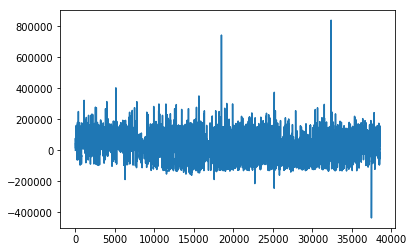

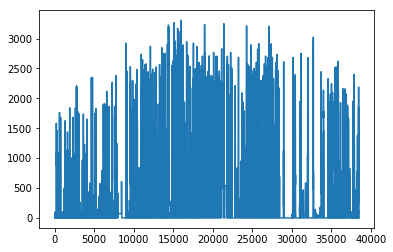

In [17]:
featureArray = np.delete(clean_data_array,missing_labels,axis=0)
print(featureArray.shape)
print(len(labels))
print(len(labels_solar))

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(labels)
plt.figure()
plt.plot(labels_solar)

In [22]:
def split_dataset(featureArray,labels):
    """ 
    Splits data-set into train,val and test
    
    """
    
    data_train = []
    label_train = []
    data_val = []
    label_val = []
    data_test = []
    label_test = []
    for row,idx,label in zip(featureArray,range(featureArray.shape[0]),labels):
        if row[0].day <= 20:
            data_train.append(row)
            label_train.append(label)
        elif row[0].day <=25:
            data_val.append(row)
            label_val.append(label)
        else:
            data_test.append(row)
            label_test.append(label)
    return data_train,label_train,data_val,label_val,data_test,label_test

        

data_train,label_train,data_val,label_val,data_test,label_test = split_dataset(featureArray,labels)



[[Timestamp('2017-01-01 00:00:00') -1.7 99.0 ..., 197.0 1026.0 0.0]
 [Timestamp('2017-01-01 00:10:00') -1.7 99.0 ..., 195.0 1025.8 0.0]
 [Timestamp('2017-01-01 00:20:00') -1.7 99.0 ..., 271.0 1025.6 0.0]
 ..., 
 [Timestamp('2017-10-19 23:30:00') 17.1 74.0 ..., 20000.0 1007.3
  1.7782790000000002]
 [Timestamp('2017-10-19 23:40:00') 16.8 76.0 ..., 19700.0 1007.3 1.154782]
 [Timestamp('2017-10-19 23:50:00') 16.6 78.0 ..., 19900.0 1007.4 0.143301]]


In [ ]:
#Normalize the data first
scaler = StandardScaler()
scaler.fit(featureArray[:,1:])
X_train = scaler.transform(featureArray[:,1:])

# Create an SGD regressor
clf = linear_model.SGDRegressor(max_iter = np.ceil(10**6 /X_train.shape[0]),
                                learning_rate = 'optimal',
                                loss = 'squared_loss',
                                penalty = 'l2'
                                )
# Fit the data and the labels
clf.fit(X_train, labels)
print(clf.coef_)

clf_solar = linear_model.SGDRegressor(max_iter = np.ceil(10**6 /X_train.shape[0]),
                                learning_rate = 'optimal',
                                loss = 'squared_loss',
                                penalty = 'l2'
                                )
clf_solar.fit(X_train,labels_solar)
print(clf_solar.coef_)